In [1]:
# @title: imports, and graphics setup
import os
import warnings
import re
import sys
sys.path.append('..')

import numpy as np
import scipy.stats as stats
from scipy import integrate as integrate
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
from scipy.constants import Boltzmann as kb

from tqdm.auto import tqdm, trange
from multiprocessing import Pool, TimeoutError
from joblib import Parallel, delayed

from Modules.pdfs import *
from Modules.potentials import harmonic_potential

import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline
import matplotlib.colors as mcol
import matplotlib.cm as cm
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline
matplotlib.style.use('default')
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

#### units converter

In [2]:
real_k_conv_factor = 1e-6

dt = 0.1
def convert_arbitrary_time_to_seconds(sim_gamma, real_k_conv_factor=1e-6, real_R=0.5*1e-6):
    water_viscosity = 0.00089
    real_gamma = 6 * np.pi * water_viscosity * real_R
    real_time_scale = real_gamma/real_k_conv_factor
    sim_time_scale = sim_gamma/1
    real_time =  real_time_scale/sim_time_scale #units: sec/sim_time
    return real_time #units: sec/sim_time

print('Real dt =',dt*convert_arbitrary_time_to_seconds(500, real_k_conv_factor=1*1e-6, real_R=0.5*1e-6), 'seconds')


print('Real k =',5*real_k_conv_factor, 'pN/um')

Real dt = 1.6776104770169494e-06 seconds
Real k = 4.9999999999999996e-06 pN/um


## Determine relaxation time (FIG 1)


In [54]:
dt = 0.1
gamma = 500
kT = 1
steps = 10000
n_particles = 150000
batch_size = 10000
batches = int(n_particles/batch_size)
D=kT/gamma

real_time = convert_arbitrary_time_to_seconds(gamma)
real_time_ms = real_time * 1e3  # convert to ms

### Harmonic Potential Parameters ###
k_harm = 2
force_args = [k_harm]
typical_relaxation_time = gamma/k_harm
omega_zero = k_harm/gamma

### resetting parameters ### 
delta_fractions = (k_harm/5)*np.linspace(0, 0.01, 6)
resetting_rates = delta_fractions/dt

sherf_nums = gamma*resetting_rates/k_harm
print('Sherf numbers:', sherf_nums)

resetting_rates_str = [f'{rate:.3f}'[1:] for rate in resetting_rates]
resetting_rates_str = ','.join(resetting_rates_str)
folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str}_K-{k_harm}'
print('Folder -', folder)

Sherf numbers: [ 0.  2.  4.  6.  8. 10.]
Folder - HarmonicPotentialTrajectories/R-.000,.008,.016,.024,.032,.040_K-2


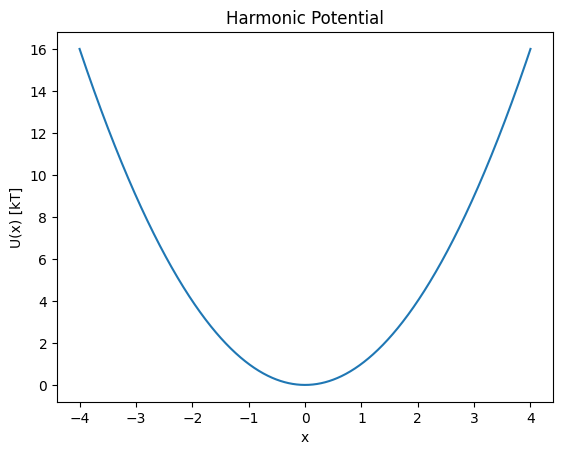

In [55]:
### plot potential ###
from Modules.potentials import harmonic_potential
potential_x = np.linspace(-4, 4, 1000)
potential_y = harmonic_potential(potential_x, k_harm)/kT
plt.plot(potential_x, potential_y)
plt.xlabel('x')
plt.ylabel('U(x) [kT]')
plt.title('Harmonic Potential')
plt.show()

In [56]:
histograms_per_rate = np.load(folder+'/histograms_per_rate.npy')

In [57]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make a user-defined colormap.
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b",'purple',"r"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=min(resetting_rates),vmax=max(resetting_rates))

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)

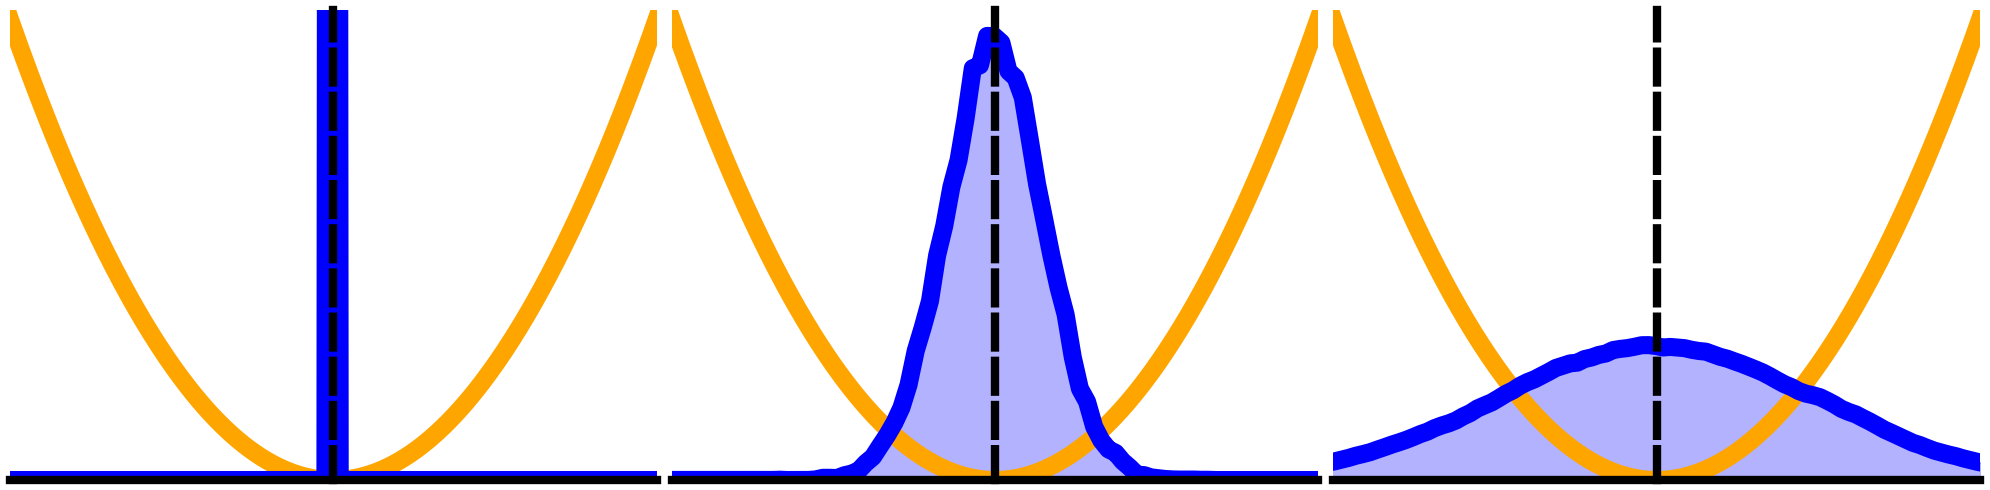

In [71]:
### plot no resetting histograms ###

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
axs = ax.ravel()
color = cpick.to_rgba(0.0)  # No resetting rate corresponds to 0.0
boltzmann_histograms = histograms_per_rate[0]
xlim = (-1.4, 1.4)
ylim = (0, 2)
for i in range(3):
    if i == 0:
        hist, bin_centers = boltzmann_histograms[0]
    elif i == 1:
        hist, bin_centers = boltzmann_histograms[24]
    else:
        hist, bin_centers = boltzmann_histograms[-1]
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set(position=('data', 0), lw=6,linestyle='--')
    axs[i].spines['bottom'].set(lw=6)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].plot(bin_centers, hist,color=color, linewidth=13, zorder=2)
    axs[i].fill_between(bin_centers, hist, alpha=0.3, color=color)
    axs[i].plot(potential_x, potential_y, label='U(x)', color='Orange', linewidth=13, zorder=1)
    axs[i].set_xlim(*xlim)
    axs[i].set_ylim(*ylim)
plt.tight_layout()
figname = 'a - Boltzmann PDF Relaxation - Harmonic.svg'
path = os.path.join('Figures/Figure1',figname)
plt.savefig(path, bbox_inches='tight',format='svg', dpi=500)
plt.show()

resetting used:  6.0 $\omega_0$
resetting used:  1.4306062300395088 $ms$


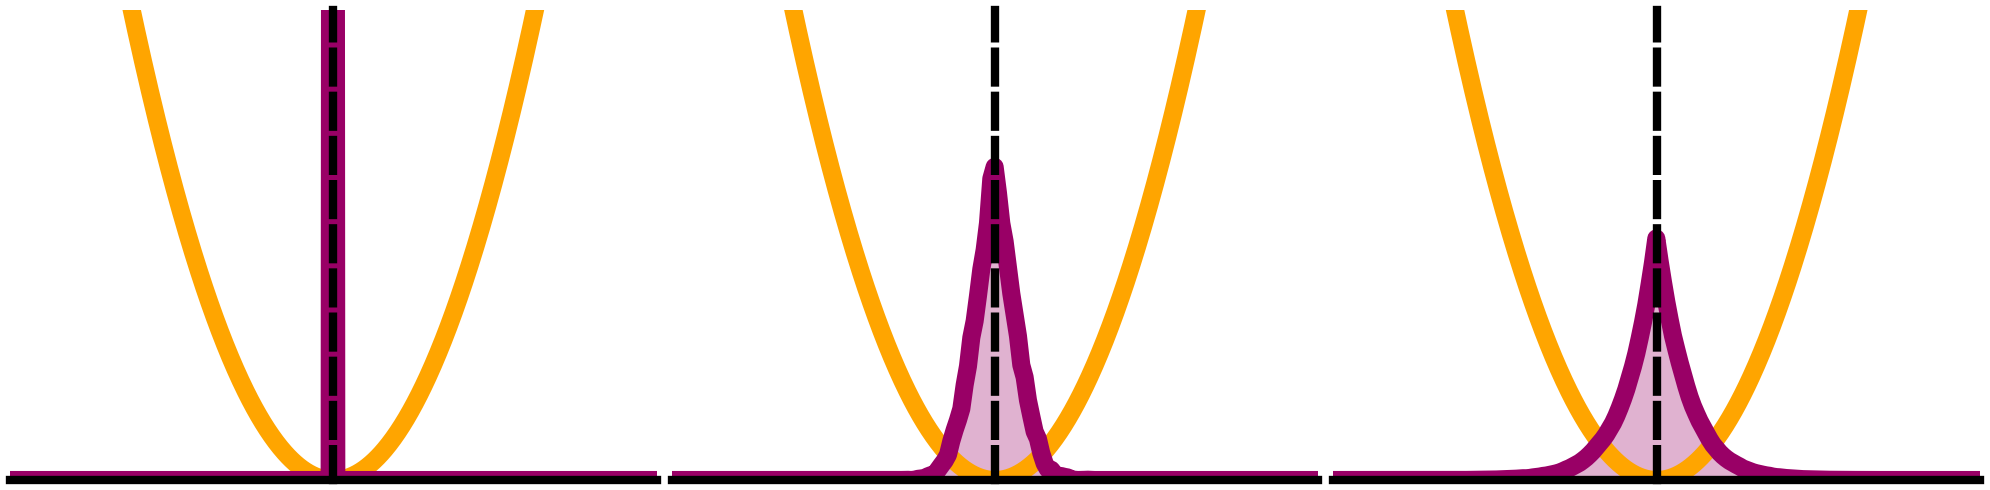

In [73]:
### plot no resetting histograms ###



fig, ax = plt.subplots(1, 3, figsize=(20, 5))
axs = ax.ravel()

r_indx = 3
resetting_histograms = histograms_per_rate[r_indx]
print('resetting used: ', resetting_rates[r_indx]/omega_zero, '$\\omega_0$')
print('resetting used: ', resetting_rates[r_indx]/real_time_ms, '$ms$')
color= cpick.to_rgba(resetting_rates[r_indx]) 
xlim = (-3, 3)
ylim = (0, 3.5) 
for i in range(3):
    if i == 0:
        hist, bin_centers = resetting_histograms[0]
    elif i == 1:
        hist, bin_centers = resetting_histograms[24]
    else:
        hist, bin_centers = resetting_histograms[-1]
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set(position=('data', 0), lw=6,linestyle='--')
    axs[i].spines['bottom'].set(lw=6)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].plot(bin_centers, hist,color=color, linewidth=13, zorder=2)
    axs[i].fill_between(bin_centers, hist, alpha=0.3, color=color)
    axs[i].plot(potential_x, potential_y, label='U(x)', color='Orange', linewidth=13, zorder=1)
    axs[i].set_xlim(*xlim)
    axs[i].set_ylim(*ylim)
plt.tight_layout()
figname = 'a - Resetting PDF Relaxation - Harmonic - with stronger resetting.svg'
path = os.path.join('Figures/Figure1',figname)
plt.savefig(path, bbox_inches='tight',format='svg', dpi=500)
plt.show()

In [61]:
KLDs_per_rate =  np.load(folder+'/KLD_per_rate.npy')

In [62]:
samples = 5
target_distribution_samples = 500
steady_state = 12000
timesteps = np.arange(0, steady_state, 5)

In [63]:
kld_thresholds = []
for kld_per_time in KLDs_per_rate:
    kld_threshold = np.min(kld_per_time[-50:])
    kld_threshold_std = np.std(kld_per_time[-50:])
    kld_threshold = kld_threshold + 10*kld_threshold_std
    kld_thresholds.append(kld_threshold)
kld_threshold = max(kld_thresholds)
print('KLD threshold:', kld_threshold)

platue_index_per_r = []
for kld_per_time, r in zip(KLDs_per_rate, resetting_rates):
    platue_index = np.where(kld_per_time < kld_threshold)[0][0]
    timestep_platue = timesteps[platue_index]*dt
    platue_index_per_r.append(timestep_platue)
platue_index_per_r = np.array(platue_index_per_r)

KLD threshold: 0.03714447803436968


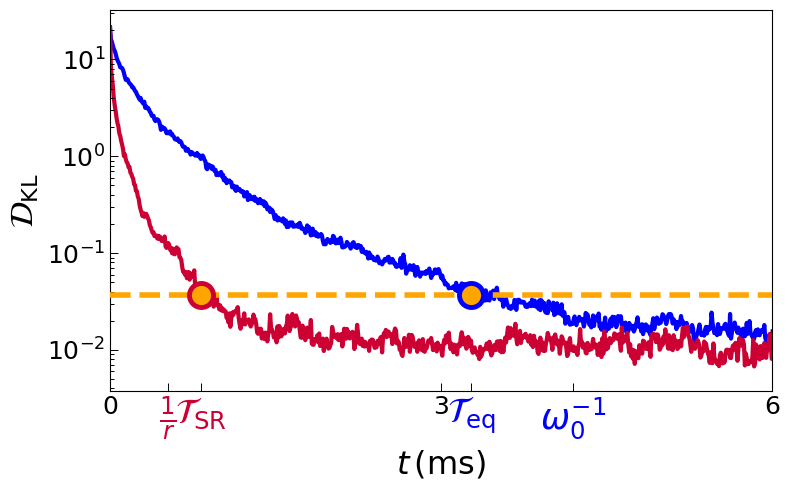

In [ ]:

fig, ax = plt.subplots(figsize=(8, 5))

resetting_to_print = [resetting_rates[0], resetting_rates[4]]
x_ticks = []
for kld_per_time, platue, r in zip(KLDs_per_rate, platue_index_per_r, resetting_rates):
    if r not in resetting_to_print:
        continue
    adjusted_timesteps = timesteps*dt*real_time_ms
    adjusted_platue = platue*real_time_ms
    x_ticks.append(adjusted_platue)
    im=ax.semilogy(adjusted_timesteps,kld_per_time, label=f'{r:.3f}', color=cpick.to_rgba(r), lw=3, zorder=1)
    #if r != 0:
        #im=ax.axvline(x=real_time_ms/resetting_to_print[1], color=cpick.to_rgba(r), linestyle='--', label='$\\r^{-1}$', lw=4, zorder=5)
    im=ax.scatter(adjusted_platue, kld_threshold, color='orange', marker='o', s=300, edgecolor=cpick.to_rgba(r), linewidth=3.5, zorder=10)
#im=ax.axvline(x=typical_relaxation_time*real_time_ms, color='blue', linestyle='--', label='$\\omega_0^{-1}$', lw=4, zorder=5)
im = ax.axhline(kld_threshold, color='orange', linestyle='--', label='KLD threshold', lw=4, zorder=5)
threshold_handle = plt.Line2D([0],[0],linestyle='--',color='orange', label=f'threshold')
intersect_handle = plt.Line2D([0],[0],linestyle='', marker='o',color='Orange', label=f'$\\tau$', markersize=8)
resetting_rate_handles = []
for r in resetting_rates:
    if r not in resetting_to_print:
        continue
    h = plt.Line2D([0],[0],color=cpick.to_rgba(r),label=f'r={r:.3f}', linestyle='-', lw=3)
    resetting_rate_handles.append(h)
handles = resetting_rate_handles
ax.set_xlabel('$t \\,(\\mathrm{ms})$', fontsize=23)
ax.set_ylabel('$\\mathcal{D}_{\\rm KL}$',fontsize=23)
ax.set_xlim(0, 6)
ax.set_yscale('log')

relax_time_values = [typical_relaxation_time*real_time_ms, real_time_ms/resetting_to_print[1]]
relax_time_labels = ['$\\omega_0^{-1}$', '$\\frac{1}{r}$']
x_ticks_values = np.concatenate(([0,3,6], x_ticks, relax_time_values))
x_ticks_labels = [0,3,6,"$\\mathcal{T}_{\\rm eq}$","$\\mathcal{T}_{\\rm SR}$"] + relax_time_labels
ax.set_xticks(x_ticks_values, x_ticks_labels)
xtick_labels = ax.get_xticklabels()
ax.tick_params(axis='both', which='major', labelsize=18, direction='in',length=6, width=0.7)
ax.tick_params(axis='both', which='minor', labelsize=18, direction='in',length=3, width=0.7)
x_ticks_colors = ['black']*3 + ['blue', cpick.to_rgba(resetting_to_print[1])] + ['blue', cpick.to_rgba(resetting_to_print[1])]

for i, (c, label) in enumerate(zip(x_ticks_colors, xtick_labels)):
    label.set_color(c)
    if c != 'black':
        label.set_fontsize(25)
        if i > 5:
            #label.set_y(-0.02)
            label.set_fontsize(25)
            #label.set_color('darkred')
#ax.set_xticklabels(x_ticks_labels, **x_ticks_params)
#ax.set_xticks(x_ticks, [f'{x:.2f}' for x in x_ticks])
#ax.legend(handles=handles, fontsize=18, loc='upper right', handlelength=0.75, handletextpad=0.5)
plt.tight_layout()
plt.savefig('Figures/determine relaxation time.svg', format='svg', dpi=500)
plt.show()


## Initial Conditions (Fig 4)

In [56]:
### Simulation Parameters ###

dt = 0.1
gamma = 500
kT = 1
steps = 10000
n_particles = 200000
batch_size = 8000
batches = int(n_particles/batch_size)
D=kT/gamma

### Harmonic Potential Parameters ###
k_harm = 5
force_args = [k_harm]

typical_relaxation_time = gamma/k_harm
print(typical_relaxation_time)

typical_length_scale = np.sqrt(D*typical_relaxation_time)
print(typical_length_scale)
### resetting parameters ### 
delta_fraction = 0.002
resetting_rate = delta_fraction/dt
start_positions = np.linspace(np.floor(-10*typical_length_scale), 0, 16)[::-1]
print(start_positions)

start_positions_str = [f'{abs(x):.2f}'[:] for x in start_positions]
start_positions_str = ','.join(start_positions_str)
folder = f'HarmonicPotentialTrajectories/x_0-{start_positions_str}'
print('Folder -', folder)

100.0
0.4472135954999579
[ 0.         -0.33333333 -0.66666667 -1.         -1.33333333 -1.66666667
 -2.         -2.33333333 -2.66666667 -3.         -3.33333333 -3.66666667
 -4.         -4.33333333 -4.66666667 -5.        ]
Folder - HarmonicPotentialTrajectories/x_0-0.00,0.33,0.67,1.00,1.33,1.67,2.00,2.33,2.67,3.00,3.33,3.67,4.00,4.33,4.67,5.00


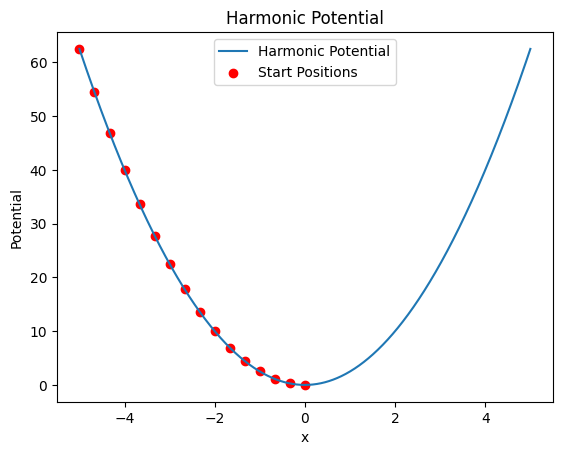

In [57]:
### plot potential ###
potential_x = np.linspace(-5, 5, 1000)
potential_y = harmonic_potential(potential_x, k_harm)/kT
plt.plot(potential_x, potential_y, label='Harmonic Potential')
plt.scatter(start_positions, harmonic_potential(np.array(start_positions), k_harm)/kT, color='red', label='Start Positions')
plt.title('Harmonic Potential')
plt.xlabel('x')
plt.ylabel('Potential')
plt.legend()
plt.show()

In [58]:
histograms_per_start_pos = np.load(folder+'/histograms_per_start_pos.npy')

start position: 0.0 $\sigma$
start position: -2.23606797749979 $\sigma$
start position: -4.47213595499958 $\sigma$


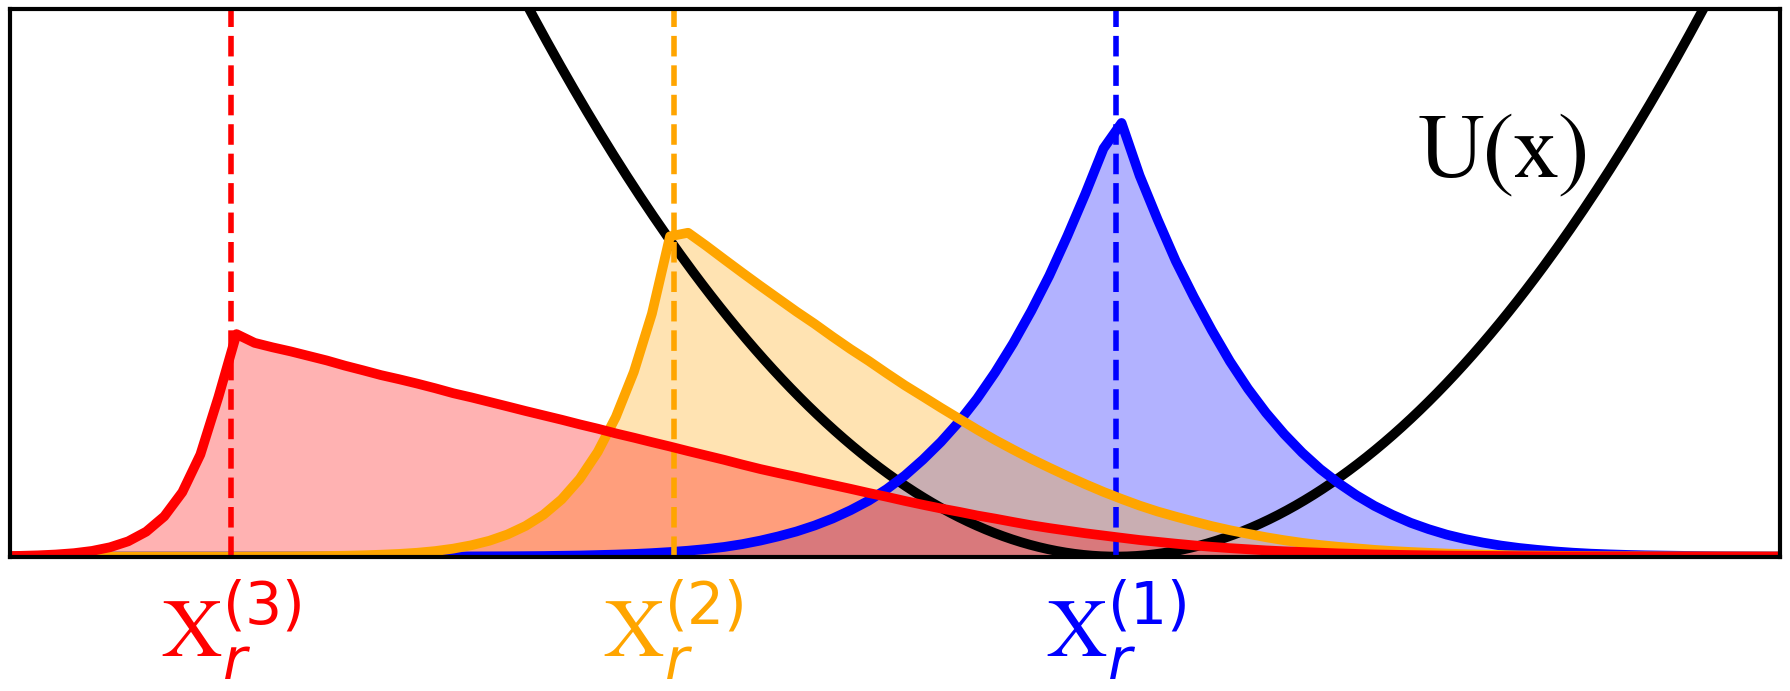

In [ ]:
### plot no resetting histograms ###

fig, ax = plt.subplots(1, 1, figsize=(18, 7), edgecolor='black')
xlim = (-2.5, 1.5)
ylim = (0, 2.2)
positions_to_print = [0, 3, 6]
c = 0
for i ,hists in enumerate(histograms_per_start_pos):
    if i not in positions_to_print:
        continue
    if i == positions_to_print[-1]:
        color = 'red'
    elif i == positions_to_print[0]:
        color = 'blue'
    elif i == positions_to_print[1]:
        color = 'orange'
    c+= 1
    print('start position:', start_positions[i]/typical_length_scale, '$\\sigma$')
    ss_hist, ss_bin_centers = hists[-1]
    ax.spines['top'].set_visible(True)
    ax.spines['top'].set(lw=3)
    ax.spines['right'].set_visible(True)
    ax.spines['right'].set(lw=3)
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set(lw=3)
    ax.spines['bottom'].set(lw=3)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.text(
    start_positions[i], -0.5,
    r"X$_r^{("+str(c)+")}$",
    fontsize=60, ha='center', va='bottom', color=color,
    fontdict={'family': 'Times New Roman'}
) 
    ax.axvline(start_positions[i], color=color, linestyle='--', lw=4)
    ax.plot(ss_bin_centers, ss_hist,color=color, linewidth=7, zorder=2)
    ax.fill_between(ss_bin_centers, ss_hist, alpha=0.3, color=color)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
ax.plot(potential_x, potential_y*0.5, label='U(x)', color='Black', linewidth=7, zorder=1)
ax.text(0.875, 1.45, 'U(x)', fontsize=65, ha='center', va='bottom', color='Black', font={'family': 'Times New Roman'})
start_positions_handle = [plt.Line2D([0], [0], color='black', linewidth=4, linestyle='--', label='Resetting Position')]
potential_handle = [plt.Line2D([0], [0], color='Orange', linewidth=7, label='U(x)')]
plt.tight_layout()
figname = 'Fig 4 - NESS by Xr.svg'
path = os.path.join('Figures/OVERLEAF',figname)
plt.savefig(path,bbox_inches='tight',format='svg', dpi=500)
plt.show()

## Initial Conditions (Fig 5)

#### old

In [3]:
dt = 0.1
k_regular = 5
k_fast_rate = 5
k_strong_stiff = 25
gamma = 500
r_regular = 0.002/dt
r_fast_rate = 0.01/dt
r_strong_stiff = 0.002/dt
kT = 1

std_regular = np.sqrt(kT / k_regular)
std_fast_rate = np.sqrt(kT / k_fast_rate)
std_strong_stiff = np.sqrt(kT / k_strong_stiff)

sherf_num_regular = gamma * r_regular / k_regular
sherf_num_fast_rate = gamma * r_fast_rate / k_fast_rate
sherf_num_strong_stiff = gamma * r_strong_stiff / k_strong_stiff

In [4]:
regular_folder = 'HarmonicPotentialTrajectories/x_0-0.00,0.33,0.67,1.00,1.33,1.67,2.00,2.33,2.67,3.00,3.33,3.67,4.00,4.33,4.67,5.00'
regular_folder_boltz = 'HarmonicPotentialTrajectories/x_0_r_0-0.00,0.33,0.67,1.00,1.33,1.67,2.00,2.33,2.67,3.00,3.33,3.67,4.00,4.33,4.67,5.00'

fast_rate_folder = 'HarmonicPotentialTrajectories/x_0-0.00,0.33,0.67,1.00,1.33,1.67,2.00,2.33,2.67,3.00,3.33,3.67,4.00,4.33,4.67,5.00-faster rate'
fast_rate_folder_boltz = 'HarmonicPotentialTrajectories/x_0_r_0-0.00,0.33,0.67,1.00,1.33,1.67,2.00,2.33,2.67,3.00,3.33,3.67,4.00,4.33,4.67,5.00'

strong_stiff_folder = 'HarmonicPotentialTrajectories/x_0-0.00,0.13,0.27,0.40,0.53,0.67,0.80,0.93,1.07,1.20,1.33,1.47,1.60,1.73,1.87,2.00-stronger stiffness'
strong_stiff_folder_boltz = 'HarmonicPotentialTrajectories/x_0_r_0-0.00,0.13,0.27,0.40,0.53,0.67,0.80,0.93,1.07,1.20,1.33,1.47,1.60,1.73,1.87,2.00-stronger stiffness'

In [5]:
### Load relaxation times 
regular_mean_relaxation_times = np.load(regular_folder+'/mean_platue_indices_per_K.npy')
regular_std_relaxation_times = np.load(regular_folder+'/std_platue_indices_per_K.npy')
regular_mean_relaxation_times_boltz = np.load(regular_folder_boltz+'/mean_platue_indices_per_K_boltz.npy')
regular_std_relaxation_times_boltz = np.load(regular_folder_boltz+'/std_platue_indices_per_K_boltz.npy')
fast_rate_mean_relaxation_times = np.load(fast_rate_folder+'/mean_platue_indices_per_K.npy')
fast_rate_std_relaxation_times = np.load(fast_rate_folder+'/std_platue_indices_per_K.npy')
fast_rate_mean_relaxation_times_boltz = np.load(fast_rate_folder_boltz+'/mean_platue_indices_per_K_boltz.npy')
fast_rate_std_relaxation_times_boltz = np.load(fast_rate_folder_boltz+'/std_platue_indices_per_K_boltz.npy')
strong_stiff_mean_relaxation_times = np.load(strong_stiff_folder+'/mean_platue_indices_per_K.npy')
strong_stiff_std_relaxation_times = np.load(strong_stiff_folder+'/std_platue_indices_per_K.npy')
strong_stiff_mean_relaxation_times_boltz = np.load(strong_stiff_folder_boltz+'/mean_platue_indices_per_K.npy')
strong_stiff_std_relaxation_times_boltz = np.load(strong_stiff_folder_boltz+'/std_platue_indices_per_K.npy')


### Normzalize relaxation time accordint to first boltzmann time

regular_mean_relaxation_times = regular_mean_relaxation_times/regular_mean_relaxation_times_boltz[0]
regular_std_relaxation_times = regular_std_relaxation_times/regular_mean_relaxation_times_boltz[0]
fast_rate_mean_relaxation_times = fast_rate_mean_relaxation_times/fast_rate_mean_relaxation_times_boltz[0]
fast_rate_std_relaxation_times = fast_rate_std_relaxation_times/fast_rate_mean_relaxation_times_boltz[0]
strong_stiff_mean_relaxation_times = strong_stiff_mean_relaxation_times/strong_stiff_mean_relaxation_times_boltz[0]
strong_stiff_std_relaxation_times = strong_stiff_std_relaxation_times/strong_stiff_mean_relaxation_times_boltz[0]
boltz_mean_relaxation_times = regular_mean_relaxation_times_boltz/regular_mean_relaxation_times_boltz[0]
boltz_std_relaxation_times = regular_std_relaxation_times_boltz/regular_mean_relaxation_times_boltz[0]
boltz_2_mean_relaxation_times = fast_rate_mean_relaxation_times_boltz/fast_rate_mean_relaxation_times_boltz[0]
boltz_2_std_relaxation_times = fast_rate_std_relaxation_times_boltz/fast_rate_mean_relaxation_times_boltz[0]
boltz_3_mean_relaxation_times = strong_stiff_mean_relaxation_times_boltz/strong_stiff_mean_relaxation_times_boltz[0]
boltz_3_std_relaxation_times = strong_stiff_std_relaxation_times_boltz/strong_stiff_mean_relaxation_times_boltz[0]


regular_starting_positions = np.load(regular_folder+'/start_positions.npy')
fast_rate_starting_positions = np.load(fast_rate_folder+'/start_positions.npy')
strong_stiff_starting_positions = np.load(strong_stiff_folder+'/start_positions.npy')

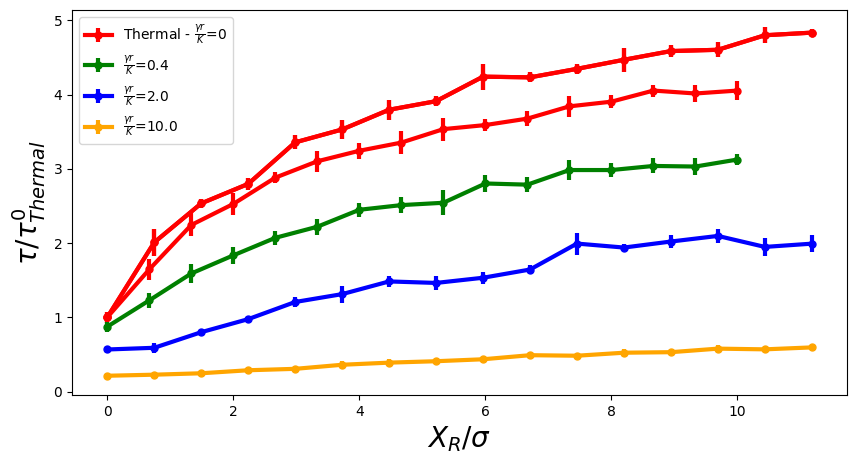

In [6]:
### plot relaxation times

plt.figure(figsize=(10, 5))
label_regular = '$\\frac{\\gamma r}{K}$='+f'{sherf_num_regular:.1f}'
label_fast_rate = '$\\frac{\\gamma r}{K}$='+f'{sherf_num_fast_rate:.1f}'
label_strong_stiff = '$\\frac{\\gamma r}{K}$='+f'{sherf_num_strong_stiff:.1f}'
label_boltz = 'Thermal - $\\frac{\\gamma r}{K}$='+f'{0}'
plt.errorbar(fast_rate_starting_positions, boltz_2_mean_relaxation_times, yerr=boltz_2_std_relaxation_times, label=label_boltz, color='red', marker='o', markersize=5, linewidth=3)
plt.errorbar(strong_stiff_starting_positions, boltz_3_mean_relaxation_times, yerr=boltz_3_std_relaxation_times, color='red', marker='o', markersize=5, linewidth=3)
plt.errorbar(regular_starting_positions, boltz_mean_relaxation_times, yerr=boltz_std_relaxation_times, color='red', marker='o', markersize=5, linewidth=3)
plt.errorbar(strong_stiff_starting_positions, strong_stiff_mean_relaxation_times, yerr=strong_stiff_std_relaxation_times, label=label_strong_stiff, color='green', marker='o', markersize=5, linewidth=3)
plt.errorbar(regular_starting_positions, regular_mean_relaxation_times, yerr=regular_std_relaxation_times, label=label_regular, color='blue', marker='o', markersize=5, linewidth=3)
plt.errorbar(fast_rate_starting_positions, fast_rate_mean_relaxation_times, yerr=fast_rate_std_relaxation_times, label=label_fast_rate, color='orange', marker='o', markersize=5, linewidth=3)
plt.xlabel('$X_R/\\sigma$',fontsize=20)
plt.ylabel('$\\tau/\\tau^0_{Thermal}$', fontsize=20)
plt.legend()
plt.show()


In [7]:
### Load relaxation times 
regular_mean_relaxation_times = np.load(regular_folder+'/mean_platue_indices_per_K.npy')
regular_std_relaxation_times = np.load(regular_folder+'/std_platue_indices_per_K.npy')
regular_mean_relaxation_times_boltz = np.load(regular_folder_boltz+'/mean_platue_indices_per_K_boltz.npy')
regular_std_relaxation_times_boltz = np.load(regular_folder_boltz+'/std_platue_indices_per_K_boltz.npy')
fast_rate_mean_relaxation_times = np.load(fast_rate_folder+'/mean_platue_indices_per_K.npy')
fast_rate_std_relaxation_times = np.load(fast_rate_folder+'/std_platue_indices_per_K.npy')
fast_rate_mean_relaxation_times_boltz = np.load(fast_rate_folder_boltz+'/mean_platue_indices_per_K_boltz.npy')
fast_rate_std_relaxation_times_boltz = np.load(fast_rate_folder_boltz+'/std_platue_indices_per_K_boltz.npy')
strong_stiff_mean_relaxation_times = np.load(strong_stiff_folder+'/mean_platue_indices_per_K.npy')
strong_stiff_std_relaxation_times = np.load(strong_stiff_folder+'/std_platue_indices_per_K.npy')
strong_stiff_mean_relaxation_times_boltz = np.load(strong_stiff_folder_boltz+'/mean_platue_indices_per_K.npy')
strong_stiff_std_relaxation_times_boltz = np.load(strong_stiff_folder_boltz+'/std_platue_indices_per_K.npy')


### Normzalize relaxation time accordint to first boltzmann time

regular_mean_relaxation_times = regular_mean_relaxation_times/regular_mean_relaxation_times_boltz
regular_std_relaxation_times = regular_std_relaxation_times/regular_mean_relaxation_times_boltz
fast_rate_mean_relaxation_times = fast_rate_mean_relaxation_times/fast_rate_mean_relaxation_times_boltz
fast_rate_std_relaxation_times = fast_rate_std_relaxation_times/fast_rate_mean_relaxation_times_boltz
strong_stiff_mean_relaxation_times = strong_stiff_mean_relaxation_times/strong_stiff_mean_relaxation_times_boltz
strong_stiff_std_relaxation_times = strong_stiff_std_relaxation_times/strong_stiff_mean_relaxation_times_boltz
boltz_mean_relaxation_times = regular_mean_relaxation_times_boltz/regular_mean_relaxation_times_boltz
boltz_std_relaxation_times = regular_std_relaxation_times_boltz/regular_mean_relaxation_times_boltz
boltz_2_mean_relaxation_times = fast_rate_mean_relaxation_times_boltz/fast_rate_mean_relaxation_times_boltz
boltz_2_std_relaxation_times = fast_rate_std_relaxation_times_boltz/fast_rate_mean_relaxation_times_boltz
boltz_3_mean_relaxation_times = strong_stiff_mean_relaxation_times_boltz/strong_stiff_mean_relaxation_times_boltz
boltz_3_std_relaxation_times = strong_stiff_std_relaxation_times_boltz/strong_stiff_mean_relaxation_times_boltz

regular_starting_positions = np.load(regular_folder+'/start_positions.npy')
fast_rate_starting_positions = np.load(fast_rate_folder+'/start_positions.npy')
strong_stiff_starting_positions = np.load(strong_stiff_folder+'/start_positions.npy')

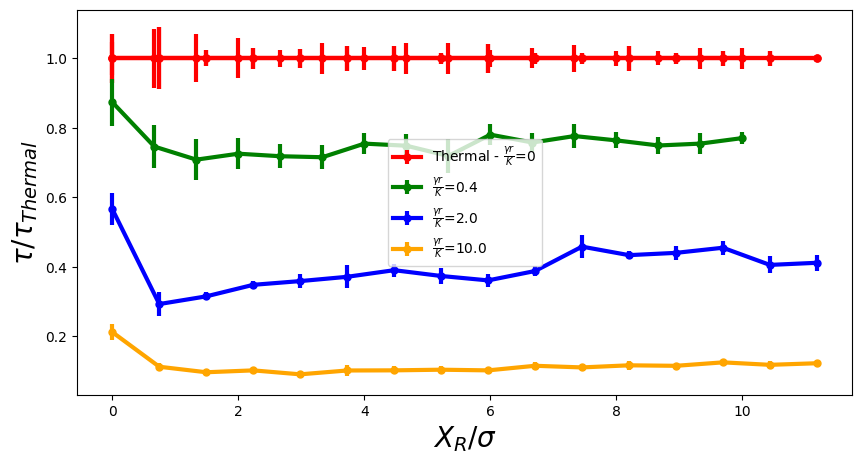

In [8]:
### plot relaxation times

plt.figure(figsize=(10, 5))
label_regular = '$\\frac{\\gamma r}{K}$='+f'{sherf_num_regular:.1f}'
label_fast_rate = '$\\frac{\\gamma r}{K}$='+f'{sherf_num_fast_rate:.1f}'
label_strong_stiff = '$\\frac{\\gamma r}{K}$='+f'{sherf_num_strong_stiff:.1f}'
label_boltz = 'Thermal - $\\frac{\\gamma r}{K}$='+f'{0}'
plt.errorbar(fast_rate_starting_positions, boltz_2_mean_relaxation_times, yerr=boltz_2_std_relaxation_times, label=label_boltz, color='red', marker='o', markersize=5, linewidth=3)
plt.errorbar(strong_stiff_starting_positions, boltz_3_mean_relaxation_times, yerr=boltz_3_std_relaxation_times, color='red', marker='o', markersize=5, linewidth=3)
plt.errorbar(regular_starting_positions, boltz_mean_relaxation_times, yerr=boltz_std_relaxation_times, color='red', marker='o', markersize=5, linewidth=3)
plt.errorbar(strong_stiff_starting_positions, strong_stiff_mean_relaxation_times, yerr=strong_stiff_std_relaxation_times, label=label_strong_stiff, color='green', marker='o', markersize=5, linewidth=3)
plt.errorbar(regular_starting_positions, regular_mean_relaxation_times, yerr=regular_std_relaxation_times, label=label_regular, color='blue', marker='o', markersize=5, linewidth=3)
plt.errorbar(fast_rate_starting_positions, fast_rate_mean_relaxation_times, yerr=fast_rate_std_relaxation_times, label=label_fast_rate, color='orange', marker='o', markersize=5, linewidth=3)
plt.xlabel('$X_R/\\sigma$',fontsize=20)
plt.ylabel('$\\tau/\\tau_{Thermal}$', fontsize=20)
plt.legend()
plt.show()


### Varying $X_R$ and S number

In [13]:
### Simulation Parameters ###
dt = 0.1
gamma = 500
kT = 1
steps = 10000
n_particles = 50000
batch_size = 10000
batches = int(n_particles/batch_size)
D=kT/gamma

### Harmonic Potential Parameters ###
k_harm = 5
k_harm_2 = 2
k_harm_10 = 10
typical_length_scale = np.sqrt(kT/k_harm)
typical_length_scale_2 = np.sqrt(kT/k_harm_2)
typical_length_scale_10 = np.sqrt(kT/k_harm_10)
start_position_ratios = np.linspace(0,5,6)
start_position_ratios_smaller_than_1 = np.linspace(0,1,11)
start_position_ratios_smaller_than_1 = start_position_ratios_smaller_than_1[1:-1]  # Exclude 0 and 1
start_positions = -start_position_ratios * typical_length_scale
start_positions_smaller_than_1 = -start_position_ratios_smaller_than_1 * typical_length_scale
start_positions_2 = -start_position_ratios * typical_length_scale_2
start_positions_10 = -start_position_ratios * typical_length_scale_10
start_positions_2_smaller_than_1 = -start_position_ratios_smaller_than_1 * typical_length_scale_2
start_positions_10_smaller_than_1 = -start_position_ratios_smaller_than_1 * typical_length_scale_10
start_positions_str = [f'{pos:.3f}'[1:] for pos in start_positions]
start_positions_str = ','.join(start_positions_str)
start_positions_2_str = [f'{pos:.3f}'[1:] for pos in start_positions_2]
start_positions_2_str = ','.join(start_positions_2_str)
start_positions_10_str = [f'{pos:.3f}'[1:] for pos in start_positions_10]
start_positions_10_str = ','.join(start_positions_10_str)
start_positions_smaller_than_1_str = [f'{pos:.3f}'[1:] for pos in start_positions_smaller_than_1]
start_positions_smaller_than_1_str = ','.join(start_positions_smaller_than_1_str)
start_positions_2_smaller_than_1_str = [f'{pos:.3f}'[1:] for pos in start_positions_2_smaller_than_1]
start_positions_2_smaller_than_1_str = ','.join(start_positions_2_smaller_than_1_str)
start_positions_10_smaller_than_1_str = [f'{pos:.3f}'[1:] for pos in start_positions_10_smaller_than_1]
start_positions_10_smaller_than_1_str = ','.join(start_positions_10_smaller_than_1_str)
### resetting parameters ### 
delta_fractions = k_harm*np.linspace(0, 0.01, 6)/5
delta_fractions_2 = k_harm_2*np.linspace(0, 0.01, 6)/5
delta_fractions_10 = k_harm_10*np.linspace(0, 0.01, 6)/5
colors = cm.rainbow(np.linspace(0, 1, len(delta_fractions)))
colors_2 = cm.rainbow(np.linspace(0, 1, len(delta_fractions_2)))
colors_10 = cm.rainbow(np.linspace(0, 1, len(delta_fractions_10)))
resetting_rates = delta_fractions/dt
resetting_rates_2 = delta_fractions_2/dt
resetting_rates_10 = delta_fractions_10/dt

sherf_nums = gamma*resetting_rates/k_harm
sherf_nums_2 = gamma*resetting_rates_2/k_harm_2
sherf_nums_10 = gamma*resetting_rates_10/k_harm_10
print(f'Sherf numbers for k_harm={k_harm}: {sherf_nums}')
print(f'Sherf numbers for k_harm_2={k_harm_2}: {sherf_nums_2}')
print(f'Sherf numbers for k_harm_10={k_harm_10}: {sherf_nums_10}')

resetting_rates_str = [f'{rate:.3f}'[1:] for rate in resetting_rates]
resetting_rates_str = ','.join(resetting_rates_str)
resetting_rates_2_str = [f'{rate:.3f}'[1:] for rate in resetting_rates_2]
resetting_rates_2_str = ','.join(resetting_rates_2_str)
resetting_rates_10_str = [f'{rate:.3f}'[1:] for rate in resetting_rates_10]
resetting_rates_10_str = ','.join(resetting_rates_10_str)

folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str}_X-{start_positions_str}'
folder_2 = f'HarmonicPotentialTrajectories/R-{resetting_rates_2_str}_X-{start_positions_2_str}_k={k_harm_2}'
folder_10 = f'HarmonicPotentialTrajectories/R-{resetting_rates_10_str}_X-{start_positions_10_str}_k={k_harm_10}'
subfolders = [folder + f'/X-{start_position:.3f}' for start_position in start_positions]
subfolders_2 = [folder_2 + f'/X-{start_position:.3f}' for start_position in start_positions_2]
subfolders_10 = [folder_10 + f'/X-{start_position:.3f}' for start_position in start_positions_10]
# For smaller than 1
folder_smaller_than_1 = f'HarmonicPotentialTrajectories/R-{resetting_rates_str}_X-{start_positions_smaller_than_1_str}'
folder_2_smaller_than_1 = f'HarmonicPotentialTrajectories/R-{resetting_rates_2_str}_X-{start_positions_2_smaller_than_1_str}_k={k_harm_2}'
folder_10_smaller_than_1 = f'HarmonicPotentialTrajectories/R-{resetting_rates_10_str}_X-{start_positions_10_smaller_than_1_str}_k={k_harm_10}'
subfolders_smaller_than_1 = [folder_smaller_than_1 + f'/X-{start_position:.3f}' for start_position in start_positions_smaller_than_1]
subfolders_2_smaller_than_1 = [folder_2_smaller_than_1 + f'/X-{start_position:.3f}' for start_position in start_positions_2_smaller_than_1]
subfolders_10_smaller_than_1 = [folder_10_smaller_than_1 + f'/X-{start_position:.3f}' for start_position in start_positions_10_smaller_than_1]

Sherf numbers for k_harm=5: [ 0.  2.  4.  6.  8. 10.]
Sherf numbers for k_harm_2=2: [ 0.  2.  4.  6.  8. 10.]
Sherf numbers for k_harm_10=10: [ 0.  2.  4.  6.  8. 10.]


In [14]:
KLDs_per_rate_per_start = np.load(folder + '/KLDs_per_rate_per_start.npy')
platue_index_per_r_per_start = np.load(folder + '/platue_index_per_r_per_start.npy')
KLDs_per_rate_per_start_2 = np.load(folder_2 + '/KLDs_per_rate_per_start.npy')
platue_index_per_r_per_start_2 = np.load(folder_2 + '/platue_index_per_r_per_start.npy')
KLDs_per_rate_per_start_10 = np.load(folder_10 + '/KLDs_per_rate_per_start.npy')
platue_index_per_r_per_start_10 = np.load(folder_10 + '/platue_index_per_r_per_start.npy')

In [15]:
KLDs_per_rate_per_start_smaller_than_1 = np.load(folder_smaller_than_1 + '/KLDs_per_rate_per_start.npy')
platue_index_per_r_per_start_smaller_than_1 = np.load(folder_smaller_than_1 + '/platue_index_per_r_per_start.npy')
KLDs_per_rate_per_start_2_smaller_than_1 = np.load(folder_2_smaller_than_1 + '/KLDs_per_rate_per_start.npy')
platue_index_per_r_per_start_2_smaller_than_1 = np.load(folder_2_smaller_than_1 + '/platue_index_per_r_per_start.npy')
KLDs_per_rate_per_start_10_smaller_than_1 = np.load(folder_10_smaller_than_1 + '/KLDs_per_rate_per_start.npy')
platue_index_per_r_per_start_10_smaller_than_1 = np.load(folder_10_smaller_than_1 + '/platue_index_per_r_per_start.npy')

In [16]:
steady_state = 7000
steady_state_2 = 8000
steady_state_10 = 8000
timesteps = np.arange(0, steady_state, 10)
timesteps_2 = np.arange(0, steady_state_2, 10)
timesteps_10 = np.arange(0, steady_state_10, 10)

In [17]:
KLDs_per_rate_per_start = np.concatenate([[KLDs_per_rate_per_start[0]], KLDs_per_rate_per_start_smaller_than_1 , KLDs_per_rate_per_start[1:]])
platue_index_per_r_per_start = np.concatenate([[platue_index_per_r_per_start[0]], platue_index_per_r_per_start_smaller_than_1 , platue_index_per_r_per_start[1:]])
start_positions = np.concatenate([[start_positions[0]], start_positions_smaller_than_1 , start_positions[1:]])
print(start_positions)
KLDs_per_rate_per_start_2 = np.concatenate([[KLDs_per_rate_per_start_2[0]], KLDs_per_rate_per_start_2_smaller_than_1 , KLDs_per_rate_per_start_2[1:]])
platue_index_per_r_per_start_2 = np.concatenate([[platue_index_per_r_per_start_2[0]], platue_index_per_r_per_start_2_smaller_than_1 , platue_index_per_r_per_start_2[1:]])
start_positions_2 = np.concatenate([[start_positions_2[0]], start_positions_2_smaller_than_1 , start_positions_2[1:]])
KLDs_per_rate_per_start_10 = np.concatenate([[KLDs_per_rate_per_start_10[0]], KLDs_per_rate_per_start_10_smaller_than_1 , KLDs_per_rate_per_start_10[1:]])
platue_index_per_r_per_start_10 = np.concatenate([[platue_index_per_r_per_start_10[0]], platue_index_per_r_per_start_10_smaller_than_1 , platue_index_per_r_per_start_10[1:]])
start_positions_10 = np.concatenate([[start_positions_10[0]], start_positions_10_smaller_than_1 , start_positions_10[1:]])

[-0.         -0.04472136 -0.08944272 -0.13416408 -0.17888544 -0.2236068
 -0.26832816 -0.31304952 -0.35777088 -0.40249224 -0.4472136  -0.89442719
 -1.34164079 -1.78885438 -2.23606798]


In [18]:
normalized_start_positions = start_positions / typical_length_scale
normalized_start_positions_2 = start_positions_2 / typical_length_scale_2
normalized_start_positions_10 = start_positions_10 / typical_length_scale_10

print(f'Start positions normalized: {normalized_start_positions}')
print(f'Start positions normalized for k_harm_2: {normalized_start_positions_2}')
print(f'Start positions normalized for k_harm_10: {normalized_start_positions_10}')

Start positions normalized: [-0.  -0.1 -0.2 -0.3 -0.4 -0.5 -0.6 -0.7 -0.8 -0.9 -1.  -2.  -3.  -4.
 -5. ]
Start positions normalized for k_harm_2: [-0.  -0.1 -0.2 -0.3 -0.4 -0.5 -0.6 -0.7 -0.8 -0.9 -1.  -2.  -3.  -4.
 -5. ]
Start positions normalized for k_harm_10: [-0.  -0.1 -0.2 -0.3 -0.4 -0.5 -0.6 -0.7 -0.8 -0.9 -1.  -2.  -3.  -4.
 -5. ]


In [19]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make a user-defined colormap.
cm1 = cm.rainbow

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=min(normalized_start_positions),vmax=max(normalized_start_positions))

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1.reversed())

colors_starting = [cpick.to_rgba(start) for start in normalized_start_positions]

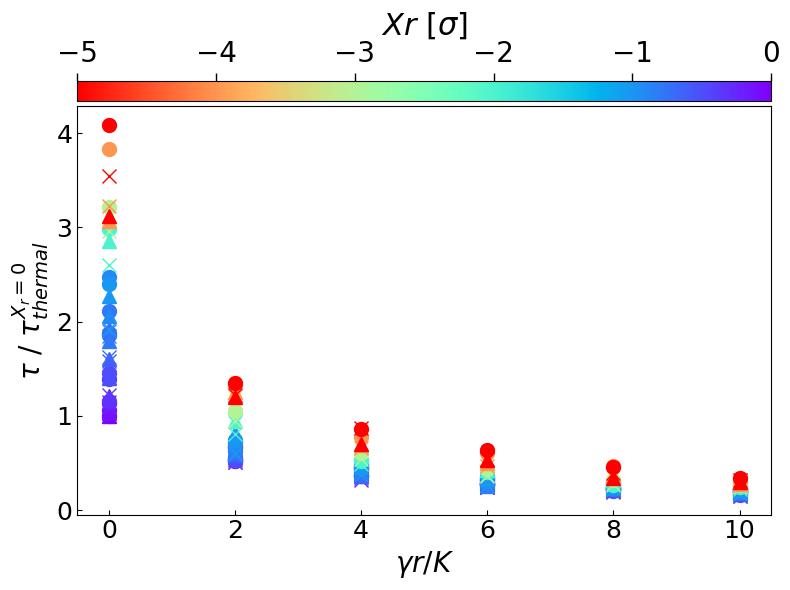

In [21]:
fig , ax = plt.subplots(figsize=(8, 6))
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='5%', pad=0.05)
for i, (platue_index_per_r, platue_index_per_r_2, platue_index_per_r_10, c_start) in enumerate(zip(platue_index_per_r_per_start, platue_index_per_r_per_start_2, platue_index_per_r_per_start_10, colors_starting)):
    for i, s in enumerate(sherf_nums):
        ax.errorbar(sherf_nums[i], platue_index_per_r[i]/platue_index_per_r_per_start[0][0], linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
        ax.errorbar(sherf_nums_2[i], platue_index_per_r_2[i]/platue_index_per_r_per_start_2[0][0], linestyle='--', marker = '^', lw=3, ms=10, color=c_start)
        ax.errorbar(sherf_nums_10[i], platue_index_per_r_10[i]/platue_index_per_r_per_start_10[0][0], linestyle='--', marker = 'x', lw=3, ms=10, color=c_start)
#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)
start_position_handles = [plt.Line2D([0], [0], color=c, lw=3, label=f'Start Position {start_position:.3f}$\\sigma$') for c, start_position in zip(colors_starting, normalized_start_positions)]
ax.set_xlabel('$\\gamma r/K$', fontsize=20)
ax.set_ylabel('$\\tau$ / $\\tau_{thermal}^{X_r=0}$', fontsize=20)
cbar = fig.colorbar(cpick, cax=cax, orientation='horizontal',ticklocation='top')
cbar.ax.tick_params(labelsize=20, direction='out', length=6, width=1)
cbar.ax.set_xlabel('$Xr$ $[\\sigma]$', fontsize=22)
ax.tick_params(axis='both', which='both', labelsize=18, direction='in')
fig.tight_layout()
plt.show()

Slope per start position: [-0.56972417 -0.67769232 -0.62414814 -0.69890956 -0.67999238 -0.74013261
 -0.72415354 -0.76880446 -0.72420433 -0.74763835 -0.68189185 -0.90465187
 -0.85004358 -0.84185116 -0.83039282]
Slope per start position for k_harm_2: [-0.64665459 -0.71256371 -0.70561135 -0.69793474 -0.70879694 -0.69535134
 -0.68681397 -0.66428857 -0.72031913 -0.77702894 -0.8464221  -0.79237746
 -0.83863408 -0.91251527 -0.87763572]
Slope per start position for k_harm_10: [-0.6308116  -0.77577732 -0.66966665 -0.67839187 -0.75064596 -0.72024359
 -0.72598778 -0.67331013 -0.72135692 -0.7005703  -0.76755599 -0.79744197
 -0.85856956 -0.8270647  -0.85505962]


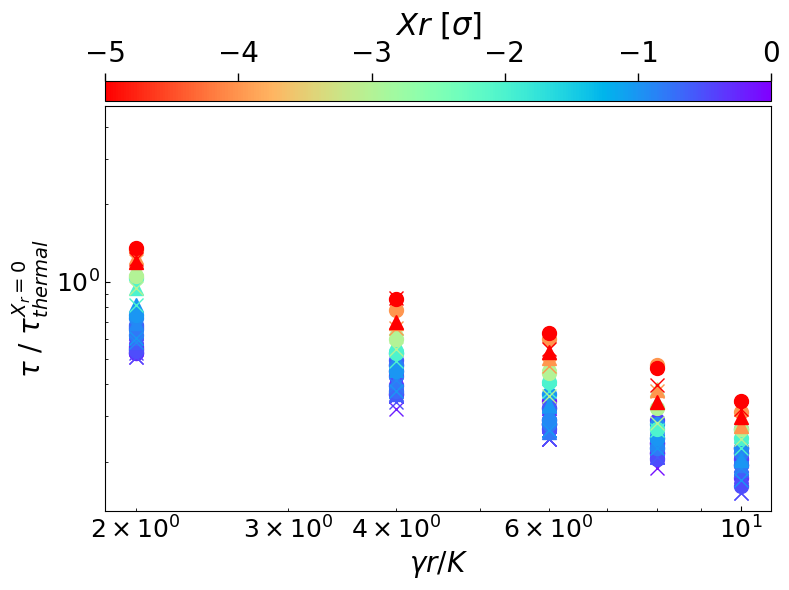

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='5%', pad=0.05)
slope_per_start = []
slope_per_start_2 = []
slope_per_start_10 = []
for i, (platue_index_per_r, platue_index_per_r_2, platue_index_per_r_10, c_start) in enumerate(zip(platue_index_per_r_per_start, platue_index_per_r_per_start_2, platue_index_per_r_per_start_10, colors_starting)):
    for i, s in enumerate(sherf_nums):
        ax.errorbar(sherf_nums[i], platue_index_per_r[i]/platue_index_per_r_per_start[0][0], linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
        ax.errorbar(sherf_nums_2[i], platue_index_per_r_2[i]/platue_index_per_r_per_start_2[0][0], linestyle='--', marker = '^', lw=3, ms=10, color=c_start)
        ax.errorbar(sherf_nums_10[i], platue_index_per_r_10[i]/platue_index_per_r_per_start_10[0][0], linestyle='--', marker = 'x', lw=3, ms=10, color=c_start)
    slope, intercept = np.polyfit(np.log(sherf_nums[1:]), np.log(platue_index_per_r[1:]/platue_index_per_r_per_start[0][0]), 1)
    slope_2, intercept_2 = np.polyfit(np.log(sherf_nums_2[1:]), np.log(platue_index_per_r_2[1:]/platue_index_per_r_per_start_2[0][0]), 1)
    slope_10, intercept_10 = np.polyfit(np.log(sherf_nums_10[1:]), np.log(platue_index_per_r_10[1:]/platue_index_per_r_per_start_10[0][0]), 1)
    slope_per_start.append(slope)
    slope_per_start_2.append(slope_2)
    slope_per_start_10.append(slope_10)
slope_per_start = np.array(slope_per_start)
slope_per_start_2 = np.array(slope_per_start_2)
slope_per_start_10 = np.array(slope_per_start_10)
print('Slope per start position:', slope_per_start)
print('Slope per start position for k_harm_2:', slope_per_start_2)
print('Slope per start position for k_harm_10:', slope_per_start_10)
start_position_handles = [plt.Line2D([0], [0], color=c, lw=3, label=f'Start Position {start_position/typical_length_scale:.1f}$\\sigma$') for c, start_position in zip(colors_starting, start_positions)]
#ax.legend(handles=start_position_handles, loc='best', fontsize=16)
cbar = fig.colorbar(cpick, cax=cax, orientation='horizontal',ticklocation='top')
cbar.ax.tick_params(labelsize=20, direction='out', length=6, width=1)
cbar.ax.set_xlabel('$Xr$ $[\\sigma]$', fontsize=22)
ax.set_xlabel('$\\gamma r/K$', fontsize=20)
ax.set_ylabel('$\\tau$ / $\\tau_{thermal}^{X_r=0}$', fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=18, direction='in')
fig.tight_layout()
saving_folder = 'Figures'
figname = 'relaxation vs S-number varying X_R.png'
path = os.path.join(saving_folder,figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=300)
plt.show()


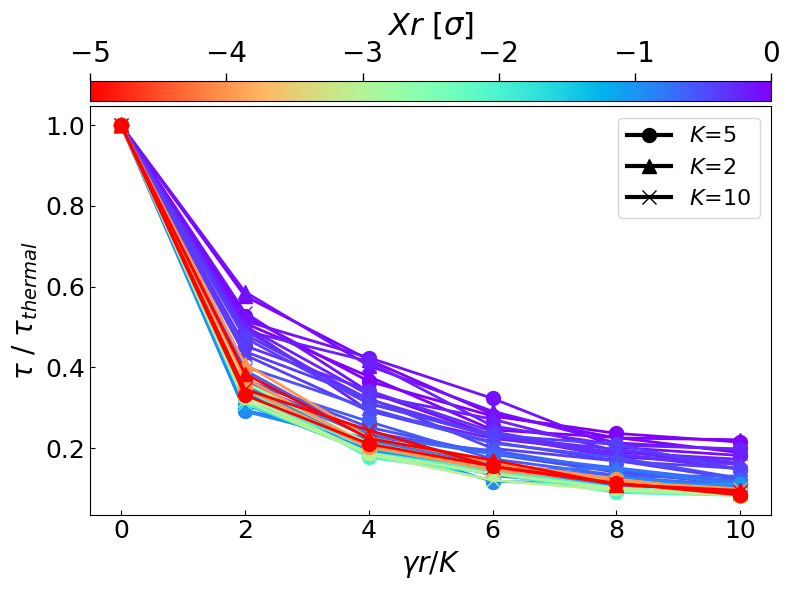

In [29]:
fig , ax = plt.subplots(figsize=(8, 6))
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='5%', pad=0.05)
positions_to_plot = [0, 0.1,0.2, 0.5, 3]
for i, (platue_index_per_r, platue_index_per_r_2, platue_index_per_r_10, c_start, n_start) in enumerate(zip(platue_index_per_r_per_start, platue_index_per_r_per_start_2, platue_index_per_r_per_start_10, colors_starting, normalized_start_positions)):
    #if abs(n_start) not in positions_to_plot:
        #continue
    ax.errorbar(sherf_nums, platue_index_per_r/platue_index_per_r[0], linestyle='-', marker = 'o', lw=2, ms=10, color=c_start)
    ax.errorbar(sherf_nums_2, platue_index_per_r_2/platue_index_per_r_2[0], linestyle='-', marker = '^', lw=2, ms=10, color=c_start)
    ax.errorbar(sherf_nums_10, platue_index_per_r_10/platue_index_per_r_10[0], linestyle='-', marker = 'x', lw=2, ms=10, color=c_start)
#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)
start_position_handles = [plt.Line2D([0], [0], color=c, lw=3, label=f'Start Position {start_position:.3f}$\\sigma$') for c, start_position in zip(colors_starting, normalized_start_positions)]
stiffness_handle_1 = [plt.Line2D([0], [0], color='black', lw=3, label=f'$K$={k_harm}', marker='o', ms=10)]
stiffness_handle_2 = [plt.Line2D([0], [0], color='black', lw=3, label=f'$K$={k_harm_2}', marker='^', ms=10)]
stiffness_handle_10 = [plt.Line2D([0], [0], color='black', lw=3, label=f'$K$={k_harm_10}', marker='x', ms=10)]
stiffness_handles = stiffness_handle_1 + stiffness_handle_2 + stiffness_handle_10
ax.legend(handles=stiffness_handles, loc='best', fontsize=16)
ax.set_xlabel('$\\gamma r/K$', fontsize=20)
ax.set_ylabel('$\\tau$ / $\\tau_{thermal}$', fontsize=20)
cbar = fig.colorbar(cpick, cax=cax, orientation='horizontal',ticklocation='top')
cbar.ax.tick_params(labelsize=20, direction='out', length=6, width=1)
cbar.ax.set_xlabel('$Xr$ $[\\sigma]$', fontsize=22)
ax.tick_params(axis='both', which='both', labelsize=18, direction='in')
fig.tight_layout()
plt.show()

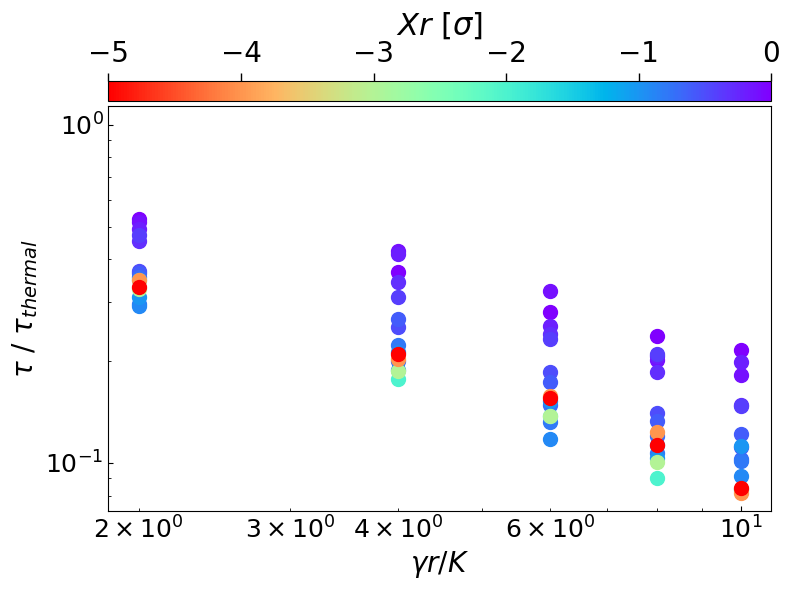

In [ ]:

fig, ax = plt.subplots(figsize=(8, 6))
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='5%', pad=0.05)
#slope_per_start = []
for i, (platue_index_per_r, platue_index_per_r_2, platue_index_per_r_10, c_start) in enumerate(zip(platue_index_per_r_per_start, platue_index_per_r_per_start_2, platue_index_per_r_per_start_10, colors_starting)):
    for i, s in enumerate(sherf_nums):
        ax.errorbar(sherf_nums[i], platue_index_per_r[i]/platue_index_per_r[0], linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
        #ax.errorbar(sherf_nums_2[i], platue_index_per_r_2[i]/platue_index_per_r_2[0], linestyle='--', marker = '^', lw=3, ms=10, color=c_start)
        #ax.errorbar(sherf_nums_10[i], platue_index_per_r_10[i]/platue_index_per_r_10[0], linestyle='--', marker = 'x', lw=3, ms=10, color=c_start)
'''    slope, intercept = np.polyfit(np.log(sherf_nums[1:]), np.log(platue_index_per_r[1:]/platue_index_per_r[0]), 1)
    slope_per_start.append(slope)
slope_per_start = np.array(slope_per_start)'''
start_position_handles = [plt.Line2D([0], [0], color=c, lw=3, label=f'Start Position {start_position/typical_length_scale:.1f}$\\sigma$') for c, start_position in zip(colors_starting, start_positions)]
#ax.legend(handles=start_position_handles, loc='best', fontsize=16)
cbar = fig.colorbar(cpick, cax=cax, orientation='horizontal',ticklocation='top')
cbar.ax.tick_params(labelsize=20, direction='out', length=6, width=1)
cbar.ax.set_xlabel('$Xr$ $[\\sigma]$', fontsize=22)
ax.set_xlabel('$\\gamma r/K$', fontsize=20)
ax.set_ylabel('$\\tau$ / $\\tau_{thermal}$', fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=18, direction='in')
fig.tight_layout()
saving_folder = 'Figures'
figname = 'relaxation vs S-number varying X_R.png'
path = os.path.join(saving_folder,figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=300)
plt.show()

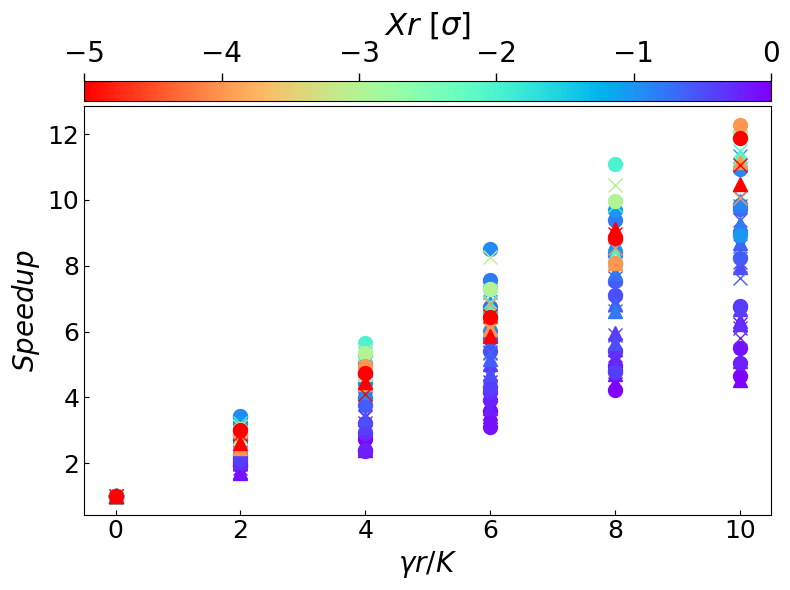

In [57]:

fig, ax = plt.subplots(figsize=(8, 6))
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='5%', pad=0.05)
slope_per_start_speedup = []
slope_per_start_speedup_2 = []
slope_per_start_speedup_10 = []
for i, (platue_index_per_r, platue_index_per_r_2, platue_index_per_r_10, c_start) in enumerate(zip(platue_index_per_r_per_start, platue_index_per_r_per_start_2, platue_index_per_r_per_start_10, colors_starting)):
    for i, s in enumerate(sherf_nums):
        ax.errorbar(sherf_nums[i], platue_index_per_r[0]/platue_index_per_r[i], linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
        ax.errorbar(sherf_nums_2[i], platue_index_per_r_2[0]/platue_index_per_r_2[i], linestyle='--', marker = '^', lw=3, ms=10, color=c_start)
        ax.errorbar(sherf_nums_10[i], platue_index_per_r_10[0]/platue_index_per_r_10[i], linestyle='--', marker = 'x', lw=3, ms=10, color=c_start)
    slope, intercept = np.polyfit(sherf_nums, platue_index_per_r[0]/platue_index_per_r, 1)
    slope_per_start_speedup.append(slope)
    slope_2, intercept_2 = np.polyfit(sherf_nums_2, platue_index_per_r_2[0]/platue_index_per_r_2, 1)
    slope_per_start_speedup_2.append(slope_2)
    slope_10, intercept_10 = np.polyfit(sherf_nums_10, platue_index_per_r_10[0]/platue_index_per_r_10, 1)
    slope_per_start_speedup_10.append(slope_10)
slope_per_start_speedup = np.array(slope_per_start_speedup)
slope_per_start_speedup_2 = np.array(slope_per_start_speedup_2)
slope_per_start_speedup_10 = np.array(slope_per_start_speedup_10)
start_position_handles = [plt.Line2D([0], [0], color=c, lw=3, label=f'Start Position {start_position:.1f}$\\sigma$') for c, start_position in zip(colors_starting, normalized_start_positions)]
ax.set_xlabel('$\\gamma r/K$', fontsize=20)
ax.set_ylabel('$Speedup$', fontsize=20)
cbar = fig.colorbar(cpick, cax=cax, orientation='horizontal',ticklocation='top')
cbar.ax.tick_params(labelsize=20, direction='out', length=6, width=1)
cbar.ax.set_xlabel('$Xr$ $[\\sigma]$', fontsize=22)
ax.tick_params(axis='both', which='both', labelsize=18, direction='in')
fig.tight_layout()
plt.show()


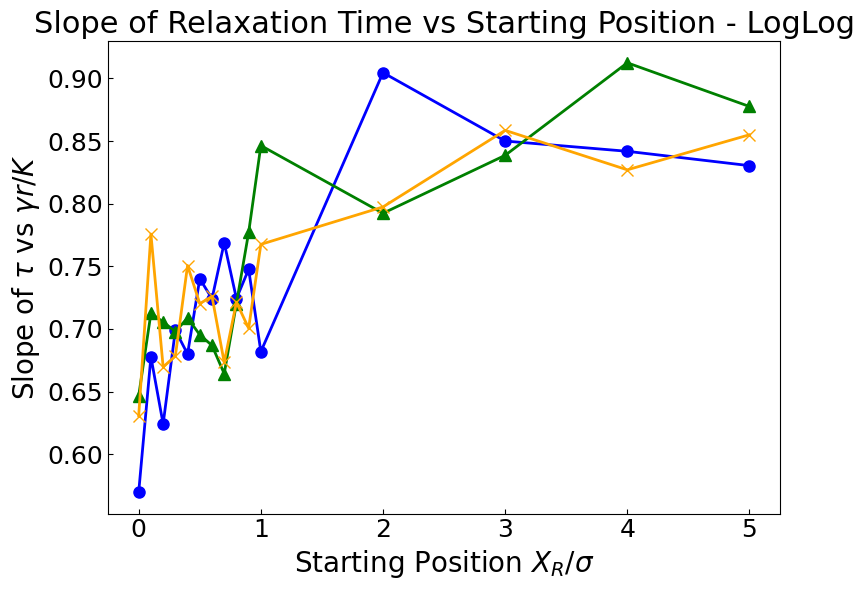

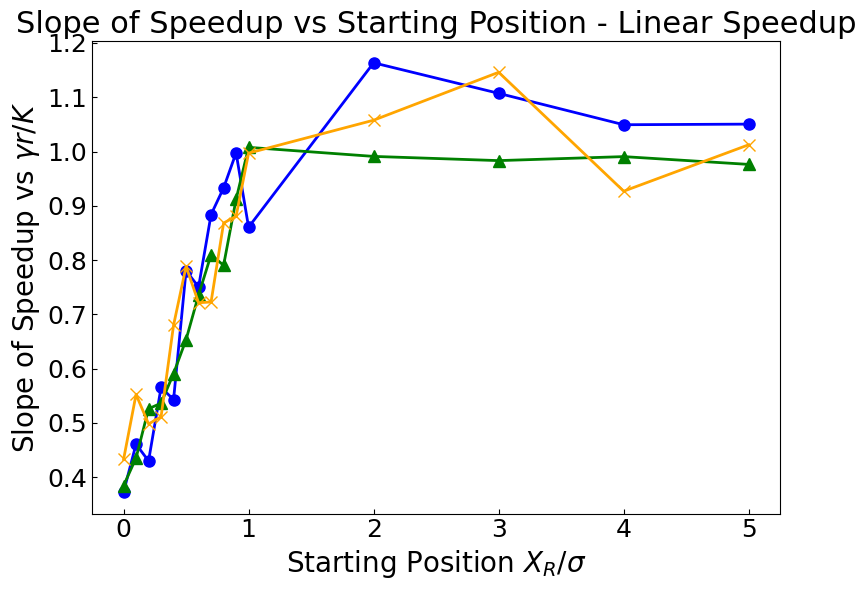

In [59]:


### plot slope vs starting position
plt.figure(figsize=(8, 6))
plt.plot(-start_positions/typical_length_scale, -slope_per_start, marker='o', linestyle='-', color='blue', markersize=8, linewidth=2)
plt.plot(-start_positions_2/typical_length_scale_2, -slope_per_start_2, marker='^', linestyle='-', color='green', markersize=8, linewidth=2)
plt.plot(-start_positions_10/typical_length_scale_10, -slope_per_start_10, marker='x', linestyle='-', color='orange', markersize=8, linewidth=2)
plt.xlabel('Starting Position $X_R/\\sigma$', fontsize=20)
plt.ylabel('Slope of $\\tau$ vs $\\gamma r/K$', fontsize=20)
plt.title('Slope of Relaxation Time vs Starting Position - LogLog', fontsize=22)
plt.tick_params(axis='both', which='both', labelsize=18, direction='in')
plt.tight_layout()
plt.show()

### plot slope vs starting position
plt.figure(figsize=(8, 6))
plt.plot(-start_positions/typical_length_scale, slope_per_start_speedup, marker='o', linestyle='-', color='blue', markersize=8, linewidth=2)
plt.plot(-start_positions_2/typical_length_scale_2, slope_per_start_speedup_2, marker='^', linestyle='-', color='green', markersize=8, linewidth=2)
plt.plot(-start_positions_10/typical_length_scale_10, slope_per_start_speedup_10, marker='x', linestyle='-', color='orange', markersize=8, linewidth=2)
plt.xlabel('Starting Position $X_R/\\sigma$', fontsize=20)  
plt.ylabel('Slope of Speedup vs $\\gamma r/K$', fontsize=20)
plt.title('Slope of Speedup vs Starting Position - Linear Speedup', fontsize=22)
plt.tick_params(axis='both', which='both', labelsize=18, direction='in')
plt.tight_layout()


#### moments analysis


In [ ]:
means_per_rate_per_start = []
vars_per_rate_per_start = []
for folder in subfolders:
    means = np.load(folder + '/mean_trajectories.npy')
    vars = np.load(folder + '/var_trajectories.npy')
    ss_means = np.abs(np.mean(means[:,steady_state:], axis=1))
    ss_vars = np.mean(vars[:,steady_state:], axis=1)
    means = ss_means
    vars = ss_vars
    means_per_rate_per_start.append(means)
    vars_per_rate_per_start.append(vars)
means_per_rate_per_start = np.array(means_per_rate_per_start)
vars_per_rate_per_start = np.array(vars_per_rate_per_start)

Folder: HarmonicPotentialTrajectories/R-.000,.020,.040,.060,.080,.100_X-0.000,0.447,0.894,1.342,1.789,2.236/X--0.000, Means: [4.3522500e-04 2.4113973e-05 2.3164733e-04 3.7004377e-04 4.7686356e-04
 1.5203752e-04], Vars: [0.19992404 0.09976597 0.06640293 0.04960264 0.03975442 0.03305205]
Folder: HarmonicPotentialTrajectories/R-.000,.020,.040,.060,.080,.100_X-0.000,0.447,0.894,1.342,1.789,2.236/X--0.447, Means: [2.2545537e-04 2.9794389e-01 3.5798758e-01 3.8374496e-01 3.9795944e-01
 4.0728483e-01], Vars: [0.19854677 0.11103528 0.07169971 0.05293307 0.04165296 0.03424513]
Folder: HarmonicPotentialTrajectories/R-.000,.020,.040,.060,.080,.100_X-0.000,0.447,0.894,1.342,1.789,2.236/X--0.894, Means: [5.3559383e-05 5.9562176e-01 7.1543777e-01 7.6727313e-01 7.9569435e-01
 8.1376058e-01], Vars: [0.20024495 0.14598234 0.08799012 0.06193765 0.04770934 0.03856239]
Folder: HarmonicPotentialTrajectories/R-.000,.020,.040,.060,.080,.100_X-0.000,0.447,0.894,1.342,1.789,2.236/X--1.342, Means: [0.00162534 0.

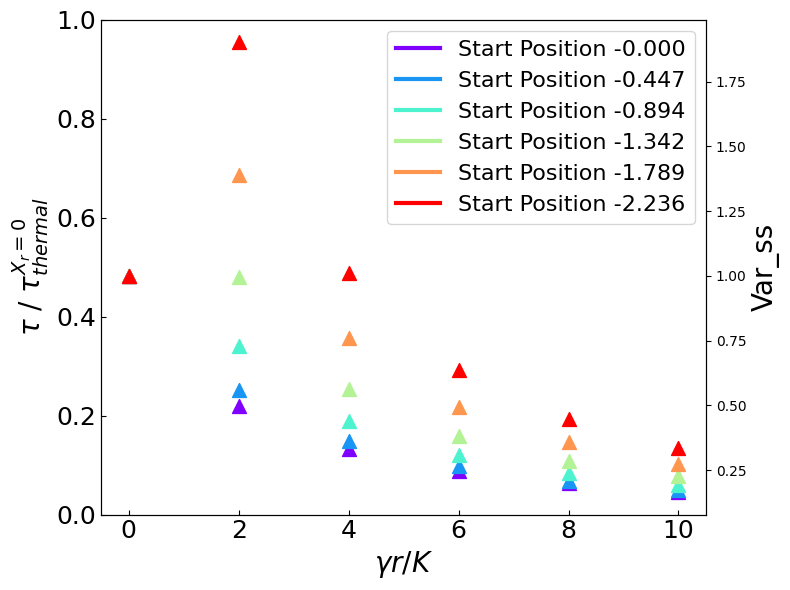

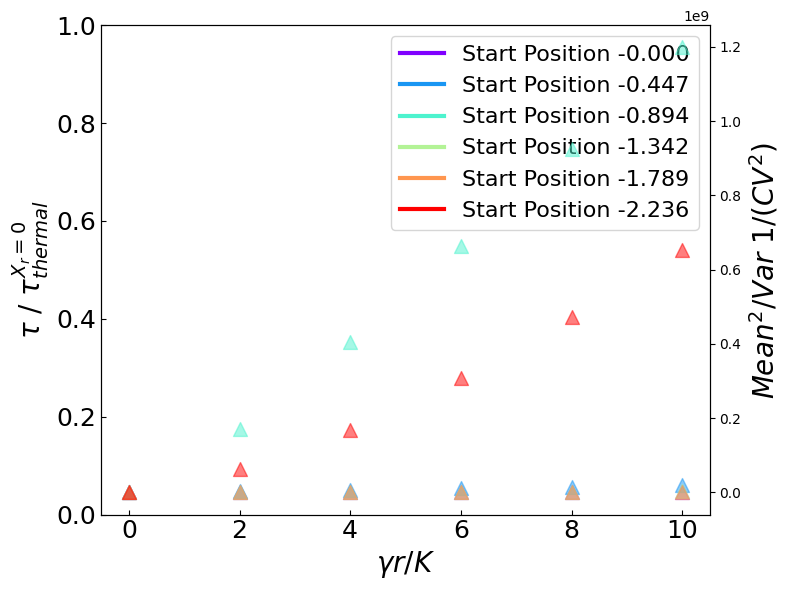

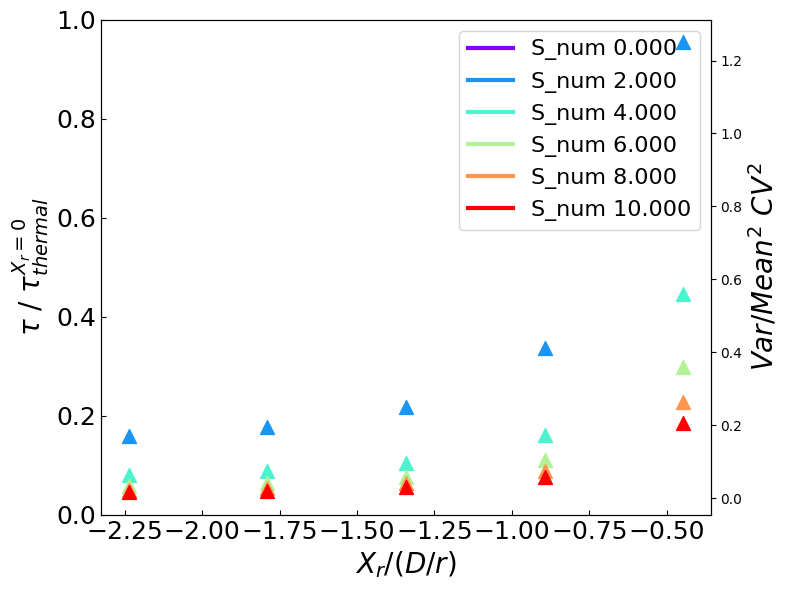

C:\Users\nir19\AppData\Local\Temp\ipykernel_10000\1798228499.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  n_start = start_pos/(D/r)


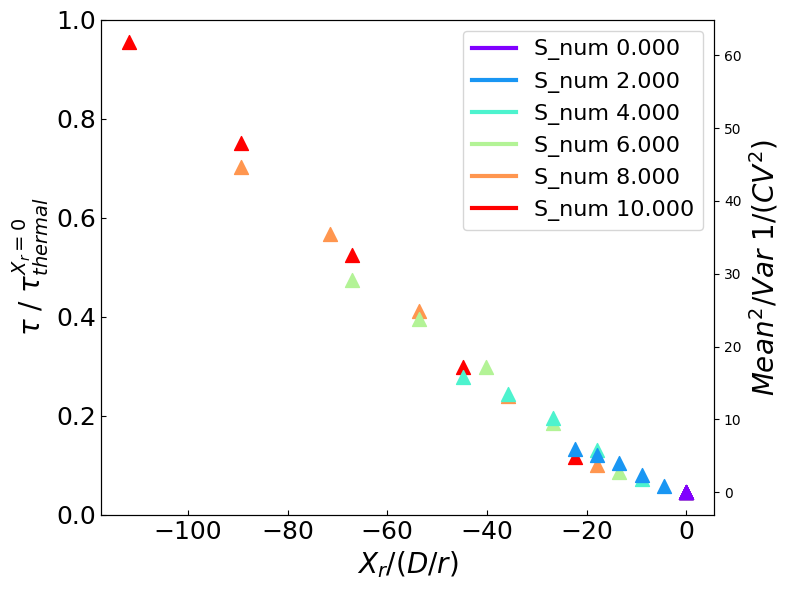

"\nfig, ax = plt.subplots(figsize=(8, 6))\n\nfor i, (platue_index_per_r, c_start, start_position) in enumerate(zip(platue_index_per_r_per_start, colors_starting, start_positions)):\n    for i, r in enumerate(resetting_rates):\n        if start_position == 0:\n            ax.errorbar(sherf_nums[i], platue_index_per_r[i]/platue_index_per_r[0], linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)\n        else:\n            ax.errorbar(1*sherf_nums[i], platue_index_per_r[i]/platue_index_per_r[0], linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)\n#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)\nstart_position_handles = [plt.Line2D([0], [0], color=c, lw=3, label=f'Start Position {start_position:.3f}') for c, start_position in zip(colors_starting, start_positions)]\nax.legend(handles=start_position_handles, loc='best', fontsize=16)\nax.set_xlabel('$\\gamma r/K$', fontsize=20)\nax.set_ylabel('$\\tau$ / $\\tau_{thermal}$', fon

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax2 = ax.twinx()

for i, (platue_index_per_r, mean_per_r, var_per_r, c_start, start_pos) in enumerate(zip(platue_index_per_r_per_start, means_per_rate_per_start, vars_per_rate_per_start, colors_starting, start_positions)):
    for i, r in enumerate(resetting_rates):
        #ax.errorbar(sherf_nums[i], platue_index_per_r[i]/platue_index_per_r_per_start[0][0], linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
        ax2.scatter(sherf_nums[i], var_per_r[i]/var_per_r[0], marker='^', color=c_start, s=100)
#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)
start_position_handles = [plt.Line2D([0], [0], color=c, lw=3, label=f'Start Position {start_position:.3f}') for c, start_position in zip(colors_starting, start_positions)]
ax.legend(handles=start_position_handles, loc='best', fontsize=16)
ax.set_xlabel('$\\gamma r/K$', fontsize=20)
ax.set_ylabel('$\\tau$ / $\\tau_{thermal}^{X_r=0}$', fontsize=20)
ax2.set_ylabel('Var_ss', fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=18, direction='in')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
ax2 = ax.twinx()

for i, (platue_index_per_r, mean_per_r, var_per_r, c_start, start_pos) in enumerate(zip(platue_index_per_r_per_start, means_per_rate_per_start, vars_per_rate_per_start, colors_starting, start_positions)):
    for i, r in enumerate(resetting_rates):
        #ax.errorbar(sherf_nums[i], platue_index_per_r[i]/platue_index_per_r_per_start[0][0], linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
        ax2.scatter(sherf_nums[i], (mean_per_r[i]**2)/var_per_r[i]/(mean_per_r[0]**2/var_per_r[0]), marker='^', color=c_start, s=100, alpha=0.5)
#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)
start_position_handles = [plt.Line2D([0], [0], color=c, lw=3, label=f'Start Position {start_position:.3f}') for c, start_position in zip(colors_starting, start_positions)]
ax.legend(handles=start_position_handles, loc='best', fontsize=16)
ax.set_xlabel('$\\gamma r/K$', fontsize=20)
ax.set_ylabel('$\\tau$ / $\\tau_{thermal}^{X_r=0}$', fontsize=20)
ax2.set_ylabel('$Mean^2/Var$ $1/(CV^2)$', fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=18, direction='in')
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(8, 6))
ax2 = ax.twinx()
colors_resetting = cm.rainbow(np.linspace(0, 1, len(resetting_rates)))
for i, (platue_index_per_r, mean_per_r, var_per_r, c_start, start_pos) in enumerate(zip(platue_index_per_r_per_start, means_per_rate_per_start, vars_per_rate_per_start, colors_starting, start_positions)):
    if i == 0:  
        continue
    for i, (r, c_resetting) in enumerate(zip(resetting_rates, colors_resetting)):
        #ax.errorbar(sherf_nums[i], platue_index_per_r[i]/platue_index_per_r_per_start[0][0], linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
        if r == 0:
            continue
        n_start = start_pos#/(D/r)
        ax2.scatter(n_start, var_per_r[i]/(mean_per_r[i]**2), marker='^', color=c_resetting, s=100)
#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)
start_position_handles = [plt.Line2D([0], [0], color=c, lw=3, label=f'S_num {sherf_n:.3f}') for c, sherf_n in zip(colors_resetting, sherf_nums)]
ax.legend(handles=start_position_handles, loc='best', fontsize=16)
ax.set_xlabel('$X_r/(D/r)$', fontsize=20)
ax.set_ylabel('$\\tau$ / $\\tau_{thermal}^{X_r=0}$', fontsize=20)
ax2.set_ylabel('$Var/Mean^2$ $CV^2$', fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=18, direction='in')
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(8, 6))
ax2 = ax.twinx()
colors_resetting = cm.rainbow(np.linspace(0, 1, len(resetting_rates)))
for i, (platue_index_per_r, mean_per_r, var_per_r, c_start, start_pos) in enumerate(zip(platue_index_per_r_per_start, means_per_rate_per_start, vars_per_rate_per_start, colors_starting, start_positions)):
    for i, (r, c_resetting) in enumerate(zip(resetting_rates, colors_resetting)):
        #ax.errorbar(sherf_nums[i], platue_index_per_r[i]/platue_index_per_r_per_start[0][0], linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
        n_start = start_pos/(D/r)
        ax2.scatter(n_start, (mean_per_r[i]**2)/var_per_r[i], marker='^', color=c_resetting, s=100)
#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)
start_position_handles = [plt.Line2D([0], [0], color=c, lw=3, label=f'S_num {sherf_n:.3f}') for c, sherf_n in zip(colors_resetting, sherf_nums)]
ax.legend(handles=start_position_handles, loc='best', fontsize=16)
ax.set_xlabel('$X_r/(D/r)$', fontsize=20)
ax.set_ylabel('$\\tau$ / $\\tau_{thermal}^{X_r=0}$', fontsize=20)
ax2.set_ylabel('$Mean^2/Var$ $1/(CV^2)$', fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=18, direction='in')
plt.tight_layout()
plt.show()

'''
fig, ax = plt.subplots(figsize=(8, 6))

for i, (platue_index_per_r, c_start, start_position) in enumerate(zip(platue_index_per_r_per_start, colors_starting, start_positions)):
    for i, r in enumerate(resetting_rates):
        if start_position == 0:
            ax.errorbar(sherf_nums[i], platue_index_per_r[i]/platue_index_per_r[0], linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
        else:
            ax.errorbar(1*sherf_nums[i], platue_index_per_r[i]/platue_index_per_r[0], linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)
start_position_handles = [plt.Line2D([0], [0], color=c, lw=3, label=f'Start Position {start_position:.3f}') for c, start_position in zip(colors_starting, start_positions)]
ax.legend(handles=start_position_handles, loc='best', fontsize=16)
ax.set_xlabel('$\\gamma r/K$', fontsize=20)
ax.set_ylabel('$\\tau$ / $\\tau_{thermal}$', fontsize=20)

ax.tick_params(axis='both', which='both', labelsize=18, direction='in')
fig.tight_layout()
saving_folder = 'Figures'
figname = 'relaxation vs S-number varying X_R.png'
path = os.path.join(saving_folder,figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=300)
plt.show()


fig, ax = plt.subplots(figsize=(8, 6))
ax2 = ax.twiny()

for i, (platue_index_per_r, c_start, start_position) in enumerate(zip(platue_index_per_r_per_start, colors_starting, start_positions)):
    for i, r in enumerate(resetting_rates):
        if start_position == 0:
            ax2.errorbar(sherf_nums[i], platue_index_per_r[i]/platue_index_per_r[0], linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
        else:
            ax.errorbar(2*sherf_nums[i], platue_index_per_r[i]/platue_index_per_r[0], linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)
start_position_handles = [plt.Line2D([0], [0], color=c, lw=3, label=f'Start Position {start_position:.3f}') for c, start_position in zip(colors_starting, start_positions)]
ax.legend(handles=start_position_handles, loc='best', fontsize=16)
ax.set_xlabel('$2 \\gamma r/K$', fontsize=20)
ax2.set_xlabel('$\\gamma r/K$', fontsize=20, color=colors_starting[0])
ax.set_ylabel('$\\tau$ / $\\tau_{thermal}$', fontsize=20)
ax2.set_xlim(ax.get_xlim())
plt.tick_params(axis='both', which='both', labelsize=18, direction='in')
plt.tight_layout()
saving_folder = 'Figures'
figname = 'relaxation vs S-number varying X_R - renormalized.png'
path = os.path.join(saving_folder,figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=300)
plt.show()
'''

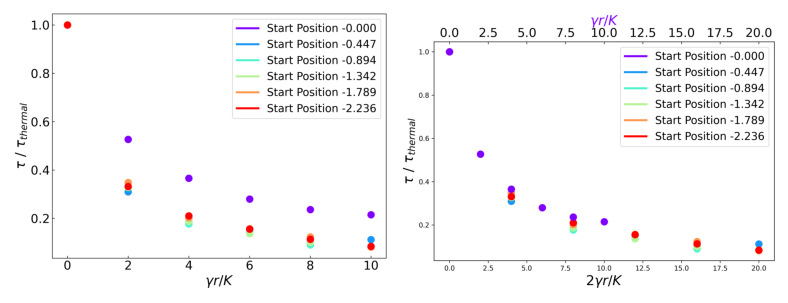

In [ ]:
### Arange figure ###
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.axes import Axes
from matplotlib import patches

# Directory containing PNG files
image_dir = os.path.join('Figures')

# Get list of PNG files
png_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

# Sort files if necessary
png_files.sort()

fig, axes = plt.subplot_mosaic("AB", figsize=(8,12), width_ratios=[1,1])

file_name = 'relaxation vs S-number varying X_R.png'
img_tau_by_k = mpimg.imread(os.path.join(image_dir, file_name))
axes['A'].imshow(img_tau_by_k)
axes['A'].axis('off')

file_name = 'relaxation vs S-number varying X_R - renormalized.png'
img_sherf_num = mpimg.imread(os.path.join(image_dir, file_name))
axes['B'].imshow(img_sherf_num)
axes['B'].axis('off')

fig.tight_layout()
fig.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.02)
fig.subplots_adjust(wspace=0.02, hspace=0.01)
filename = 'relaxation vs S-number varying X_R - joint.png'
plt.savefig(os.path.join('Figures', filename), bbox_inches='tight',format='png', dpi=500)
plt.show()



### Varying $X_r$ and S number - Updated

In [40]:
### Simulation Parameters ###

dt = 0.1
gamma = 500
kT = 1
steps = 10000
n_particles = 30000
batch_size = 10000
batches = int(n_particles/batch_size)
D=kT/gamma

### Harmonic Potential Parameters ###
k_harm = 5
force_args = [k_harm]
typical_relaxation_time = gamma/k_harm
typical_length_scale = np.sqrt(kT/k_harm)

### start positions ###

### relaxation vs X_R ###
### for log spacing ###
'''
start_position_ratios_small = np.linspace(0, 1, 6)
start_position_ratios_high = np.linspace(1, 3, 9)[1:]
start_position_ratios = np.concatenate((start_position_ratios_small, start_position_ratios_high))
'''
### for linear spacing ###
start_position_ratios_small = np.linspace(0, 2, 11)
start_position_ratios_high = np.linspace(2, 5, 4)[1:]
start_positions_ratios_relaxation_vs_xr = np.concatenate((start_position_ratios_small, start_position_ratios_high))
print('start_position_ratios:', start_positions_ratios_relaxation_vs_xr)
start_positions_relaxation_vs_xr = -start_positions_ratios_relaxation_vs_xr * typical_length_scale
start_positions_relaxation_vs_xr_str = [f'{pos:.3f}'[1:] for pos in start_positions_relaxation_vs_xr]
start_positions_relaxation_vs_xr_str = ','.join(start_positions_relaxation_vs_xr_str)

### relaxation vs S-number ###
start_position_ratios_relaxation_vs_Snum = np.array([0, 0.3, 1, 3])
start_positions_relaxation_vs_Snum = -start_position_ratios_relaxation_vs_Snum * typical_length_scale
start_positions_relaxation_vs_Snum_str = [f'{pos:.3f}'[1:] for pos in start_positions_relaxation_vs_Snum]
start_positions_relaxation_vs_Snum_str = ','.join(start_positions_relaxation_vs_Snum_str)

### resetting parameters ### 

### relaxation vs X_R ###
delta_fractions_relaxation_vs_xr = k_harm*np.array([0, 0.0005,0.002,0.01])/5
colors_relaxation_vs_xr = cm.rainbow(np.linspace(0, 1, len(delta_fractions_relaxation_vs_xr)))
resetting_rates_relaxation_vs_xr = delta_fractions_relaxation_vs_xr/dt
resetting_rates_relaxation_vs_xr_str = [f'{rate:.2f}'[1:] for rate in resetting_rates_relaxation_vs_xr]
resetting_rates_relaxation_vs_xr_str = ','.join(resetting_rates_relaxation_vs_xr_str)
sherf_nums_relaxation_vs_xr = gamma*resetting_rates_relaxation_vs_xr/k_harm
print('Sherf numbers relaxation vs X_R:', sherf_nums_relaxation_vs_xr)

### relaxation vs S-number ###
#log-spaced

delta_fractions_relaxation_vs_Snum_log_spaced = k_harm*np.logspace(np.log10(0.00002), np.log10(0.030), 15)/5
delta_fractions_to_add = np.array([0])
delta_fractions_relaxation_vs_Snum_log_spaced = np.concatenate((delta_fractions_to_add, delta_fractions_relaxation_vs_Snum_log_spaced))
resetting_rates_relaxation_vs_Snum_log_spaced = delta_fractions_relaxation_vs_Snum_log_spaced/dt
resetting_rates_relaxation_vs_Snum_log_spaced_str = [f'{rate:.2f}'[1:] for rate in resetting_rates_relaxation_vs_Snum_log_spaced]
resetting_rates_relaxation_vs_Snum_log_spaced_str = ','.join(resetting_rates_relaxation_vs_Snum_log_spaced_str)
sherf_nums_relaxation_vs_Snum_log_spaced = gamma*resetting_rates_relaxation_vs_Snum_log_spaced/k_harm
print('Sherf numbers relaxation vs S-number (log spaced):', sherf_nums_relaxation_vs_Snum_log_spaced)

#linear-spaced
S_ratios = np.concatenate((np.linspace(0, 2, 11), np.linspace(2, 5, 4)[1:]))
delta_fractions_relaxation_vs_Snum = (k_harm*S_ratios/gamma)*dt

colors_relaxation_vs_Snum = cm.rainbow(np.linspace(0, 1, len(start_positions_relaxation_vs_Snum)))
resetting_rates_relaxation_vs_Snum = delta_fractions_relaxation_vs_Snum/dt
resetting_rates_relaxation_vs_Snum_str = [f'{rate:.2f}'[1:] for rate in resetting_rates_relaxation_vs_Snum]
resetting_rates_relaxation_vs_Snum_str = ','.join(resetting_rates_relaxation_vs_Snum_str)
sherf_nums_relaxation_vs_Snum = gamma*resetting_rates_relaxation_vs_Snum/k_harm
print('Sherf numbers relaxation vs S-number:', sherf_nums_relaxation_vs_Snum)


### folder names and subfolders ###

### relaxation vs X_R ###
'''
folder_relaxation_vs_x_r = f'HarmonicPotentialTrajectories/R-{resetting_rates_relaxation_vs_xr_str}_X-{start_positions_relaxation_vs_xr_str}'
if k_harm != 5:
    folder_relaxation_vs_x_r += f'_k={k_harm}'
subfolders_relaxation_vs_x_r = [folder_relaxation_vs_x_r + f'/X-{start_position:.3f}' for start_position in start_positions_relaxation_vs_xr]
print('Folder -', folder_relaxation_vs_x_r)
print('Subfolders -', subfolders_relaxation_vs_x_r)
'''

### relaxation vs S-number ###
folder_relaxation_vs_s_num = f'HarmonicPotentialTrajectories/R-{resetting_rates_relaxation_vs_Snum_str}_X-{start_positions_relaxation_vs_Snum_str}'
folder_relaxation_vs_s_num_log_spaced = f'HarmonicPotentialTrajectories/R-{resetting_rates_relaxation_vs_Snum_log_spaced_str}_X-{start_positions_relaxation_vs_Snum_str}'
if k_harm != 5:
    folder_relaxation_vs_s_num += f'_k={k_harm}'
subfolders_relaxation_vs_s_num = [folder_relaxation_vs_s_num + f'/X-{start_position:.3f}' for start_position in start_positions_relaxation_vs_Snum]
subfolders_relaxation_vs_s_num_log_spaced = [folder_relaxation_vs_s_num_log_spaced + f'/X-{start_position:.3f}' for start_position in start_positions_relaxation_vs_Snum]

print('Folder (log spaced data) -', folder_relaxation_vs_s_num_log_spaced)
print('Subfolders (log spaced data) -', subfolders_relaxation_vs_s_num_log_spaced)
print('Folder -', folder_relaxation_vs_s_num)
print('Subfolders -', subfolders_relaxation_vs_s_num)

start_position_ratios: [0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  3.  4.  5. ]
Sherf numbers relaxation vs X_R: [ 0.   0.5  2.  10. ]
Sherf numbers relaxation vs S-number (log spaced): [0.00000000e+00 2.00000000e-02 3.37204729e-02 5.68535147e-02
 9.58563703e-02 1.61616107e-01 2.72488578e-01 4.59422186e-01
 7.74596669e-01 1.30598830e+00 2.20192716e+00 3.71250126e+00
 6.25936491e+00 1.05534372e+01 1.77933447e+01 3.00000000e+01]
Sherf numbers relaxation vs S-number: [0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  3.  4.  5. ]
Folder (log spaced data) - HarmonicPotentialTrajectories/R-.00,.00,.00,.00,.00,.00,.00,.00,.01,.01,.02,.04,.06,.11,.18,.30_X-0.000,0.134,0.447,1.342
Subfolders (log spaced data) - ['HarmonicPotentialTrajectories/R-.00,.00,.00,.00,.00,.00,.00,.00,.01,.01,.02,.04,.06,.11,.18,.30_X-0.000,0.134,0.447,1.342/X--0.000', 'HarmonicPotentialTrajectories/R-.00,.00,.00,.00,.00,.00,.00,.00,.01,.01,.02,.04,.06,.11,.18,.30_X-0.000,0.134,0.447,1.342/X--0.134', 'HarmonicPotentialTraje

In [41]:
### Load Data ###

### relaxation vs S-number ###
platue_index_per_r_per_start_T_vs_S = np.load(folder_relaxation_vs_s_num+'/platue_index_per_r_per_start.npy', allow_pickle=True)
KLDs_per_rate_per_start_T_vs_S = np.load(folder_relaxation_vs_s_num+'/KLDs_per_rate_per_start.npy', allow_pickle=True)
boltzmann_platue_index_per_start_T_vs_S = platue_index_per_r_per_start_T_vs_S[:,0]
print('Boltzmann plateau index per start T:', boltzmann_platue_index_per_start_T_vs_S.shape)
print('Platue index per rate per start T:', platue_index_per_r_per_start_T_vs_S.shape)

### relaxation vs S-number (log spaced data) ###
platue_index_per_r_per_start_T_vs_S_log_spaced = np.load(folder_relaxation_vs_s_num_log_spaced+'/platue_index_per_r_per_start.npy', allow_pickle=True)
KLDs_per_rate_per_start_T_vs_S_log_spaced = np.load(folder_relaxation_vs_s_num_log_spaced+'/KLDs_per_rate_per_start.npy', allow_pickle=True)
boltzmann_platue_index_per_start_T_vs_S_log_spaced = platue_index_per_r_per_start_T_vs_S_log_spaced[:,0]
print('Boltzmann plateau index per start T (log spaced):', boltzmann_platue_index_per_start_T_vs_S_log_spaced.shape)
print('Platue index per rate per start T (log spaced):', platue_index_per_r_per_start_T_vs_S_log_spaced.shape)

### relaxation vs X_R ###
'''
platue_index_per_r_per_start_T_vs_XR = np.load(folder_relaxation_vs_x_r+'/platue_index_per_r_per_start.npy', allow_pickle=True)
KLDs_per_rate_per_start_T_vs_XR = np.load(folder_relaxation_vs_x_r+'/KLDs_per_rate_per_start.npy', allow_pickle=True)
boltzmann_platue_index_per_start_T_vs_XR = platue_index_per_r_per_start_T_vs_XR[:,0]
'''

Boltzmann plateau index per start T: (4,)
Platue index per rate per start T: (4, 14)
Boltzmann plateau index per start T (log spaced): (4,)
Platue index per rate per start T (log spaced): (4, 16)


"\nplatue_index_per_r_per_start_T_vs_XR = np.load(folder_relaxation_vs_x_r+'/platue_index_per_r_per_start.npy', allow_pickle=True)\nKLDs_per_rate_per_start_T_vs_XR = np.load(folder_relaxation_vs_x_r+'/KLDs_per_rate_per_start.npy', allow_pickle=True)\nboltzmann_platue_index_per_start_T_vs_XR = platue_index_per_r_per_start_T_vs_XR[:,0]\n"

In [42]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make a user-defined colormap.
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",['orange','r',"r"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=min(abs(start_positions_relaxation_vs_Snum)),vmax=max(abs(start_positions_relaxation_vs_Snum)))
# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)

In [43]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make a user-defined colormap.
cm2 = mcol.LinearSegmentedColormap.from_list("MyCmapName",['b','purple','r','r',"r"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm2 = mcol.Normalize(vmin=min(abs(sherf_nums_relaxation_vs_xr)),vmax=max(abs(sherf_nums_relaxation_vs_xr)))
# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick2 = cm.ScalarMappable(norm=cnorm2,cmap=cm2)

#### Figure 

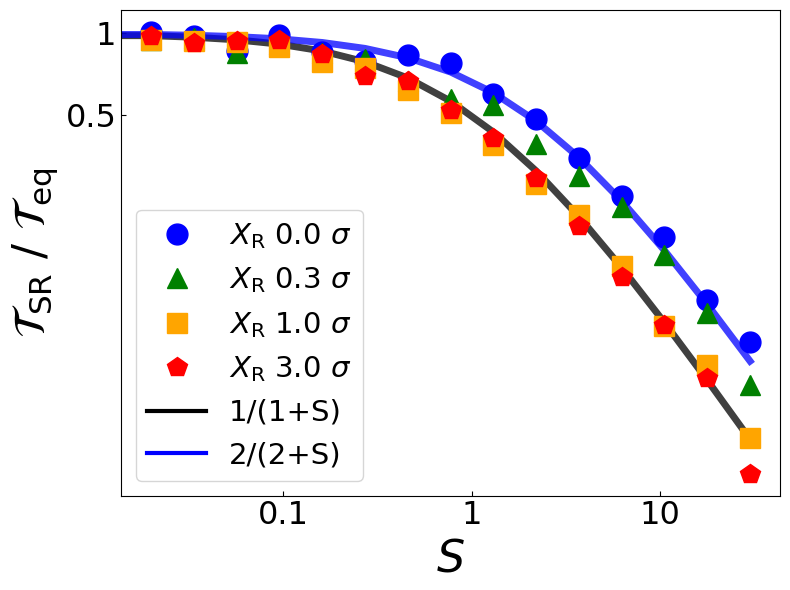

In [ ]:
### Plotting log spaced data ###
slope_1 = -1

func1 = lambda x: 1/(1+x)
func2 = lambda x: 2/(2+x)
symbols = ['o', '^', 's', 'p']
matplotlib_colors = ['blue', 'green', 'orange', 'red']

fig, ax = plt.subplots(figsize=(8, 6))

for i, (platue_index_per_r, c, start_position, boltz_platue, symbol) in enumerate(zip(platue_index_per_r_per_start_T_vs_S_log_spaced, matplotlib_colors, start_positions_relaxation_vs_Snum, boltzmann_platue_index_per_start_T_vs_S_log_spaced, symbols)):
    ax.errorbar(sherf_nums_relaxation_vs_Snum_log_spaced, platue_index_per_r/boltz_platue, linestyle='', marker=symbol, lw=3, ms=15, color=c)#, color=cpick.to_rgba(abs(start_position)))
    #plt.errorbar(sherf_num_patch[-1], final_platue/boltz_platue, linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)
#plt.plot(sherf_nums_relaxation_vs_Snum[-9:], sherf_nums_relaxation_vs_Snum[-9:]**slope_1, linestyle='--', lw=3, color='black', alpha=0.3, label=f'Slope {slope_1}')
ax.plot(sherf_nums_relaxation_vs_Snum_log_spaced, func1(sherf_nums_relaxation_vs_Snum_log_spaced), linestyle='-', lw=5, color='black', alpha=0.75, label='mean - 1/(1+x)')
ax.plot(sherf_nums_relaxation_vs_Snum_log_spaced, func2(sherf_nums_relaxation_vs_Snum_log_spaced), linestyle='-', lw=5, color='blue', alpha=0.75, label='variance - 2/(2+x)')
start_position_handles = [plt.Line2D([0], [0],linestyle='',color=c, marker=symbol,ms=15, label='$X_{\\rm R} $' + f' {abs(start_position)/typical_length_scale:.1f} $\\sigma$') for c, symbol, start_position in zip(matplotlib_colors, symbols, start_positions_relaxation_vs_Snum)]
theory_handles = [plt.Line2D([0], [0], color='black', lw=3, linestyle='-', label='1/(1+S)'),
                  plt.Line2D([0], [0], color='blue', lw=3, linestyle='-', label='2/(2+S)')]
handles = start_position_handles + theory_handles
ax.legend(handles=handles, loc='best', fontsize=21)
ax.set_xlabel('$S$', fontsize=32)
ax.set_ylabel('$\\mathcal{T}_{\\rm SR}$ / $\\mathcal{T}_{\\rm eq}$', fontsize=32)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=23, direction='in')
ax.set_xticks([0.1, 1, 10], [0.1, 1, 10])
ax.set_yticks([0.5, 1], [0.5, 1], minor=False)
ax.minorticks_off()
fig.tight_layout()
fig_name = 'Fig 5 - Relaxation vs S-number varying X_R.svg'
saving_folder = 'Figures'
path = os.path.join(saving_folder, fig_name)
plt.savefig(path, bbox_inches='tight', format='svg', dpi=300)
plt.show()

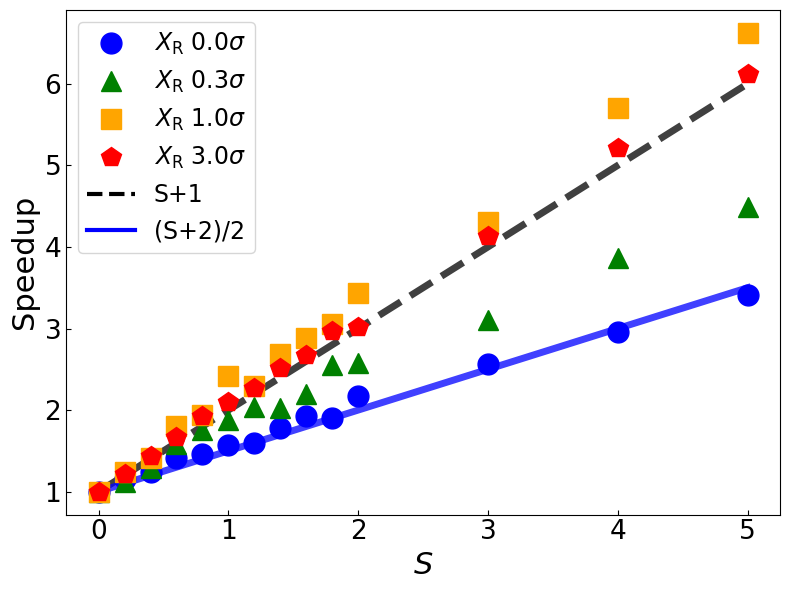

In [ ]:
### plotting linear spaced data ###
slope_1 = -1

func1 = lambda x: 1/(1+x)
func2 = lambda x: 2/(2+x)
symbols = ['o', '^', 's', 'p']
matplotlib_colors = ['blue', 'green', 'orange', 'red']

fig, ax = plt.subplots(figsize=(8, 6))

for i, (platue_index_per_r, c, start_position, boltz_platue, symbol) in enumerate(zip(platue_index_per_r_per_start_T_vs_S, matplotlib_colors, start_positions_relaxation_vs_Snum, boltzmann_platue_index_per_start_T_vs_S, symbols)):
    ax.errorbar(sherf_nums_relaxation_vs_Snum, boltz_platue/platue_index_per_r, linestyle='', marker=symbol, lw=3, ms=15, color=c)#, color=cpick.to_rgba(abs(start_position)))
    #plt.errorbar(sherf_num_patch[-1], final_platue/boltz_platue, linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)
#plt.plot(sherf_nums_relaxation_vs_Snum[-9:], sherf_nums_relaxation_vs_Snum[-9:]**slope_1, linestyle='--', lw=3, color='black', alpha=0.3, label=f'Slope {slope_1}')
ax.plot(sherf_nums_relaxation_vs_Snum, 1/func1(sherf_nums_relaxation_vs_Snum), linestyle='--', lw=5, color='black', alpha=0.75, label='mean - 1/(1+x)')
ax.plot(sherf_nums_relaxation_vs_Snum, 1/func2(sherf_nums_relaxation_vs_Snum), linestyle='-', lw=5, color='blue', alpha=0.75, label='variance - 2/(2+x)')
start_position_handles = [plt.Line2D([0], [0],linestyle='',color=c, marker=symbol,ms=15, label='$X_{\\rm R} $' + f' {abs(start_position)/typical_length_scale:.1f}$\\sigma$') for c, symbol, start_position in zip(matplotlib_colors, symbols, start_positions_relaxation_vs_Snum)]
theory_handles = [plt.Line2D([0], [0], color='black', lw=3, linestyle='--', label='S+1'),
                  plt.Line2D([0], [0], color='blue', lw=3, linestyle='-', label='(S+2)/2')]
handles = start_position_handles + theory_handles
ax.legend(handles=handles, loc='upper left', fontsize=17)
ax.set_xlabel('$S$', fontsize=22)
ax.set_ylabel('Speedup', fontsize=22)
#ax.set_ylabel('$\\mathcal{T}_{\\rm SR}$ / $\\mathcal{T}_{\\rm eq}$', fontsize=32)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=19, direction='in')
#ax.set_xticks([1, 3, 5], [1, 3, 5])
#ax.set_yticks([1, 2 ,6], [1,2,6])
fig.tight_layout()
fig_name = 'Fig 5 - Speedup by S - Vary Xr.svg'
saving_folder = 'Figures/OVERLEAF'
path = os.path.join(saving_folder, fig_name)
plt.savefig(path, bbox_inches='tight', format='svg', dpi=300)
plt.show()

#### inset

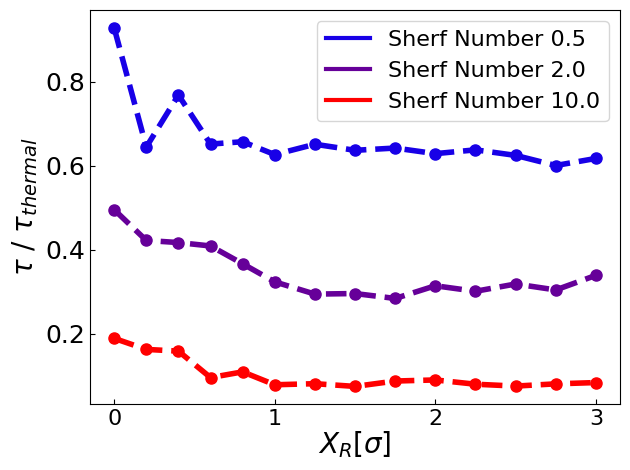

In [8]:
fig, ax = plt.subplots()

slope_1 = -1
slope_2 = -0.5

platue_index_per_r_per_start = platue_index_per_r_per_start_T_vs_XR.T
KLDs_per_rate_per_start = KLDs_per_rate_per_start_T_vs_XR.T
boltz_index_per_r_T_vs_Xr = platue_index_per_r_per_start[0]
normalized_platue_index_per_start_T_vs_XR = platue_index_per_r_per_start / boltz_index_per_r_T_vs_Xr
colors_sherf = cm.rainbow(np.linspace(0, 1, len(sherf_nums_relaxation_vs_xr)))

for i, (platue_index_per_start, c_sherf, s_number) in enumerate(zip(normalized_platue_index_per_start_T_vs_XR, colors_sherf, sherf_nums_relaxation_vs_xr)):
    if i == 0:
        continue
    normalized_starts = abs(start_positions_relaxation_vs_xr) / typical_length_scale
    plt.plot(normalized_starts, platue_index_per_start, linestyle='--', marker = 'o', lw=4, ms=8, color=cpick2.to_rgba(s_number))
    #plt.errorbar(sherf_num_patch[-1], final_platue/boltz_platue, linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)
sherf_num_handles = [plt.Line2D([0], [0], color=cpick2.to_rgba(s_number), lw=3, label=f'Sherf Number {s_number:.1f}') for c, s_number in zip(colors_sherf[1:], sherf_nums_relaxation_vs_xr[1:])]
plt.legend(handles=sherf_num_handles, loc='best', fontsize=16)
plt.xlabel('$X_R [\\sigma]$', fontsize=20, labelpad=0)
plt.ylabel('$\\tau$ / $\\tau_{thermal}$', fontsize=20)
#plt.xscale('log')
#plt.yscale('log')
plt.tick_params(axis='both', which='both', labelsize=18, direction='in')
plt.xticks(np.arange(0, 3.1, 1), fontsize=16)
plt.tight_layout()
plt.show()

#### Together

<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
C:\Users\nir19\AppData\Local\Temp\ipykernel_15476\2494200602.py:13: SyntaxWarning: invalid escape sequence '\s'
  start_position_handles = [plt.Line2D([0], [0], color=cpick.to_rgba(abs(start_position)), lw=3, label=f'$X_R$ {abs(start_position)/typical_length_scale:.1f} $\sigma$') for c, start_position in zip(colors_relaxation_vs_Snum, start_positions_relaxation_vs_Snum)]
C:\Users\nir19\AppData\Local\Temp\ipykernel_15476\2494200602.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 5.6)
C:\Users\nir19\AppData\Local\Temp\ipykernel_15476\2494200602.py:23: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 45)
C:\Users\nir19\AppData\Local\Temp\ipykernel_15476\2494200602.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorre

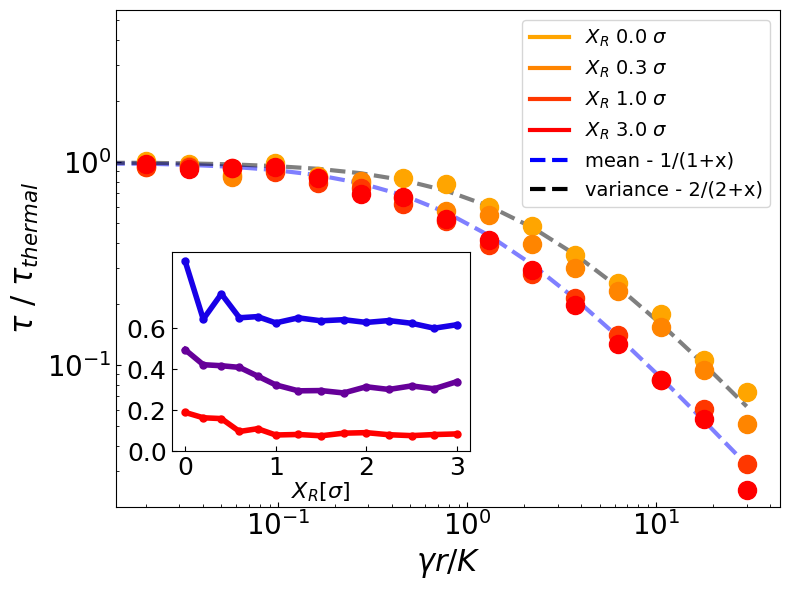

In [ ]:

slope_1 = -1

fig, ax = plt.subplots(figsize=(8, 6))

for i, (platue_index_per_r, c_start, start_position, boltz_platue) in enumerate(zip(platue_index_per_r_per_start_T_vs_S, colors_relaxation_vs_Snum, start_positions_relaxation_vs_Snum, boltzmann_platue_index_per_start_T_vs_S)):
    for i, r in enumerate(resetting_rates_relaxation_vs_Snum):
        ax.errorbar(sherf_nums_relaxation_vs_Snum[i], platue_index_per_r[i]/boltz_platue, linestyle='--', marker = 'o', lw=3, ms=13, color=cpick.to_rgba(abs(start_position)))
    #plt.errorbar(sherf_num_patch[-1], final_platue/boltz_platue, linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)
ax.plot(sherf_nums_relaxation_vs_Snum, func1(sherf_nums_relaxation_vs_Snum), linestyle='--', lw=3, color='blue', alpha=0.5, label='mean - 1/(1+x)')
ax.plot(sherf_nums_relaxation_vs_Snum, func2(sherf_nums_relaxation_vs_Snum), linestyle='--', lw=3, color='black', alpha=0.5, label='variance - 1/(2+x)')
#ax.plot(sherf_nums_relaxation_vs_Snum[-9:], sherf_nums_relaxation_vs_Snum[-9:]**slope_1, linestyle='--', lw=3, color='black', alpha=0.3, label=f'Slope {slope_1}')
start_position_handles = [plt.Line2D([0], [0], color=cpick.to_rgba(abs(start_position)), lw=3, label=f'$X_R$ {abs(start_position)/typical_length_scale:.1f} $\sigma$') for c, start_position in zip(colors_relaxation_vs_Snum, start_positions_relaxation_vs_Snum)]
theory_handles = [plt.Line2D([0], [0], color='blue', lw=3, linestyle='--', label='mean - 1/(1+x)'),
                  plt.Line2D([0], [0], color='black', lw=3, linestyle='--', label='variance - 2/(2+x)')]
handles = start_position_handles + theory_handles
ax.legend(handles=handles, loc='upper right', fontsize=14)
ax.set_xlabel('$\\gamma r/K$', fontsize=22)
ax.set_ylabel('$\\tau$ / $\\tau_{thermal}$', fontsize=22)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(0, 5.6)
ax.set_xlim(0, 45)
ax.tick_params(axis='both', which='both', labelsize=20, direction='in')

ax_inset = inset_axes(ax, width="45%", height="40%", loc='lower left', borderpad=4)
for i, (platue_index_per_start, c_sherf, s_number) in enumerate(zip(normalized_platue_index_per_start_T_vs_XR, colors_sherf, sherf_nums_relaxation_vs_xr)):
    if i == 0:
        continue
    normalized_starts = abs(start_positions_relaxation_vs_xr) / typical_length_scale
    ax_inset.plot(normalized_starts, platue_index_per_start, linestyle='-', marker = 'o', lw=4, ms=5, color=cpick2.to_rgba(s_number))
    #plt.errorbar(sherf_num_patch[-1], final_platue/boltz_platue, linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)
sherf_num_handles = [plt.Line2D([0], [0], color=c, lw=3, label=f'S {s_number:.1f}') for c, s_number in zip(colors_sherf[1:], sherf_nums_relaxation_vs_xr[1:])]
#ax_inset.legend(handles=sherf_num_handles, loc='best', fontsize=16)
ax_inset.set_xlabel('$X_R [\\sigma]$', fontsize=16, labelpad=0)
#ax_inset.set_ylabel('$\\tau$ / $\\tau_{thermal}$', fontsize=20)
#plt.xscale('log')
#plt.yscale('log')
ax_inset.tick_params(axis='both', which='both', labelsize=18, direction='in')
ax_inset.set_xticks(np.arange(0, 3.1, 1))
ax_inset.set_yticks(np.arange(0, 0.61, 0.2))

fig.tight_layout()
figname = 'Fig 7 - Relaxation vs X_R and S-number.png'
path = os.path.join('Figures', figname)
plt.savefig(path, bbox_inches='tight', format='png', dpi=300)
plt.show()

## Sherf Number for X=0 (FIG 2)

In [81]:

dt = 0.1
gamma = 500
r_varing_k = 0.002/dt
k_varing_r = 5
kT = 1

varing_k_folder = 'HarmonicPotentialTrajectories/K-1,3,5,7,9,12,14,16,18,20'
varying_k_folder_boltz = 'HarmonicPotentialTrajectories/K_r_0-1,3,5,7,9,12,14,16,18,20'
varing_r_folder = 'HarmonicPotentialTrajectories/R-.000,.020,.040,.060,.080,.100'
Ks_varing_k = np.load(varing_k_folder+'/k_harms.npy')
Rs = np.load(varing_r_folder+'/resetting_rates.npy')
mean_relaxation_times_varing_k_raw = np.load(varing_k_folder+'/mean_platue_indices_per_K.npy')
mean_relaxation_times_varing_k_boltz = np.load(varying_k_folder_boltz+'/mean_platue_indices_per_K_boltz.npy')
mean_relaxation_times_varing_r = np.load(varing_r_folder+'/mean_platue_indices_per_r.npy')
std_relaxation_times_varing_k_raw = np.load(varing_k_folder+'/std_platue_indices_per_K.npy')
std_relaxation_times_varing_k_boltz = np.load(varying_k_folder_boltz+'/std_platue_indices_per_K_boltz.npy')
std_relaxation_times_varing_r = np.load(varing_r_folder+'/std_platue_indices_per_r.npy')
mean_relaxation_times_varing_k = mean_relaxation_times_varing_k_raw/mean_relaxation_times_varing_k_boltz
mean_relaxation_times_varing_r = mean_relaxation_times_varing_r/mean_relaxation_times_varing_r[0]
std_relaxation_times_varing_k = std_relaxation_times_varing_k_raw/mean_relaxation_times_varing_k_boltz
std_relaxation_times_varing_r = std_relaxation_times_varing_r/mean_relaxation_times_varing_r[0]


sherf_nums_varing_k = gamma * r_varing_k / Ks_varing_k
sherf_nums_varing_r = gamma * Rs / k_varing_r
print('sherf_nums_varing_r',sherf_nums_varing_r)
print('sherf_nums_varing_k',sherf_nums_varing_k)


sherf_nums_varing_r [ 0.  2.  4.  6.  8. 10.]
sherf_nums_varing_k [10.          3.21428571  1.91489362  1.36363636  1.05882353  0.86538462
  0.73170732  0.63380282  0.55900621  0.5       ]


In [84]:
from numpy import mean, var
dt = 0.1
gamma = 500
kT = 1
delta_fractions = np.linspace(0, 0.01, 6)
resetting_rates_k_5 = delta_fractions/dt
resetting_rates_k_2 = (2/5)*delta_fractions/dt
resetting_rates_k_10 = (10/5)*delta_fractions/dt
resetting_rates_k_1 = (1/5)*delta_fractions/dt
resetting_rates_str_k_1 = [f'{rate:.3f}'[1:] for rate in resetting_rates_k_1]
resetting_rates_str_k_1 = ','.join(resetting_rates_str_k_1)
resetting_rates_str_k_5 = [f'{rate:.3f}'[1:] for rate in resetting_rates_k_5]
resetting_rates_str_k_5 = ','.join(resetting_rates_str_k_5)
resetting_rates_str_k_2 = [f'{rate:.3f}'[1:] for rate in resetting_rates_k_2]
resetting_rates_str_k_2 = ','.join(resetting_rates_str_k_2)
resetting_rates_str_k_10 = [f'{rate:.3f}'[1:] for rate in resetting_rates_k_10]
resetting_rates_str_k_10 = ','.join(resetting_rates_str_k_10)
varing_r_k_5_folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str_k_5}'
varing_r_k_2_folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str_k_2}_K-{2}'
varing_r_k_10_folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str_k_10}_K-{10}'
varing_r_k_1_folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str_k_1}_K-{1}'
Ks = [5,2,10,1]
mean_relaxation_times_varing_r_k_5_raw = np.load(varing_r_k_5_folder+'/mean_platue_indices_per_r.npy')
mean_relaxation_times_varing_r_k_2_raw = np.load(varing_r_k_2_folder+'/mean_platue_indices_per_r.npy')
mean_relaxation_times_varing_r_k_10_raw = np.load(varing_r_k_10_folder+'/mean_platue_indices_per_r.npy')
mean_relaxation_times_varing_r_k_1_raw = np.load(varing_r_k_1_folder+'/mean_platue_indices_per_r.npy')
std_relaxation_times_varing_r_k_5_raw = np.load(varing_r_k_5_folder+'/std_platue_indices_per_r.npy')
std_relaxation_times_varing_r_k_2_raw = np.load(varing_r_k_2_folder+'/std_platue_indices_per_r.npy')
std_relaxation_times_varing_r_k_10_raw = np.load(varing_r_k_10_folder+'/std_platue_indices_per_r.npy')
std_relaxation_times_varing_r_k_1_raw = np.load(varing_r_k_1_folder+'/std_platue_indices_per_r.npy')

mean_relaxation_times_varing_r_k_5 = mean_relaxation_times_varing_r_k_5_raw/mean_relaxation_times_varing_r_k_5_raw[0]
std_relaxation_times_varing_r_k_5 = std_relaxation_times_varing_r_k_5_raw/mean_relaxation_times_varing_r_k_5_raw[0]
mean_relaxation_times_varing_r_k_2 = mean_relaxation_times_varing_r_k_2_raw/mean_relaxation_times_varing_r_k_2_raw[0]
std_relaxation_times_varing_r_k_2 = std_relaxation_times_varing_r_k_2_raw/mean_relaxation_times_varing_r_k_2_raw[0]
mean_relaxation_times_varing_r_k_10 = mean_relaxation_times_varing_r_k_10_raw/mean_relaxation_times_varing_r_k_10_raw[0]
std_relaxation_times_varing_r_k_10 = std_relaxation_times_varing_r_k_10_raw/mean_relaxation_times_varing_r_k_10_raw[0]
mean_relaxation_times_varing_r_k_1 = mean_relaxation_times_varing_r_k_1_raw/mean_relaxation_times_varing_r_k_1_raw[0]
std_relaxation_times_varing_r_k_1 = std_relaxation_times_varing_r_k_1_raw/mean_relaxation_times_varing_r_k_1_raw[0]

sherf_nums_k_5 = gamma * resetting_rates_k_5 / Ks[0]
sherf_nums_k_2 = gamma * resetting_rates_k_2 / Ks[1]
sherf_nums_k_10 = gamma * resetting_rates_k_10 / Ks[2]
sherf_nums_k_1 = gamma * resetting_rates_k_1 / Ks[3]
print('sherf_nums_k_5',sherf_nums_k_5)
print('sherf_nums_k_2',sherf_nums_k_2)
print('sherf_nums_k_10',sherf_nums_k_10)   
print('sherf_nums_k_1',sherf_nums_k_1)

sherf_nums_k_5 [ 0.  2.  4.  6.  8. 10.]
sherf_nums_k_2 [ 0.  2.  4.  6.  8. 10.]
sherf_nums_k_10 [ 0.  2.  4.  6.  8. 10.]
sherf_nums_k_1 [ 0.  2.  4.  6.  8. 10.]


In [86]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make a user-defined colormap.
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b",'purple',"r"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=min(resetting_rates_k_5),vmax=max(resetting_rates_k_5))

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)

color_resetting = cpick.to_rgba(resetting_rates_k_5[3])


resetting rate: 1.1921718583662573


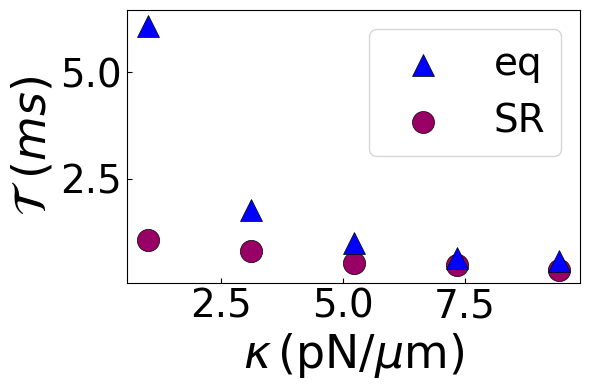

In [88]:
real_time = convert_arbitrary_time_to_seconds(gamma)
real_time_ms = real_time * 1e3  # convert to ms
resetting_real_time = r_varing_k / real_time_ms
print('resetting rate:', resetting_real_time)
fig, ax  = plt.subplots(figsize=(6, 4))
for i, k in enumerate(Ks_varing_k):
    if k>11:
        break
    tau_resetting = mean_relaxation_times_varing_k_raw[i]*real_time_ms # convert to ms
    tau_boltz = mean_relaxation_times_varing_k_boltz[i]*real_time_ms # convert to ms
    std_resetting = np.sqrt(1/10)*std_relaxation_times_varing_k_raw[i]*real_time_ms # convert to ms
    std_boltz = np.sqrt(1/10)*std_relaxation_times_varing_k_boltz[i]*real_time_ms # convert to ms
    ax.errorbar(Ks_varing_k[i], tau_resetting, yerr=std_resetting, linestyle='--', marker = 'o', lw=4, ms=16, color=color_resetting, markeredgecolor='black', markeredgewidth=0.5)
    ax.errorbar(Ks_varing_k[i], tau_boltz, yerr=std_boltz, linestyle='--', marker = '^', lw=4, ms=16, color='b', markeredgecolor='black', markeredgewidth=0.5)
ax.set_xlabel('$\\kappa \\, \\mathrm{(pN/}\\mu\\mathrm{m)}$', fontsize=33)
ax.set_ylabel('$\\mathcal{T}$ $(ms)$', fontsize=33)
ax.tick_params(axis='both', which='both', labelsize=28, direction='in')
legned_handels = []
boltz_handle = plt.scatter([],[], marker='^', color='blue', label='eq', s =250, edgecolor='black', linewidth=0.5)
resetting_handle = plt.scatter([],[], marker='o', color=color_resetting, label='SR', s=250, edgecolor='black', linewidth=0.5)
legned_handels.append(boltz_handle)
legned_handels.append(resetting_handle)
ax.legend(handles=legned_handels, loc='upper right', fontsize=28)
#plt.xscale('log')
#plt.yscale('log')
fig.tight_layout()
figname = 'b - Relaxation by stiffness - Harmonic - normalized.png'
path = os.path.join('Figures/Figure2',figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=500)
figname = 'b - Relaxation by stiffness - Harmonic - normalized.svg'
path = os.path.join('Figures/Figure2',figname)
plt.savefig(path, bbox_inches='tight',format='svg', dpi=300)
plt.show()

rate which halves relaxation time: 0.016 #
rate which halves relaxation time: 8.0 omega_0
rate which halves relaxation time: 0.9537374866930058 ms^-1


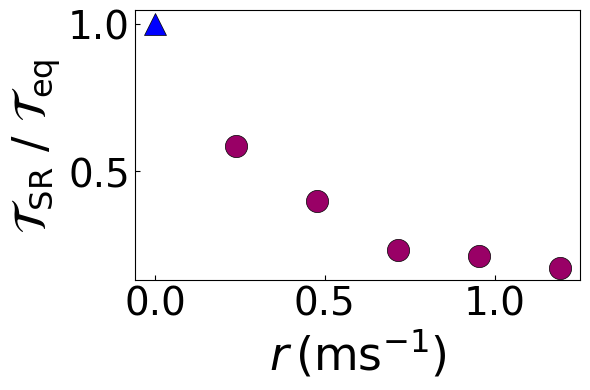

In [89]:
omega_0 = Ks[3]/gamma
print('rate which halves relaxation time:', resetting_rates_k_1[4], '#')
print('rate which halves relaxation time:', resetting_rates_k_1[4]/omega_0, 'omega_0')
print('rate which halves relaxation time:', resetting_rates_k_1[4]/real_time_ms, 'ms^-1')

fig, ax = plt.subplots(figsize=(6, 4))
for i, r in enumerate(resetting_rates_k_1):
    if i == 0:
        color = 'Blue'
        marker = '^'
    else:
        color = color_resetting
        marker = 'o'
    yerr = np.sqrt(1/10)*np.sqrt((std_relaxation_times_varing_r_k_1_raw[i]/mean_relaxation_times_varing_r_k_1_raw[0])**2 + ((mean_relaxation_times_varing_r_k_1_raw[i]*std_relaxation_times_varing_r_k_1_raw[0])/(mean_relaxation_times_varing_r_k_1_raw[0]**2))**2)
    ax.errorbar(resetting_rates_k_1[i]/real_time_ms, mean_relaxation_times_varing_r_k_1_raw[i]/mean_relaxation_times_varing_r_k_1_raw[0], yerr=yerr, linestyle='--', marker = marker, lw=4, ms=16, color=color, markeredgecolor='black', markeredgewidth=0.5)
ax.set_xlabel('$r \\, \\mathrm{(ms^{-1})}$', fontsize=33)
ax.set_ylabel('$\\mathcal{T}_{\\rm SR}$ / $\\mathcal{T}_{\\rm eq}$', fontsize=33)
ax.tick_params(axis='both', which='both', labelsize=28, direction='in')
fig.tight_layout()
figname = 'c - Relaxation by resetting rate - Harmonic.png'
path = os.path.join('Figures/Figure2',figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=300)
figname = 'c - Relaxation by resetting rate - Harmonic.svg'
path = os.path.join('Figures/Figure2',figname)
plt.savefig(path, bbox_inches='tight',format='svg', dpi=300)
plt.show()

omega_0: 0.002
omega_0 in ms^-1: 0.11921718583662573
rate which halves relaxation time: 0.016 #
rate which halves relaxation time: 8.0 omega_0
rate which halves relaxation time: 0.9537374866930058 ms^-1
slope: 4.168567118283668


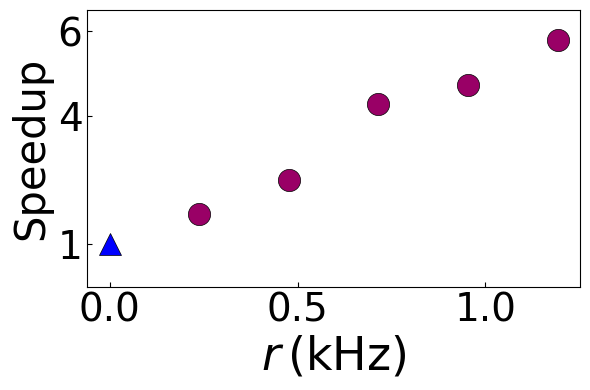

In [90]:
### As speed up:

def teq_tsr(r, omega_0):
    return r/(2*omega_0) + 1

omega_0 = Ks[3]/gamma
print('omega_0:', omega_0)
omega_0_ms = omega_0 / real_time_ms  # convert to ms^-1
print('omega_0 in ms^-1:', omega_0_ms)
print('rate which halves relaxation time:', resetting_rates_k_1[4], '#')
print('rate which halves relaxation time:', resetting_rates_k_1[4]/omega_0, 'omega_0')
print('rate which halves relaxation time:', resetting_rates_k_1[4]/real_time_ms, 'ms^-1')

fig, ax = plt.subplots(figsize=(6, 4))
for i, r in enumerate(resetting_rates_k_1):
    if i == 0:
        color = 'Blue'
        marker = '^'
    else:
        color = color_resetting
        marker = 'o'
    yerr = np.sqrt(1/1)*np.sqrt((std_relaxation_times_varing_r_k_1_raw[0]/mean_relaxation_times_varing_r_k_1_raw[i])**2 + ((mean_relaxation_times_varing_r_k_1_raw[0]*std_relaxation_times_varing_r_k_1_raw[i])/(mean_relaxation_times_varing_r_k_5_raw[i]**2))**2)
    ax.errorbar(resetting_rates_k_1[i]/real_time_ms, mean_relaxation_times_varing_r_k_1_raw[0]/mean_relaxation_times_varing_r_k_1_raw[i], yerr=yerr, linestyle='--', marker = marker, lw=4, ms=16, color=color, markeredgecolor='black', markeredgewidth=0.5)
slope = np.polyfit(resetting_rates_k_1/real_time_ms, mean_relaxation_times_varing_r_k_1_raw[0]/mean_relaxation_times_varing_r_k_1_raw, 1)[0]
#ax.plot(resetting_rates_k_5/real_time_ms, teq_tsr(resetting_rates_k_5/real_time_ms, omega_0_ms), linestyle='-', lw=5, color='black', alpha=0.75)
print('slope:', slope)
ax.set_xlabel('$r \\, \\mathrm{(kHz)}$', fontsize=33)
#ax.set_ylabel('$\\mathcal{T}_{\\rm eq}$ / $\\mathcal{T}_{\\rm SR}$', fontsize=33)
ax.set_ylabel('Speedup', fontsize=30)
ax.set_yticks([1, 4,6], [1,4,6])
ax.set_ylim(0, 6.5)
ax.tick_params(axis='both', which='both', labelsize=28, direction='in')
fig.tight_layout()
figname = 'c - Relaxation by resetting rate - Harmonic - SPEEDUP.png'
path = os.path.join('Figures/Figure2',figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=300)
figname = 'c - Relaxation by resetting rate - Harmonic - SPEEDUP.svg'
path = os.path.join('Figures/Figure2',figname)
plt.savefig(path, bbox_inches='tight',format='svg', dpi=300)
plt.show()

In [91]:
### concatenate the data for plotting ###
relxation_times = np.concatenate((mean_relaxation_times_varing_r_k_5, mean_relaxation_times_varing_r_k_1, mean_relaxation_times_varing_r_k_10))
std_relaxation_times = np.concatenate((std_relaxation_times_varing_r_k_5, std_relaxation_times_varing_r_k_1, std_relaxation_times_varing_r_k_10))
sherf_nums = np.concatenate((sherf_nums_k_5, sherf_nums_k_1, sherf_nums_k_10))

xy = zip(sherf_nums, relxation_times)
xy = sorted(xy, key=lambda x: x[0])  # Sort by the\
xy = np.array(xy)# Transpose to get x and y coordinates
print(xy[:,0])
### fit to 2/2+x ###
from scipy.optimize import curve_fit
def relative_characteristic_relaxation(x, a, b):
    return a / (b + x) 

popt, pcov = curve_fit(relative_characteristic_relaxation, xy[:,0], xy[:,1], p0=[2, 2])
fitted_relaxation_times = relative_characteristic_relaxation(xy[:,0], *popt)
a, b = popt
print(f'Fitted parameters: a={a:.3f}, b={b:.3f}')

[ 0.  0.  0.  2.  2.  2.  4.  4.  4.  6.  6.  6.  8.  8.  8. 10. 10. 10.]
Fitted parameters: a=2.215, b=2.211


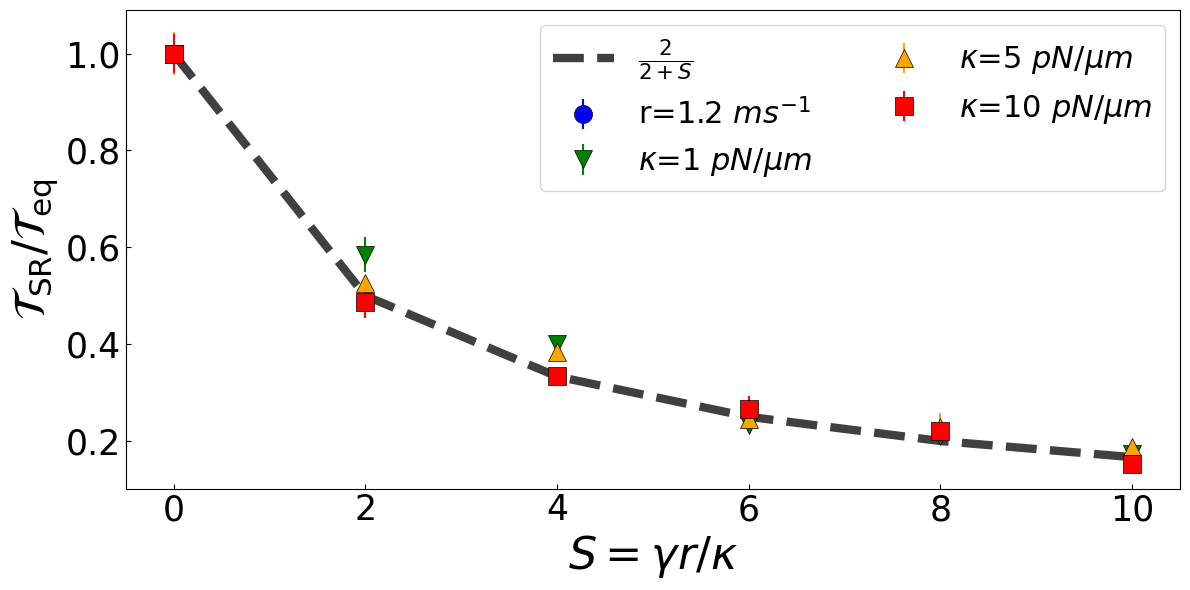

In [92]:
#### plot relaxation times as function of sherf numbers

plt.figure(figsize=(12, 6))
label_boltz = 'Thermal - $\\frac{\\gamma r}{K}$='+f'{0}'
label_varing_k = 'varying K'
plt.errorbar(sherf_nums_varing_k[:-10], mean_relaxation_times_varing_k[:-10], yerr=std_relaxation_times_varing_k[:-10], label=f'r={r_varing_k/real_time_ms:.1f} '+'$ ms^{-1}$', color='blue', marker='o', markersize=13, linestyle='',markeredgecolor='black', markeredgewidth=0.5)
plt.errorbar(sherf_nums_k_1, mean_relaxation_times_varing_r_k_1, yerr=std_relaxation_times_varing_r_k_1, label=f'$\\kappa$={Ks[3]} $pN/\\mu m$', color='green', marker='v', markersize=13, linestyle='',markeredgecolor='black', markeredgewidth=0.5)
plt.errorbar(sherf_nums_k_5, mean_relaxation_times_varing_r_k_5, yerr=std_relaxation_times_varing_r_k_5, label=f'$\\kappa$={Ks[0]} $pN/\\mu m$', color='orange', marker='^', markersize=13, linestyle='',markeredgecolor='black', markeredgewidth=0.5)
plt.errorbar(sherf_nums_k_10, mean_relaxation_times_varing_r_k_10, yerr=std_relaxation_times_varing_r_k_10, label=f'$\\kappa$={Ks[2]} $pN/\\mu m$', color='red', marker='s', markersize=13, linestyle='',markeredgecolor='black', markeredgewidth=0.5)
plt.plot(xy[:,0], relative_characteristic_relaxation(xy[:,0],2,2), linestyle='--', color='black', linewidth=6, label='$\\frac{2}{2+S}$', alpha=0.75)
plt.xlabel('$S=\\gamma r/ \\kappa$',fontsize=32)
plt.ylabel('$\\mathcal{T}_{\\rm SR}/\\mathcal{T}_{\\rm eq}$', fontsize=32)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.legend(fontsize= 22, ncols=2)
plt.tick_params(axis='both', which='both', labelsize=25, direction='in')
plt.tight_layout()
figname = 'SherfNumber all curves.png'
path = os.path.join('Figures/Figure2',figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=300)
figname = 'SherfNumber all curves.svg'
path = os.path.join('Figures/Figure2',figname)
#plt.savefig(path, bbox_inches='tight',format='svg', dpi=300)
plt.show()

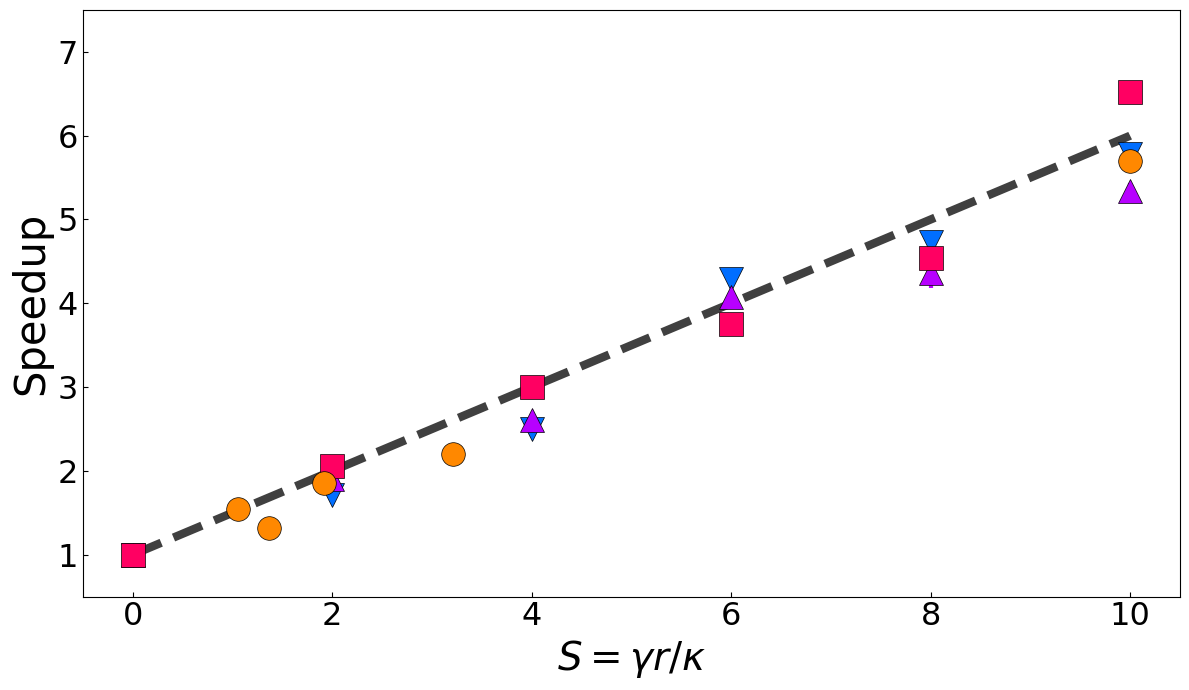

In [93]:
#### plot relaxation times as function of sherf numbers as SPEEDUP

plt.figure(figsize=(12, 7))
label_boltz = 'Thermal - $\\frac{\\gamma r}{K}$='+f'{0}'
label_varing_k = 'varying K'
varying_k_color = "#FF8800"
k_1_color = "#006EFF"
k_5_color = "#B700FF"
k_10_color = "#FF0062"
yerr_k_1 = [np.sqrt(1/10)*np.sqrt((std_relaxation_times_varing_r_k_1[0]/mean_relaxation_times_varing_r_k_1[i])**2 + ((mean_relaxation_times_varing_r_k_1[0]*std_relaxation_times_varing_r_k_1[i])/(mean_relaxation_times_varing_r_k_1[i]**2))**2) for i in range(len(mean_relaxation_times_varing_r_k_1_raw))]
yerr_k_5 = [np.sqrt(1/10)*np.sqrt((std_relaxation_times_varing_r_k_5[0]/mean_relaxation_times_varing_r_k_5[i])**2 + ((mean_relaxation_times_varing_r_k_5[0]*std_relaxation_times_varing_r_k_5[i])/(mean_relaxation_times_varing_r_k_5[i]**2))**2) for i in range(len(mean_relaxation_times_varing_r_k_5_raw))]
yerr_k_10 = [np.sqrt(1/10)*np.sqrt((std_relaxation_times_varing_r_k_10[0]/mean_relaxation_times_varing_r_k_10[i])**2 + ((mean_relaxation_times_varing_r_k_10[0]*std_relaxation_times_varing_r_k_10[i])/(mean_relaxation_times_varing_r_k_10[i]**2))**2) for i in range(len(mean_relaxation_times_varing_r_k_10_raw))]
yerr_varying_k = [np.sqrt(1/10)*np.sqrt((std_relaxation_times_varing_k_raw[0]/mean_relaxation_times_varing_k_raw[i])**2 + ((mean_relaxation_times_varing_k_raw[0]*std_relaxation_times_varing_k_raw[i])/(mean_relaxation_times_varing_k_raw[i]**2))**2) for i in range(len(mean_relaxation_times_varing_k))]
plt.errorbar(sherf_nums_k_1, 1/mean_relaxation_times_varing_r_k_1, yerr=yerr_k_1, label=f'$\\kappa={Ks[3]}\\,$'+ '$\\mathrm{pN/}\\mu\\mathrm{m}$', color=k_1_color, marker='v', markersize=17, linestyle='',markeredgecolor='black', markeredgewidth=0.5, linewidth=3)
plt.errorbar(sherf_nums_k_5, 1/mean_relaxation_times_varing_r_k_5, yerr=yerr_k_5, label=f'$\\kappa$={Ks[0]} $pN/\\mu m$', color=k_5_color, marker='^', markersize=17, linestyle='',markeredgecolor='black', markeredgewidth=0.5, linewidth=3)
plt.errorbar(sherf_nums_k_10, 1/mean_relaxation_times_varing_r_k_10, yerr=yerr_k_10, label=f'$\\kappa$={Ks[2]} $pN/\\mu m$', color=k_10_color, marker='s', markersize=17, linestyle='',markeredgecolor='black', markeredgewidth=0.5, linewidth=3)
plt.errorbar(sherf_nums_varing_k[:-5], 1/mean_relaxation_times_varing_k[:-5], yerr=yerr_varying_k[:-5], label=f'r={r_varing_k/real_time_ms:.1f} '+'$ ms^{-1}$', color=varying_k_color, marker='o', markersize=17, linestyle='',markeredgecolor='black', markeredgewidth=0.5, linewidth=3)
plt.plot(xy[:,0], 1/relative_characteristic_relaxation(xy[:,0],2,2), linestyle='--', color='black', linewidth=6, label='$\\frac{2}{2+S}$', alpha=0.75)
plt.xlabel('$S=\\gamma r/ \\kappa$',fontsize=28)
plt.ylabel('Speedup', fontsize=30)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.ylim(0.5,7.5)
#plt.legend(fontsize= 22, ncols=2)
plt.tick_params(axis='both', which='both', labelsize=23, direction='in')
plt.tight_layout()
figname = 'SherfNumber all curves - SPEEDUP.png'
path = os.path.join('Figures/Figure2',figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=300)
figname = 'SherfNumber all curves - SPEEDUP.svg'
path = os.path.join('Figures/Figure2',figname)
plt.savefig(path, bbox_inches='tight',format='svg', dpi=300)
plt.show()

## Spatial Exploration Tradeoff (FIG 3)

In [95]:
dt = 0.1
gamma = 500
kT = 1
delta_fractions = np.linspace(0, 0.01, 6)
resetting_rates_k_1 = (1/5)*delta_fractions/dt
resetting_rates_k_5 = delta_fractions/dt
resetting_rates_k_2 = (2/5)*delta_fractions/dt
resetting_rates_k_10 = (10/5)*delta_fractions/dt
typical_length_scale_k_1 = kT/1
typical_length_scale_k_5 = kT/5
typical_length_scale_k_2 = kT/2
typical_length_scale_k_10 = kT/10
resetting_rates_str_k_1 = [f'{rate:.3f}'[1:] for rate in resetting_rates_k_1]
resetting_rates_str_k_1 = ','.join(resetting_rates_str_k_1)
resetting_rates_str_k_5 = [f'{rate:.3f}'[1:] for rate in resetting_rates_k_5]
resetting_rates_str_k_5 = ','.join(resetting_rates_str_k_5)
resetting_rates_str_k_2 = [f'{rate:.3f}'[1:] for rate in resetting_rates_k_2]
resetting_rates_str_k_2 = ','.join(resetting_rates_str_k_2)
resetting_rates_str_k_10 = [f'{rate:.3f}'[1:] for rate in resetting_rates_k_10]
resetting_rates_str_k_10 = ','.join(resetting_rates_str_k_10)
varing_r_k_1_folder = folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str_k_1}_K-{1}'
varing_r_k_5_folder = folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str_k_5}'
varing_r_k_2_folder = folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str_k_2}_K-{2}'
varing_r_k_10_folder = folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str_k_10}_K-{10}'
Ks = [5,2,10,1]
mean_relaxation_times_varing_r_k_5 = np.load(varing_r_k_5_folder+'/mean_platue_indices_per_r.npy')
mean_relaxation_times_varing_r_k_1 = np.load(varing_r_k_1_folder+'/mean_platue_indices_per_r.npy')
mean_relaxation_times_varing_r_k_2 = np.load(varing_r_k_2_folder+'/mean_platue_indices_per_r.npy')
mean_relaxation_times_varing_r_k_10 = np.load(varing_r_k_10_folder+'/mean_platue_indices_per_r.npy')
std_relaxation_times_varing_r_k_5 = np.load(varing_r_k_5_folder+'/std_platue_indices_per_r.npy')
std_relaxation_times_varing_r_k_1 = np.load(varing_r_k_1_folder+'/std_platue_indices_per_r.npy')
std_relaxation_times_varing_r_k_2 = np.load(varing_r_k_2_folder+'/std_platue_indices_per_r.npy')
std_relaxation_times_varing_r_k_10 = np.load(varing_r_k_10_folder+'/std_platue_indices_per_r.npy')

vars_k_5 = np.load(varing_r_k_5_folder+'/var_trajectories.npy')
vars_k_2 = np.load(varing_r_k_2_folder+'/var_trajectories.npy')
vars_k_10 = np.load(varing_r_k_10_folder+'/var_trajectories.npy')
vars_k_1 = np.load(varing_r_k_1_folder+'/var_trajectories.npy')
means_k_5 = np.load(varing_r_k_5_folder+'/mean_trajectories.npy')
means_k_2 = np.load(varing_r_k_2_folder+'/mean_trajectories.npy')
means_k_10 = np.load(varing_r_k_10_folder+'/mean_trajectories.npy')
means_k_1 = np.load(varing_r_k_1_folder+'/mean_trajectories.npy')


mean_relaxation_times_varing_r_k_1 = mean_relaxation_times_varing_r_k_1/mean_relaxation_times_varing_r_k_1[0]
std_relaxation_times_varing_r_k_1 = std_relaxation_times_varing_r_k_1/mean_relaxation_times_varing_r_k_1[0]
mean_relaxation_times_varing_r_k_5 = mean_relaxation_times_varing_r_k_5/mean_relaxation_times_varing_r_k_5[0]
std_relaxation_times_varing_r_k_5 = std_relaxation_times_varing_r_k_5/mean_relaxation_times_varing_r_k_5[0]
mean_relaxation_times_varing_r_k_2 = mean_relaxation_times_varing_r_k_2/mean_relaxation_times_varing_r_k_2[0]
std_relaxation_times_varing_r_k_2 = std_relaxation_times_varing_r_k_2/mean_relaxation_times_varing_r_k_2[0]
mean_relaxation_times_varing_r_k_10 = mean_relaxation_times_varing_r_k_10/mean_relaxation_times_varing_r_k_10[0]
std_relaxation_times_varing_r_k_10 = std_relaxation_times_varing_r_k_10/mean_relaxation_times_varing_r_k_10[0]

sherf_nums_k_1 = gamma * resetting_rates_k_1 / Ks[3]
sherf_nums_k_5 = gamma * resetting_rates_k_5 / Ks[0]
sherf_nums_k_2 = gamma * resetting_rates_k_2 / Ks[1]
sherf_nums_k_10 = gamma * resetting_rates_k_10 / Ks[2]
print('sherf_nums_k_1',sherf_nums_k_1)
print('sherf_nums_k_5',sherf_nums_k_5)
print('sherf_nums_k_2',sherf_nums_k_2)
print('sherf_nums_k_10',sherf_nums_k_10)   

sherf_nums_k_1 [ 0.  2.  4.  6.  8. 10.]
sherf_nums_k_5 [ 0.  2.  4.  6.  8. 10.]
sherf_nums_k_2 [ 0.  2.  4.  6.  8. 10.]
sherf_nums_k_10 [ 0.  2.  4.  6.  8. 10.]


In [96]:
### check average means ### 
mean_per_S_k_1 = np.mean(means_k_1, axis=1)
mean_per_S_k_5 = np.mean(means_k_5, axis=1)
mean_per_S_k_2 = np.mean(means_k_2, axis=1)
mean_per_S_k_10 = np.mean(means_k_10, axis=1)
print('mean_per_S_k_1', mean_per_S_k_1)
print('mean_per_S_k_5', mean_per_S_k_5)
print('mean_per_S_k_2', mean_per_S_k_2)
print('mean_per_S_k_10', mean_per_S_k_10)

mean_per_S_k_1 [-0.00030136 -0.00081824  0.00166694  0.00028607 -0.00022215  0.00083225]
mean_per_S_k_5 [-3.8522066e-04  1.5671476e-05  1.9622399e-04  4.2967091e-04
 -1.1096277e-04  2.8614749e-04]
mean_per_S_k_2 [-2.3479857e-03 -2.9680697e-05  5.3253368e-04 -5.6134246e-04
 -2.8437382e-04  4.9955089e-04]
mean_per_S_k_10 [-2.6569469e-04 -5.6554738e-05 -2.2454701e-04 -1.5586529e-04
  1.7945369e-05 -9.9917001e-05]


In [97]:
def calculate_SS_var_by_rate(vars):
    SS_var_by_rate_resetting = []
    target_distribution_samples = 500
    for vars_per_rate in vars:
        SS_var_resetting = np.mean(vars_per_rate[-target_distribution_samples:])
        std_SS_var_resetting = np.std(vars_per_rate[-target_distribution_samples:])
        SS_var_by_rate_resetting.append([SS_var_resetting, std_SS_var_resetting])
    SS_var_by_rate_resetting = np.array(SS_var_by_rate_resetting)
    return SS_var_by_rate_resetting

SS_var_by_rate_k_5 = calculate_SS_var_by_rate(vars_k_5)
SS_var_by_rate_k_2 = calculate_SS_var_by_rate(vars_k_2)
SS_var_by_rate_k_10 = calculate_SS_var_by_rate(vars_k_10)
SS_var_by_rate_k_1 = calculate_SS_var_by_rate(vars_k_1)

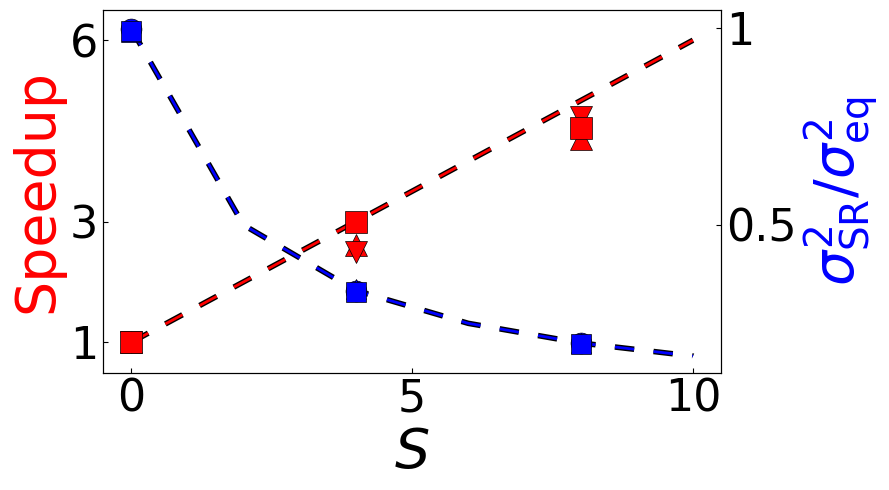

In [99]:

fig, ax1 = plt.subplots(figsize=(9, 5))
ax2 = ax1.twinx()


all_sherf_nums = np.concatenate((sherf_nums_k_5, sherf_nums_k_1, sherf_nums_k_10))
all_sherf_nums = np.sort(all_sherf_nums)
analytical_speedup_factor = np.pow(relative_characteristic_relaxation(all_sherf_nums, 2, 2),-1)
spatial_exploration_factor = relative_characteristic_relaxation(all_sherf_nums, 2, 2)

skip_indices = np.arange(1, len(sherf_nums_k_5), 2)

for i in range(len(sherf_nums_k_5)):
    if i in skip_indices:
        continue
    adjusted_platue = mean_relaxation_times_varing_r_k_5[0]/mean_relaxation_times_varing_r_k_5[i]
    yerr = std_relaxation_times_varing_r_k_5[i]/mean_relaxation_times_varing_r_k_5[0]
    ax1.errorbar(sherf_nums_k_5[i], adjusted_platue, yerr=yerr, xerr=SS_var_by_rate_k_5[i,1], linestyle="", marker = '^', lw=3, ms=16, color='red', markeredgecolor='black', markeredgewidth=0.5)
    ax2.errorbar(sherf_nums_k_5[i], SS_var_by_rate_k_5[i, 0]/typical_length_scale_k_5, yerr=SS_var_by_rate_k_5[i, 1]/typical_length_scale_k_5, linestyle="", marker = 'o', lw=3, ms=15, color='blue', markeredgecolor='black', markeredgewidth=0.5)

for i in range(len(sherf_nums_k_1)):
    if i in skip_indices:
        continue
    adjusted_platue = mean_relaxation_times_varing_r_k_1[0]/mean_relaxation_times_varing_r_k_1[i]
    yerr = std_relaxation_times_varing_r_k_1[i]/mean_relaxation_times_varing_r_k_1[0]
    ax1.errorbar(sherf_nums_k_1[i], adjusted_platue, yerr=yerr, xerr=SS_var_by_rate_k_1[i,1], linestyle="", marker = 'v', lw=3, ms=16, color='red', markeredgecolor='black', markeredgewidth=0.5)
    ax2.errorbar(sherf_nums_k_1[i], SS_var_by_rate_k_1[i, 0]/typical_length_scale_k_1, yerr=SS_var_by_rate_k_1[i, 1]/typical_length_scale_k_1, linestyle="", marker = '^', lw=3, ms=15, color='blue', markeredgecolor='black', markeredgewidth=0.5)

for i in range(len(sherf_nums_k_10)):
    if i in skip_indices:
        continue
    adjusted_platue = mean_relaxation_times_varing_r_k_10[0]/mean_relaxation_times_varing_r_k_10[i]
    yerr = std_relaxation_times_varing_r_k_10[i]/mean_relaxation_times_varing_r_k_10[0]
    ax1.errorbar(sherf_nums_k_10[i], adjusted_platue, yerr=yerr, xerr=SS_var_by_rate_k_10[i,1], linestyle="", marker = 's', lw=3, ms=16, color='red', markeredgecolor='black', markeredgewidth=0.5)
    ax2.errorbar(sherf_nums_k_10[i], SS_var_by_rate_k_10[i, 0]/typical_length_scale_k_10, yerr=SS_var_by_rate_k_10[i, 1]/typical_length_scale_k_10, linestyle="", marker = 's', lw=3, ms=15, color='blue', markeredgecolor='black', markeredgewidth=0.5)

ax1.plot(all_sherf_nums, analytical_speedup_factor, linestyle='--', color='red',dashes=[7,7], linewidth=2, label='$\\frac{2}{2+S}$', path_effects=[pe.withStroke(linewidth=4, foreground='black')])
ax2.plot(all_sherf_nums, spatial_exploration_factor, linestyle='--', color='blue', dashes=[7,7], linewidth=2, label='$\\frac{2+S}{2}$', path_effects=[pe.withStroke(linewidth=4,foreground='black')])

ax1.set_xlabel('$S$', fontsize=40)
ax1.set_ylabel('Speedup', fontsize=40, color='red')
ax2.set_ylabel('$\\sigma_{\\rm SR}^2/\\sigma_{\\rm eq}^2$', fontsize=40, color='blue')
ax1.tick_params(axis='both', which='both', labelsize=32, direction='in')
ax2.tick_params(axis='both', which='both', labelsize=32, direction='in')
ax2.set_yticks([0.5, 1],[0.5,1])
ax1.set_yticks([1, 3, 6],[1, 3,6])
ax1.set_ylim(0.5, 6.5)
legned_handels = []
k_5_handle = plt.scatter([],[], marker='o', color='black', label='K=5', s=150)
k_2_handle = plt.scatter([],[], marker='^', color='black', label='K=1', s=150)
k_10_handle = plt.scatter([],[], marker='s', color='black', label='K=10', s=150)
relaxation_factor_handle = plt.Line2D([0], [0], color='red', linestyle='--', linewidth=3, label='$\\frac{2+S}{2}$')
spatial_exploration_factor_handle = plt.Line2D([0], [0], color='blue', linestyle='--', linewidth=3, label='$\\frac{2}{2+S}$')
legned_handels = [relaxation_factor_handle, spatial_exploration_factor_handle]
#ax2.legend(handles=legned_handels, loc='best', fontsize=23, ncols=2)
fig.tight_layout()
figname = 'Dual axis - Relaxation time by ss var - Harmonic - Vary rate.png'
path = os.path.join('Figures/Figure4',figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=500)
figname = 'Dual axis - Relaxation time by ss var - Harmonic - Vary rate.svg'
path = os.path.join('Figures/Figure4',figname)
plt.savefig(path, bbox_inches='tight',format='svg', dpi=500)
plt.show()

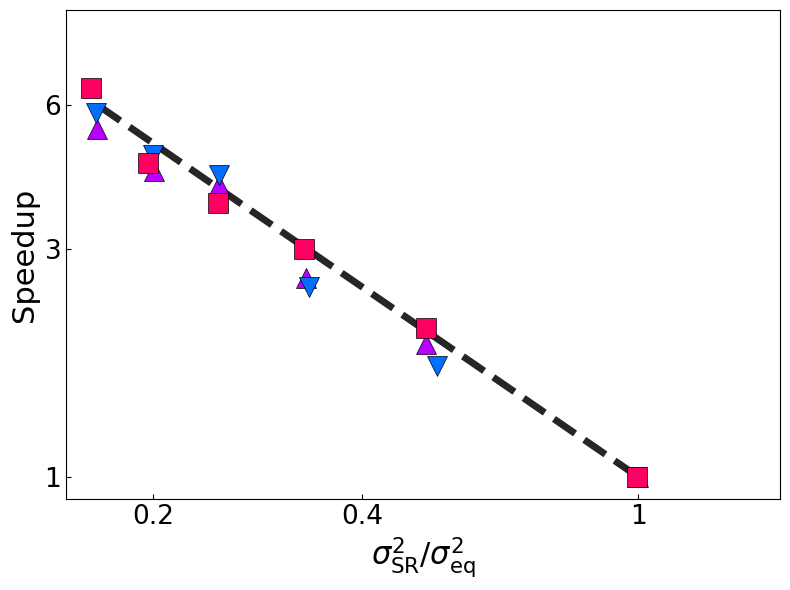

In [100]:
### Relaxation time by ss var ###

fig, ax = plt.subplots(figsize=(8, 6))

slope = -1
x_min = 0.3
x_max = 0.8
k_1_color = "#006EFF"
k_5_color = "#B700FF"
k_10_color = "#FF0062"
for i in range(len(sherf_nums_k_5)):
    adjusted_platue = mean_relaxation_times_varing_r_k_5[0]/mean_relaxation_times_varing_r_k_5[i]
    yerr = std_relaxation_times_varing_r_k_5[i]/mean_relaxation_times_varing_r_k_5[0]
    adjusted_platue_k_1 = mean_relaxation_times_varing_r_k_1[0]/mean_relaxation_times_varing_r_k_1[i]
    yerr_k_1 = std_relaxation_times_varing_r_k_1[i]/mean_relaxation_times_varing_r_k_1[0]
    adjusted_platue_k_10 = mean_relaxation_times_varing_r_k_10[0]/mean_relaxation_times_varing_r_k_10[i]
    yerr_k_10 = std_relaxation_times_varing_r_k_10[i]/mean_relaxation_times_varing_r_k_10[0]
    ax.errorbar(SS_var_by_rate_k_5[i,0]/typical_length_scale_k_5, adjusted_platue, yerr=yerr, xerr=SS_var_by_rate_k_5[i,1], linestyle="", marker = '^', lw=3, ms=15, color=k_5_color, markeredgecolor='black', markeredgewidth=0.5)
    ax.errorbar(SS_var_by_rate_k_1[i,0]/typical_length_scale_k_1, adjusted_platue_k_1, yerr=yerr_k_1, xerr=SS_var_by_rate_k_2[i,1], linestyle="", marker = 'v', lw=3, ms=15, color=k_1_color, markeredgecolor='black', markeredgewidth=0.5)
    ax.errorbar(SS_var_by_rate_k_10[i,0]/typical_length_scale_k_10, adjusted_platue_k_10, yerr=yerr_k_10, xerr=SS_var_by_rate_k_10[i,1], linestyle="", marker = 's', lw=3, ms=15, color=k_10_color, markeredgecolor='black', markeredgewidth=0.5)
ax.plot(SS_var_by_rate_k_1[:,0]/typical_length_scale_k_1, (SS_var_by_rate_k_1[:,0]/typical_length_scale_k_1)**-1, color='black', linestyle='--', linewidth=5, alpha=0.85)
ax.set_ylabel('Speedup', fontsize=22)
ax.set_xlabel('$\\sigma_{\\rm SR}^2/\\sigma_{\\rm eq}^2$', fontsize=22)
ax.set_xlim(0.15,1.6)
ax.set_ylim(0.9, 9.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', direction='in',)
ax.set_xticks(ticks=[0.2, 0.4, 1],labels=[0.2, 0.4, 1], minor=False, fontsize=19)
ax.set_yticks(ticks=[1,3,6],labels=['1', '3', '6'], minor=False, fontsize=19)
ax.minorticks_off()
#ax.plot([x_min,x_max], np.array([(x_min/1.2)**slope, (x_max/1.2)**slope]), color='black', linestyle='-', linewidth=4)
#ax.text(0.6, (0.6/1.7)**slope, f'$m={slope}$', fontsize=22, color='black', ha='center', va='center', fontdict={'weight': 'bold'})
k_5_handle = plt.scatter([],[], marker='o', color='red', label='$\\kappa$=5', s=200, edgecolors='black', linewidth=0.5)
k_2_handle = plt.scatter([],[], marker='^', color='green', label='$\\kappa$=2', s=200, edgecolors='black', linewidth=0.5)
k_10_handle = plt.scatter([],[], marker='s', color='blue', label='$\\kappa$=10', s=200, edgecolors='black', linewidth=0.5)
theo_handle = plt.Line2D([], [], color='black', linestyle='--', linewidth=5, label='$y=x^{-1}$', alpha=0.85)
legend_handles = [k_5_handle, k_2_handle, k_10_handle]
#ax.legend(handles=[theo_handle], fontsize=26, loc='best')
fig.tight_layout()
figname = 'Relaxation time by ss var - Harmonic - Vary rate.png'
path = os.path.join('Figures/Figure4',figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=500)
figname = 'Relaxation time by ss var - Harmonic - Vary rate.svg'
path = os.path.join('Figures/Figure4',figname)
plt.savefig(path, bbox_inches='tight',format='svg', dpi=500)
plt.show()

## Spatial Exploration with Initial Conditions

In [45]:
### Simulation Parameters ###

dt = 0.1
gamma = 500
kT = 1
steps = 10000
n_particles = 30000
batch_size = 10000
batches = int(n_particles/batch_size)
D=kT/gamma

### Harmonic Potential Parameters ###
k_harm = 5
force_args = [k_harm]
typical_relaxation_time = gamma/k_harm
typical_length_scale = np.sqrt(kT/k_harm)

### start positions ###

### relaxation vs X_R ###
### for log spacing ###
'''
start_position_ratios_small = np.linspace(0, 1, 6)
start_position_ratios_high = np.linspace(1, 3, 9)[1:]
start_position_ratios = np.concatenate((start_position_ratios_small, start_position_ratios_high))
'''
### for linear spacing ###
start_position_ratios_small = np.linspace(0, 2, 11)
start_position_ratios_high = np.linspace(2, 5, 4)[1:]
start_positions_ratios_relaxation_vs_xr = np.concatenate((start_position_ratios_small, start_position_ratios_high))
print('start_position_ratios:', start_positions_ratios_relaxation_vs_xr)
start_positions_relaxation_vs_xr = -start_positions_ratios_relaxation_vs_xr * typical_length_scale
start_positions_relaxation_vs_xr_str = [f'{pos:.3f}'[1:] for pos in start_positions_relaxation_vs_xr]
start_positions_relaxation_vs_xr_str = ','.join(start_positions_relaxation_vs_xr_str)

### relaxation vs S-number ###
start_position_ratios_relaxation_vs_Snum = np.array([0, 0.3, 1, 3])
start_positions_relaxation_vs_Snum = -start_position_ratios_relaxation_vs_Snum * typical_length_scale
start_positions_relaxation_vs_Snum_str = [f'{pos:.3f}'[1:] for pos in start_positions_relaxation_vs_Snum]
start_positions_relaxation_vs_Snum_str = ','.join(start_positions_relaxation_vs_Snum_str)

### resetting parameters ### 

### relaxation vs X_R ###
delta_fractions_relaxation_vs_xr = k_harm*np.array([0, 0.0005,0.002,0.01])/5
colors_relaxation_vs_xr = cm.rainbow(np.linspace(0, 1, len(delta_fractions_relaxation_vs_xr)))
resetting_rates_relaxation_vs_xr = delta_fractions_relaxation_vs_xr/dt
resetting_rates_relaxation_vs_xr_str = [f'{rate:.2f}'[1:] for rate in resetting_rates_relaxation_vs_xr]
resetting_rates_relaxation_vs_xr_str = ','.join(resetting_rates_relaxation_vs_xr_str)
sherf_nums_relaxation_vs_xr = gamma*resetting_rates_relaxation_vs_xr/k_harm
print('Sherf numbers relaxation vs X_R:', sherf_nums_relaxation_vs_xr)

### relaxation vs S-number ###
#log-spaced

delta_fractions_relaxation_vs_Snum_log_spaced = k_harm*np.logspace(np.log10(0.00002), np.log10(0.030), 15)/5
delta_fractions_to_add = np.array([0])
delta_fractions_relaxation_vs_Snum_log_spaced = np.concatenate((delta_fractions_to_add, delta_fractions_relaxation_vs_Snum_log_spaced))
resetting_rates_relaxation_vs_Snum_log_spaced = delta_fractions_relaxation_vs_Snum_log_spaced/dt
resetting_rates_relaxation_vs_Snum_log_spaced_str = [f'{rate:.2f}'[1:] for rate in resetting_rates_relaxation_vs_Snum_log_spaced]
resetting_rates_relaxation_vs_Snum_log_spaced_str = ','.join(resetting_rates_relaxation_vs_Snum_log_spaced_str)
sherf_nums_relaxation_vs_Snum_log_spaced = gamma*resetting_rates_relaxation_vs_Snum_log_spaced/k_harm
print('Sherf numbers relaxation vs S-number (log spaced):', sherf_nums_relaxation_vs_Snum_log_spaced)

#linear-spaced
S_ratios = np.concatenate((np.linspace(0, 2, 11), np.linspace(2, 5, 4)[1:]))
delta_fractions_relaxation_vs_Snum = (k_harm*S_ratios/gamma)*dt

colors_relaxation_vs_Snum = cm.rainbow(np.linspace(0, 1, len(start_positions_relaxation_vs_Snum)))
resetting_rates_relaxation_vs_Snum = delta_fractions_relaxation_vs_Snum/dt
resetting_rates_relaxation_vs_Snum_str = [f'{rate:.2f}'[1:] for rate in resetting_rates_relaxation_vs_Snum]
resetting_rates_relaxation_vs_Snum_str = ','.join(resetting_rates_relaxation_vs_Snum_str)
sherf_nums_relaxation_vs_Snum = gamma*resetting_rates_relaxation_vs_Snum/k_harm
print('Sherf numbers relaxation vs S-number:', sherf_nums_relaxation_vs_Snum)


### folder names and subfolders ###

### relaxation vs X_R ###
'''
folder_relaxation_vs_x_r = f'HarmonicPotentialTrajectories/R-{resetting_rates_relaxation_vs_xr_str}_X-{start_positions_relaxation_vs_xr_str}'
if k_harm != 5:
    folder_relaxation_vs_x_r += f'_k={k_harm}'
subfolders_relaxation_vs_x_r = [folder_relaxation_vs_x_r + f'/X-{start_position:.3f}' for start_position in start_positions_relaxation_vs_xr]
print('Folder -', folder_relaxation_vs_x_r)
print('Subfolders -', subfolders_relaxation_vs_x_r)
'''

### relaxation vs S-number ###
folder_relaxation_vs_s_num = f'HarmonicPotentialTrajectories/R-{resetting_rates_relaxation_vs_Snum_str}_X-{start_positions_relaxation_vs_Snum_str}'
folder_relaxation_vs_s_num_log_spaced = f'HarmonicPotentialTrajectories/R-{resetting_rates_relaxation_vs_Snum_log_spaced_str}_X-{start_positions_relaxation_vs_Snum_str}'
if k_harm != 5:
    folder_relaxation_vs_s_num += f'_k={k_harm}'
subfolders_relaxation_vs_s_num = [folder_relaxation_vs_s_num + f'/X-{start_position:.3f}' for start_position in start_positions_relaxation_vs_Snum]
subfolders_relaxation_vs_s_num_log_spaced = [folder_relaxation_vs_s_num_log_spaced + f'/X-{start_position:.3f}' for start_position in start_positions_relaxation_vs_Snum]

print('Folder (log spaced data) -', folder_relaxation_vs_s_num_log_spaced)
print('Subfolders (log spaced data) -', subfolders_relaxation_vs_s_num_log_spaced)
print('Folder -', folder_relaxation_vs_s_num)
print('Subfolders -', subfolders_relaxation_vs_s_num)

start_position_ratios: [0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  3.  4.  5. ]
Sherf numbers relaxation vs X_R: [ 0.   0.5  2.  10. ]
Sherf numbers relaxation vs S-number (log spaced): [0.00000000e+00 2.00000000e-02 3.37204729e-02 5.68535147e-02
 9.58563703e-02 1.61616107e-01 2.72488578e-01 4.59422186e-01
 7.74596669e-01 1.30598830e+00 2.20192716e+00 3.71250126e+00
 6.25936491e+00 1.05534372e+01 1.77933447e+01 3.00000000e+01]
Sherf numbers relaxation vs S-number: [0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  3.  4.  5. ]
Folder (log spaced data) - HarmonicPotentialTrajectories/R-.00,.00,.00,.00,.00,.00,.00,.00,.01,.01,.02,.04,.06,.11,.18,.30_X-0.000,0.134,0.447,1.342
Subfolders (log spaced data) - ['HarmonicPotentialTrajectories/R-.00,.00,.00,.00,.00,.00,.00,.00,.01,.01,.02,.04,.06,.11,.18,.30_X-0.000,0.134,0.447,1.342/X--0.000', 'HarmonicPotentialTrajectories/R-.00,.00,.00,.00,.00,.00,.00,.00,.01,.01,.02,.04,.06,.11,.18,.30_X-0.000,0.134,0.447,1.342/X--0.134', 'HarmonicPotentialTraje

In [46]:
### Load Data ###

### relaxation vs S-number ###
platue_index_per_r_per_start_T_vs_S = np.load(folder_relaxation_vs_s_num+'/platue_index_per_r_per_start.npy', allow_pickle=True)
KLDs_per_rate_per_start_T_vs_S = np.load(folder_relaxation_vs_s_num+'/KLDs_per_rate_per_start.npy', allow_pickle=True)
boltzmann_platue_index_per_start_T_vs_S = platue_index_per_r_per_start_T_vs_S[:,0]
print('Boltzmann plateau index per start T:', boltzmann_platue_index_per_start_T_vs_S.shape)
print('Platue index per rate per start T:', platue_index_per_r_per_start_T_vs_S.shape)

### relaxation vs S-number (log spaced data) ###
platue_index_per_r_per_start_T_vs_S_log_spaced = np.load(folder_relaxation_vs_s_num_log_spaced+'/platue_index_per_r_per_start.npy', allow_pickle=True)
KLDs_per_rate_per_start_T_vs_S_log_spaced = np.load(folder_relaxation_vs_s_num_log_spaced+'/KLDs_per_rate_per_start.npy', allow_pickle=True)
boltzmann_platue_index_per_start_T_vs_S_log_spaced = platue_index_per_r_per_start_T_vs_S_log_spaced[:,0]
print('Boltzmann plateau index per start T (log spaced):', boltzmann_platue_index_per_start_T_vs_S_log_spaced.shape)
print('Platue index per rate per start T (log spaced):', platue_index_per_r_per_start_T_vs_S_log_spaced.shape)

### relaxation vs X_R ###
'''
platue_index_per_r_per_start_T_vs_XR = np.load(folder_relaxation_vs_x_r+'/platue_index_per_r_per_start.npy', allow_pickle=True)
KLDs_per_rate_per_start_T_vs_XR = np.load(folder_relaxation_vs_x_r+'/KLDs_per_rate_per_start.npy', allow_pickle=True)
boltzmann_platue_index_per_start_T_vs_XR = platue_index_per_r_per_start_T_vs_XR[:,0]
'''

Boltzmann plateau index per start T: (4,)
Platue index per rate per start T: (4, 14)
Boltzmann plateau index per start T (log spaced): (4,)
Platue index per rate per start T (log spaced): (4, 16)


"\nplatue_index_per_r_per_start_T_vs_XR = np.load(folder_relaxation_vs_x_r+'/platue_index_per_r_per_start.npy', allow_pickle=True)\nKLDs_per_rate_per_start_T_vs_XR = np.load(folder_relaxation_vs_x_r+'/KLDs_per_rate_per_start.npy', allow_pickle=True)\nboltzmann_platue_index_per_start_T_vs_XR = platue_index_per_r_per_start_T_vs_XR[:,0]\n"

In [37]:
a = np.array([1,2,3])
b = np.array([4,5,6])
print(a*b)

[ 4 10 18]


#### with normalization of X-axis by sqrt(D/r)

In [38]:
### load histograms per rate per X_R ###
SS_second_moment_boltz = kT/k_harm
SS_mean_per_rate_per_start = []
SS_second_moment_per_rate_per_start = []
SS_variance_per_rate_per_start = []
average_hists_per_rate_per_start = []
histograms_per_rate_per_start = np.load(folder_relaxation_vs_s_num+'/histograms_per_rate_per_start.npy', allow_pickle=True)
SS_samples = 50
for subfolder in subfolders_relaxation_vs_s_num:
    means_per_start = []
    second_moments_per_start = []
    variances_per_start = []
    histograms_per_rate = np.load(subfolder+'/histograms_per_rate.npy', allow_pickle=True)
    average_hists_per_start = []
    print(f'Histograms per rate per start shape for {subfolder}:', histograms_per_rate.shape)
    for i, histogram in enumerate(histograms_per_rate):
        average_hist = np.average(histogram[-SS_samples:], axis=0)
        total_samples = np.sum(average_hist[0])
        normalization_factor = np.trapezoid(average_hist[0], average_hist[1])
        if 1 - normalization_factor > 0.0001:
            print(f'Warning: Histogram for {subfolder} does not sum to 1, normalization factor: {normalization_factor}')
        if resetting_rates_relaxation_vs_Snum[i] != 0:
            mean = np.sum(average_hist[0]*average_hist[1]/(total_samples*np.sqrt(D/resetting_rates_relaxation_vs_Snum[i])))
            second_moment = np.sum((average_hist[0]/total_samples)*(average_hist[1]/np.sqrt(D/resetting_rates_relaxation_vs_Snum[i]))**2)
            variance = np.sum((average_hist[0]/total_samples)*((average_hist[1]/np.sqrt(D/resetting_rates_relaxation_vs_Snum[i]))-mean)**2)
        else:
            mean = np.sum(average_hist[0]*average_hist[1]/(total_samples))
            second_moment = np.sum((average_hist[0]/total_samples)*(average_hist[1])**2)
            variance = np.sum((average_hist[0]/total_samples)*((average_hist[1]-mean)**2))
        means_per_start.append(mean)
        second_moments_per_start.append(second_moment)
        variances_per_start.append(variance)
        average_hists_per_start.append(average_hist)
    SS_mean_per_rate_per_start.append(means_per_start)
    SS_second_moment_per_rate_per_start.append(second_moments_per_start)
    SS_variance_per_rate_per_start.append(variances_per_start)
    average_hists_per_rate_per_start.append(average_hists_per_start)
SS_mean_per_rate_per_start = np.array(SS_mean_per_rate_per_start)
SS_second_moment_per_rate_per_start = np.array(SS_second_moment_per_rate_per_start)
SS_variance_per_rate_per_start = np.array(SS_variance_per_rate_per_start)
average_hists_per_rate_per_start = np.array(average_hists_per_rate_per_start)


Histograms per rate per start shape for HarmonicPotentialTrajectories/R-.00,.00,.00,.01,.01,.01,.01,.01,.02,.02,.02,.03,.04,.05_X-0.000,0.134,0.447,1.342/X--0.000: (14, 1601, 2, 200)
Histograms per rate per start shape for HarmonicPotentialTrajectories/R-.00,.00,.00,.01,.01,.01,.01,.01,.02,.02,.02,.03,.04,.05_X-0.000,0.134,0.447,1.342/X--0.134: (14, 1601, 2, 200)
Histograms per rate per start shape for HarmonicPotentialTrajectories/R-.00,.00,.00,.01,.01,.01,.01,.01,.02,.02,.02,.03,.04,.05_X-0.000,0.134,0.447,1.342/X--0.447: (14, 1601, 2, 200)
Histograms per rate per start shape for HarmonicPotentialTrajectories/R-.00,.00,.00,.01,.01,.01,.01,.01,.02,.02,.02,.03,.04,.05_X-0.000,0.134,0.447,1.342/X--1.342: (14, 1601, 2, 200)


<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
C:\Users\nir19\AppData\Local\Temp\ipykernel_15704\769820908.py:9: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('x/$\sqrt{D/r}$')


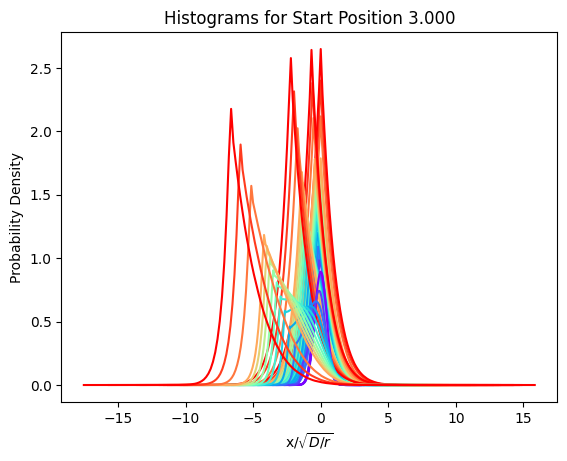

In [39]:
resetting_colors = cm.rainbow(np.linspace(0, 1, len(resetting_rates_relaxation_vs_Snum)))
for i, histograms_per_rate in enumerate(histograms_per_rate_per_start):
    for j, (hists_per_time, c) in enumerate(zip(histograms_per_rate, resetting_colors)):
        histogram, bin_centers = hists_per_time[-1] ## ss distribution
        if resetting_rates_relaxation_vs_Snum[j] != 0:
            plt.plot(bin_centers/np.sqrt(D/resetting_rates_relaxation_vs_Snum[j]), histogram, label=f'Start {i+1}, Rate {j+1}', color=c)
        else:
            plt.plot(bin_centers, histogram, label=f'Start {i+1}, Rate {j+1}', color=c)
    plt.xlabel('x/$\sqrt{D/r}$')
    plt.ylabel('Probability Density')
    plt.title(f'Histograms for Start Position {start_position_ratios_relaxation_vs_Snum[i]:.3f}')
plt.show()

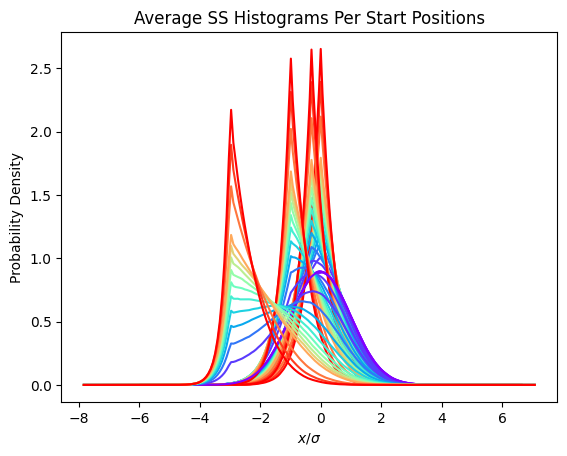

In [40]:
resetting_colors = cm.rainbow(np.linspace(0, 1, len(resetting_rates_relaxation_vs_Snum)))
for i, average_hist_per_rate in enumerate(average_hists_per_rate_per_start):
    for j, (hists_per_time, c) in enumerate(zip(average_hist_per_rate, resetting_colors)):
        histogram, bin_centers = hists_per_time ## ss distribution
        plt.plot(bin_centers/np.sqrt(SS_second_moment_boltz), histogram, label=f'Start {i+1}, Rate {j+1}', color=c)
    plt.xlabel('$x/\\sigma$')
    plt.ylabel('Probability Density')
plt.title(f'Average SS Histograms Per Start Positions')
plt.show()

SS mean per rate per start shape: (4, 14)


Text(0, 0.5, '$\\langle \\tilde X \\rangle/\\sigma_{eq}$')

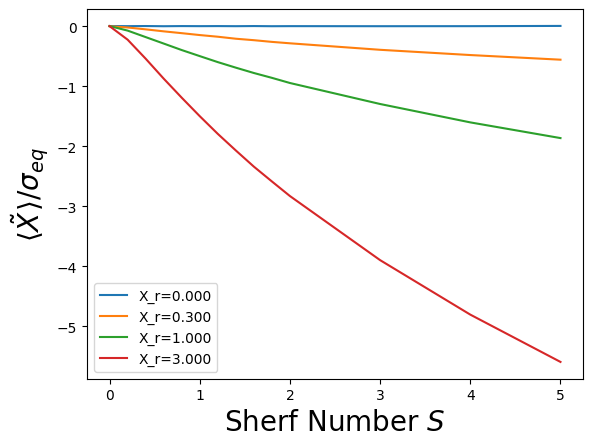

In [41]:
print('SS mean per rate per start shape:', SS_mean_per_rate_per_start.shape)
for X_r, SS_means in zip(start_position_ratios_relaxation_vs_Snum,SS_mean_per_rate_per_start):
    plt.plot(sherf_nums_relaxation_vs_Snum, SS_means, label=f'X_r={X_r:.3f}')
plt.legend()
plt.xlabel('Sherf Number $S$', fontsize=20)
plt.ylabel('$\\langle \\tilde X \\rangle/\\sigma_{eq}$', fontsize=20)

SS second moment per rate per start shape: (4, 14)


Text(0, 0.5, '$\\langle \\tilde X^2 \\rangle/\\sigma_{eq}$')

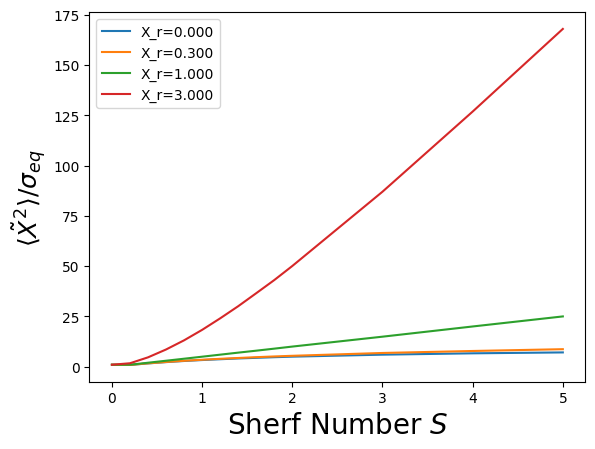

In [42]:
print('SS second moment per rate per start shape:', SS_second_moment_per_rate_per_start.shape)
for X_r, SS_sec_moment in zip(start_position_ratios_relaxation_vs_Snum,SS_second_moment_per_rate_per_start):
    plt.plot(sherf_nums_relaxation_vs_Snum, SS_sec_moment/SS_second_moment_boltz, label=f'X_r={X_r:.3f}')
plt.legend()
plt.xlabel('Sherf Number $S$', fontsize=20)
plt.ylabel('$\\langle \\tilde X^2 \\rangle/\\sigma_{eq}$', fontsize=18)

SS variance per rate per start shape: (4, 14)


Text(0, 0.5, '$\\tilde{Var}/eq$')

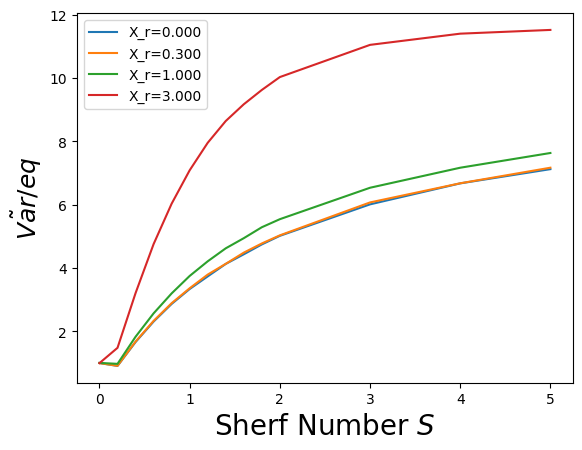

In [43]:
print('SS variance per rate per start shape:', SS_variance_per_rate_per_start.shape)
for X_r, SS_vars in zip(start_position_ratios_relaxation_vs_Snum,SS_variance_per_rate_per_start):
    plt.plot(sherf_nums_relaxation_vs_Snum, SS_vars/SS_second_moment_boltz, label=f'X_r={X_r:.3f}')
plt.legend()
plt.xlabel('Sherf Number $S$', fontsize=20)
plt.ylabel('$\\tilde{Var}/eq$', fontsize=18)

In [44]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make a user-defined colormap.
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",['orange','r',"r"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=min(abs(start_positions_relaxation_vs_Snum)),vmax=max(abs(start_positions_relaxation_vs_Snum)))
# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)

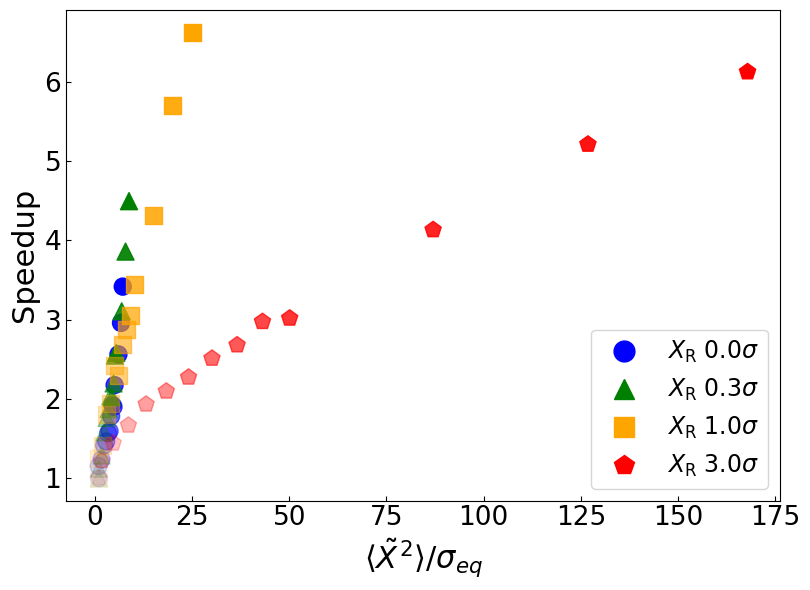

In [ ]:
### plotting linear spaced data ###
slope_1 = -1

func1 = lambda x: 1/(1+x)
func2 = lambda x: 2/(2+x)
symbols = ['o', '^', 's', 'p']
matplotlib_colors = ['blue', 'green', 'orange', 'red']

fig, ax = plt.subplots(figsize=(8, 6))

for i, (platue_index_per_r, c, start_position, boltz_platue, symbol) in enumerate(zip(platue_index_per_r_per_start_T_vs_S, matplotlib_colors, start_positions_relaxation_vs_Snum, boltzmann_platue_index_per_start_T_vs_S, symbols)):
    alphas = np.linspace(0.1, 1, len(platue_index_per_r))
    ax.scatter(SS_second_moment_per_rate_per_start[i]/SS_second_moment_boltz, boltz_platue/platue_index_per_r, linestyle='', marker=symbol, lw=3, s=150, color=c, alpha=alphas)#, color=cpick.to_rgba(abs(start_position)))
start_position_handles = [plt.Line2D([0], [0],linestyle='',color=c, marker=symbol,ms=15, label='$X_{\\rm R} $' + f' {abs(start_position)/typical_length_scale:.1f}$\\sigma$') for c, symbol, start_position in zip(matplotlib_colors, symbols, start_positions_relaxation_vs_Snum)]
handles = start_position_handles
ax.legend(handles=handles, loc='best', fontsize=17)
ax.set_xlabel('$\\langle \\tilde X^2 \\rangle/\\sigma_{eq}$', fontsize=22)
ax.set_ylabel('Speedup', fontsize=22)
#ax.set_ylabel('$\\mathcal{T}_{\\rm SR}$ / $\\mathcal{T}_{\\rm eq}$', fontsize=32)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=19, direction='in')
#ax.set_xticks([1, 3, 5], [1, 3, 5])
#ax.set_yticks([1, 2 ,6], [1,2,6])
fig.tight_layout()
fig_name = 'Fig 5 - Speedup by S - Vary Xr.svg'
saving_folder = 'Figures/OVERLEAF'
path = os.path.join(saving_folder, fig_name)
#plt.savefig(path, bbox_inches='tight', format='svg', dpi=300)
plt.show()

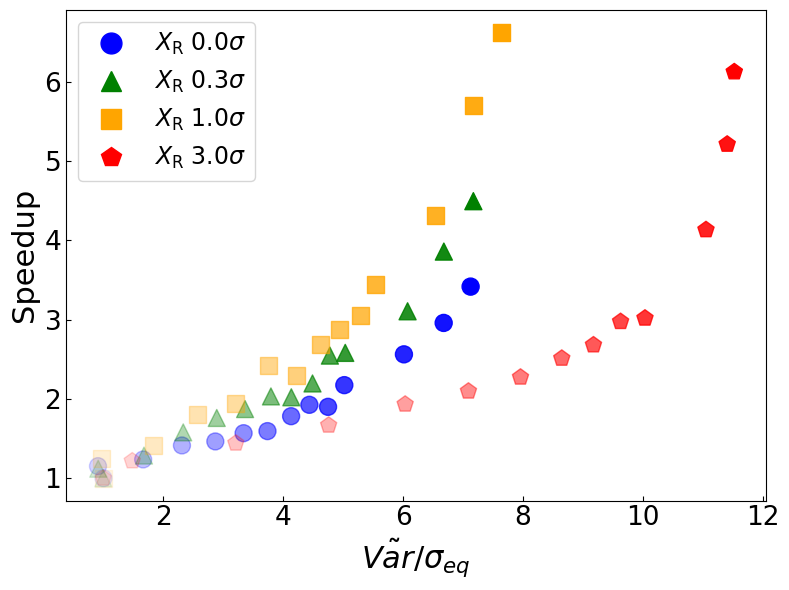

In [ ]:
### plotting linear spaced data ###
slope_1 = -1

func1 = lambda x: 1/(1+x)
func2 = lambda x: 2/(2+x)
symbols = ['o', '^', 's', 'p']
matplotlib_colors = ['blue', 'green', 'orange', 'red']

fig, ax = plt.subplots(figsize=(8, 6))

for i, (platue_index_per_r, c, start_position, boltz_platue, symbol) in enumerate(zip(platue_index_per_r_per_start_T_vs_S, matplotlib_colors, start_positions_relaxation_vs_Snum, boltzmann_platue_index_per_start_T_vs_S, symbols)):
    alphas = np.linspace(0.1, 1, len(platue_index_per_r))
    ax.scatter(SS_variance_per_rate_per_start[i]/SS_second_moment_boltz, boltz_platue/platue_index_per_r, linestyle='', marker=symbol, lw=3, s=150, color=c, alpha=alphas)#, color=cpick.to_rgba(abs(start_position)))
start_position_handles = [plt.Line2D([0], [0],linestyle='',color=c, marker=symbol,ms=15, label='$X_{\\rm R} $' + f' {abs(start_position)/typical_length_scale:.1f}$\\sigma$') for c, symbol, start_position in zip(matplotlib_colors, symbols, start_positions_relaxation_vs_Snum)]
handles = start_position_handles
ax.legend(handles=handles, loc='best', fontsize=17)
ax.set_xlabel('$\\tilde{Var}/\\sigma_{eq}$', fontsize=22)
ax.set_ylabel('Speedup', fontsize=22)
#ax.set_ylabel('$\\mathcal{T}_{\\rm SR}$ / $\\mathcal{T}_{\\rm eq}$', fontsize=32)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=19, direction='in')
#ax.set_xticks([1, 3, 5], [1, 3, 5])
#ax.set_yticks([1, 2 ,6], [1,2,6])
fig.tight_layout()
fig_name = 'Fig 5 - Speedup by S - Vary Xr.svg'
saving_folder = 'Figures/OVERLEAF'
path = os.path.join(saving_folder, fig_name)
#plt.savefig(path, bbox_inches='tight', format='svg', dpi=300)
plt.show()

#### no normalization 

In [47]:
### load histograms per rate per X_R ###
SS_second_moment_boltz = kT/k_harm
SS_mean_per_rate_per_start = []
SS_second_moment_per_rate_per_start = []
SS_variance_per_rate_per_start = []
average_hists_per_rate_per_start = []
histograms_per_rate_per_start = np.load(folder_relaxation_vs_s_num+'/histograms_per_rate_per_start.npy', allow_pickle=True)
SS_samples = 50
for subfolder in subfolders_relaxation_vs_s_num:
    means_per_start = []
    second_moments_per_start = []
    variances_per_start = []
    histograms_per_rate = np.load(subfolder+'/histograms_per_rate.npy', allow_pickle=True)
    average_hists_per_start = []
    print(f'Histograms per rate per start shape for {subfolder}:', histograms_per_rate.shape)
    for i, histogram in enumerate(histograms_per_rate):
        average_hist = np.average(histogram[-SS_samples:], axis=0)
        total_samples = np.sum(average_hist[0])
        normalization_factor = np.trapezoid(average_hist[0], average_hist[1])
        if 1 - normalization_factor > 0.0001:
            print(f'Warning: Histogram for {subfolder} does not sum to 1, normalization factor: {normalization_factor}')
        mean = np.sum(average_hist[0]*average_hist[1]/(total_samples))
        second_moment = np.sum((average_hist[0]/total_samples)*(average_hist[1])**2)
        variance = np.sum((average_hist[0]/total_samples)*((average_hist[1]-mean)**2))
        means_per_start.append(mean)
        second_moments_per_start.append(second_moment)
        variances_per_start.append(variance)
        average_hists_per_start.append(average_hist)
    SS_mean_per_rate_per_start.append(means_per_start)
    SS_second_moment_per_rate_per_start.append(second_moments_per_start)
    SS_variance_per_rate_per_start.append(variances_per_start)
    average_hists_per_rate_per_start.append(average_hists_per_start)
SS_mean_per_rate_per_start = np.array(SS_mean_per_rate_per_start)
SS_second_moment_per_rate_per_start = np.array(SS_second_moment_per_rate_per_start)
SS_variance_per_rate_per_start = np.array(SS_variance_per_rate_per_start)
average_hists_per_rate_per_start = np.array(average_hists_per_rate_per_start)

Histograms per rate per start shape for HarmonicPotentialTrajectories/R-.00,.00,.00,.01,.01,.01,.01,.01,.02,.02,.02,.03,.04,.05_X-0.000,0.134,0.447,1.342/X--0.000: (14, 1601, 2, 200)
Histograms per rate per start shape for HarmonicPotentialTrajectories/R-.00,.00,.00,.01,.01,.01,.01,.01,.02,.02,.02,.03,.04,.05_X-0.000,0.134,0.447,1.342/X--0.134: (14, 1601, 2, 200)
Histograms per rate per start shape for HarmonicPotentialTrajectories/R-.00,.00,.00,.01,.01,.01,.01,.01,.02,.02,.02,.03,.04,.05_X-0.000,0.134,0.447,1.342/X--0.447: (14, 1601, 2, 200)
Histograms per rate per start shape for HarmonicPotentialTrajectories/R-.00,.00,.00,.01,.01,.01,.01,.01,.02,.02,.02,.03,.04,.05_X-0.000,0.134,0.447,1.342/X--1.342: (14, 1601, 2, 200)


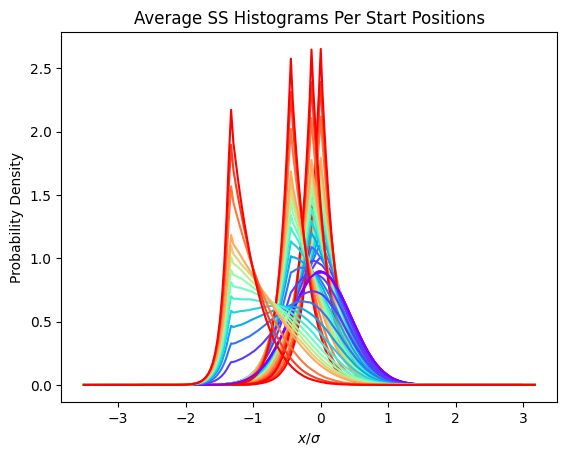

In [48]:
resetting_colors = cm.rainbow(np.linspace(0, 1, len(resetting_rates_relaxation_vs_Snum)))
for i, average_hist_per_rate in enumerate(average_hists_per_rate_per_start):
    for j, (hists_per_time, c) in enumerate(zip(average_hist_per_rate, resetting_colors)):
        histogram, bin_centers = hists_per_time ## ss distribution
        plt.plot(bin_centers, histogram, label=f'Start {i+1}, Rate {j+1}', color=c)
    plt.xlabel('$x/\\sigma$')
    plt.ylabel('Probability Density')
plt.title(f'Average SS Histograms Per Start Positions')
plt.show()

SS mean per rate per start shape: (4, 14)


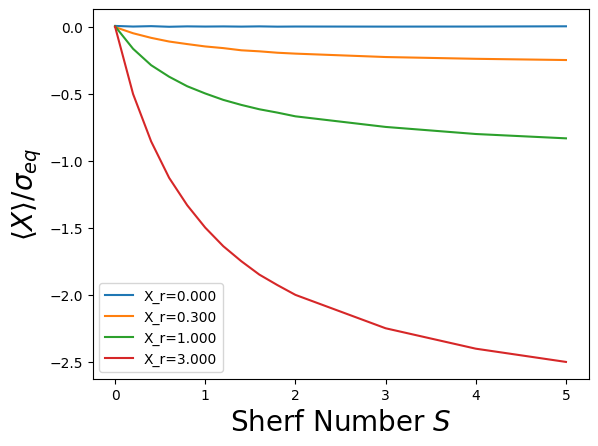

In [49]:
print('SS mean per rate per start shape:', SS_mean_per_rate_per_start.shape)
for X_r, SS_means in zip(start_position_ratios_relaxation_vs_Snum,SS_mean_per_rate_per_start):
    plt.plot(sherf_nums_relaxation_vs_Snum, SS_means/np.sqrt(SS_second_moment_boltz), label=f'X_r={X_r:.3f}')
plt.legend()
plt.xlabel('Sherf Number $S$', fontsize=20)
plt.ylabel('$\\langle X \\rangle/\\sigma_{eq}$', fontsize=20)
plt.show()

SS second moment per rate per start shape: (4, 14)


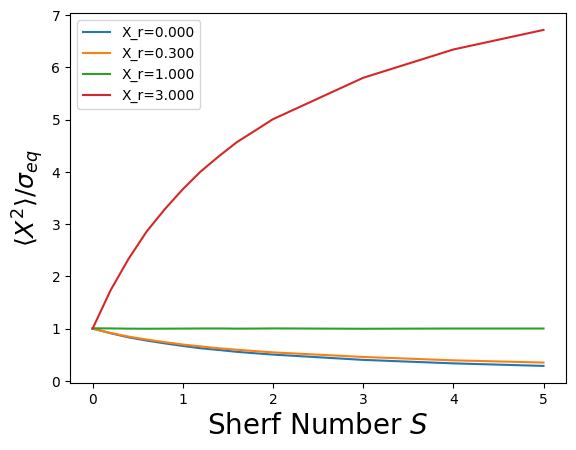

In [50]:
print('SS second moment per rate per start shape:', SS_second_moment_per_rate_per_start.shape)
for X_r, SS_sec_moment in zip(start_position_ratios_relaxation_vs_Snum,SS_second_moment_per_rate_per_start):
    plt.plot(sherf_nums_relaxation_vs_Snum, SS_sec_moment/SS_second_moment_boltz, label=f'X_r={X_r:.3f}')
plt.legend()
plt.xlabel('Sherf Number $S$', fontsize=20)
plt.ylabel('$\\langle  X^2 \\rangle/\\sigma_{eq}$', fontsize=18)
plt.show()

SS variance per rate per start shape: (4, 14)


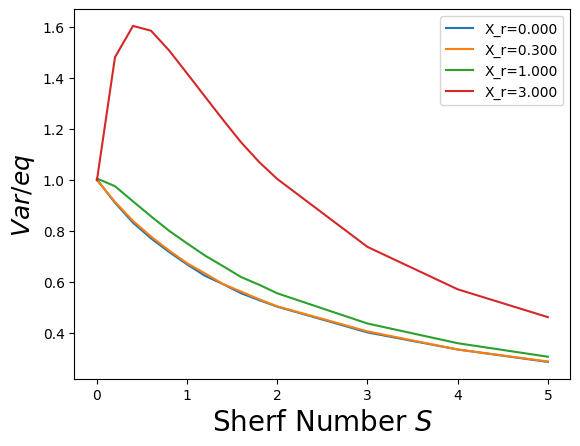

In [51]:
print('SS variance per rate per start shape:', SS_variance_per_rate_per_start.shape)
for X_r, SS_vars in zip(start_position_ratios_relaxation_vs_Snum,SS_variance_per_rate_per_start):
    plt.plot(sherf_nums_relaxation_vs_Snum, SS_vars/SS_second_moment_boltz, label=f'X_r={X_r:.3f}')
plt.legend()
plt.xlabel('Sherf Number $S$', fontsize=20)
plt.ylabel('${Var}/eq$', fontsize=18)
plt.show()

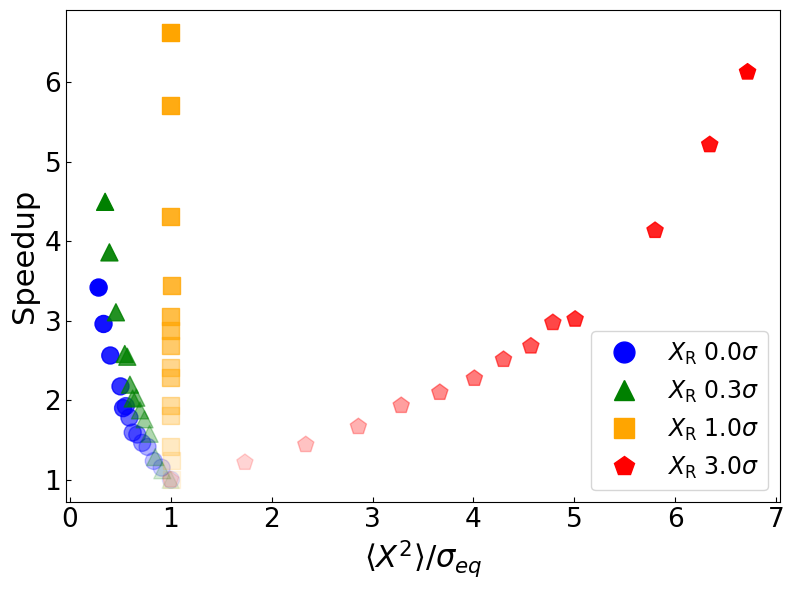

In [ ]:
### plotting linear spaced data ###
slope_1 = -1

func1 = lambda x: 1/(1+x)
func2 = lambda x: 2/(2+x)
symbols = ['o', '^', 's', 'p']
matplotlib_colors = ['blue', 'green', 'orange', 'red']

fig, ax = plt.subplots(figsize=(8, 6))

for i, (platue_index_per_r, c, start_position, boltz_platue, symbol) in enumerate(zip(platue_index_per_r_per_start_T_vs_S, matplotlib_colors, start_positions_relaxation_vs_Snum, boltzmann_platue_index_per_start_T_vs_S, symbols)):
    alphas = np.linspace(0.1, 1, len(platue_index_per_r))
    ax.scatter(SS_second_moment_per_rate_per_start[i]/SS_second_moment_boltz, boltz_platue/platue_index_per_r, linestyle='', marker=symbol, lw=3, s=150, color=c, alpha=alphas)#, color=cpick.to_rgba(abs(start_position)))
start_position_handles = [plt.Line2D([0], [0],linestyle='',color=c, marker=symbol,ms=15, label='$X_{\\rm R} $' + f' {abs(start_position)/typical_length_scale:.1f}$\\sigma$') for c, symbol, start_position in zip(matplotlib_colors, symbols, start_positions_relaxation_vs_Snum)]
handles = start_position_handles
ax.legend(handles=handles, loc='best', fontsize=17)
ax.set_xlabel('$\\langle X^2 \\rangle/\\sigma_{eq}$', fontsize=22)
ax.set_ylabel('Speedup', fontsize=22)
#ax.set_ylabel('$\\mathcal{T}_{\\rm SR}$ / $\\mathcal{T}_{\\rm eq}$', fontsize=32)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=19, direction='in')
#ax.set_xticks([1, 3, 5], [1, 3, 5])
#ax.set_yticks([1, 2 ,6], [1,2,6])
fig.tight_layout()
fig_name = 'Fig 5 - Speedup by S - Vary Xr.svg'
saving_folder = 'Figures/OVERLEAF'
path = os.path.join(saving_folder, fig_name)
#plt.savefig(path, bbox_inches='tight', format='svg', dpi=300)
plt.show()

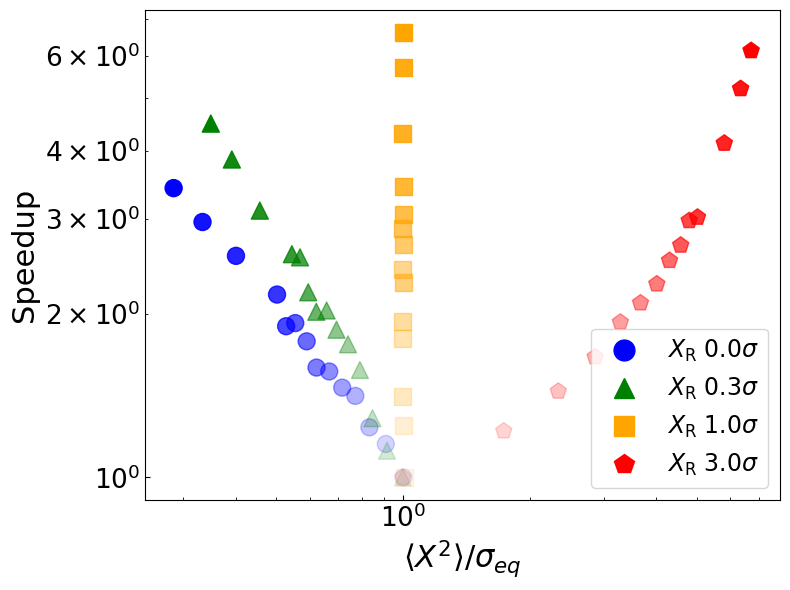

In [ ]:
### plotting linear spaced data ###
slope_1 = -1

func1 = lambda x: 1/(1+x)
func2 = lambda x: 2/(2+x)
symbols = ['o', '^', 's', 'p']
matplotlib_colors = ['blue', 'green', 'orange', 'red']

fig, ax = plt.subplots(figsize=(8, 6))

for i, (platue_index_per_r, c, start_position, boltz_platue, symbol) in enumerate(zip(platue_index_per_r_per_start_T_vs_S, matplotlib_colors, start_positions_relaxation_vs_Snum, boltzmann_platue_index_per_start_T_vs_S, symbols)):
    alphas = np.linspace(0.1, 1, len(platue_index_per_r))
    ax.scatter(SS_second_moment_per_rate_per_start[i]/SS_second_moment_boltz, boltz_platue/platue_index_per_r, linestyle='', marker=symbol, lw=3, s=150, color=c, alpha=alphas)#, color=cpick.to_rgba(abs(start_position)))
start_position_handles = [plt.Line2D([0], [0],linestyle='',color=c, marker=symbol,ms=15, label='$X_{\\rm R} $' + f' {abs(start_position)/typical_length_scale:.1f}$\\sigma$') for c, symbol, start_position in zip(matplotlib_colors, symbols, start_positions_relaxation_vs_Snum)]
handles = start_position_handles
ax.legend(handles=handles, loc='best', fontsize=17)
ax.set_xlabel('$\\langle X^2 \\rangle/\\sigma_{eq}$', fontsize=22)
ax.set_ylabel('Speedup', fontsize=22)
#ax.set_ylabel('$\\mathcal{T}_{\\rm SR}$ / $\\mathcal{T}_{\\rm eq}$', fontsize=32)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=19, direction='in')
#ax.set_xticks([1, 3, 5], [1, 3, 5])
#ax.set_yticks([1, 2 ,6], [1,2,6])
fig.tight_layout()
fig_name = 'Fig 5 - Speedup by S - Vary Xr.svg'
saving_folder = 'Figures/OVERLEAF'
path = os.path.join(saving_folder, fig_name)
#plt.savefig(path, bbox_inches='tight', format='svg', dpi=300)
plt.show()

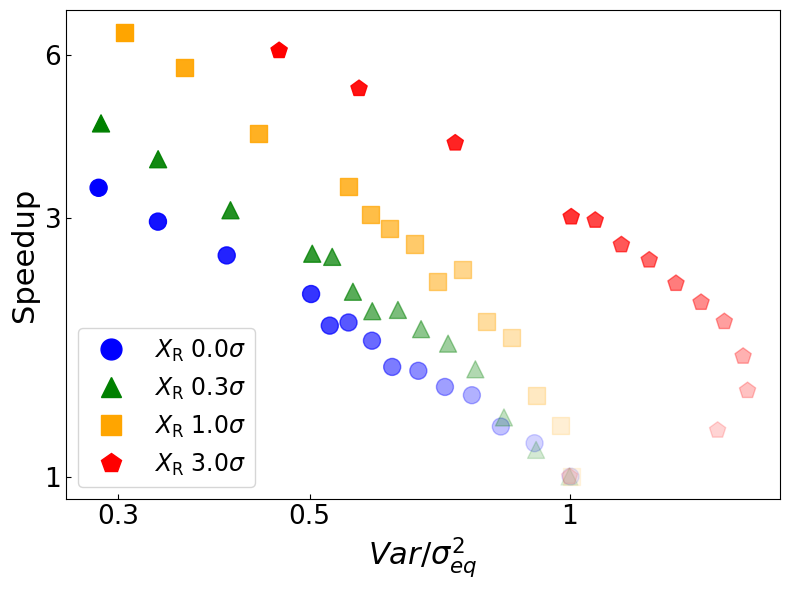

In [ ]:

### plotting linear spaced data ###
slope_1 = -1

func1 = lambda x: 1/(1+x)
func2 = lambda x: 2/(2+x)
symbols = ['o', '^', 's', 'p']
matplotlib_colors = ['blue', 'green', 'orange', 'red']

fig, ax = plt.subplots(figsize=(8, 6))

for i, (platue_index_per_r, c, start_position, boltz_platue, symbol) in enumerate(zip(platue_index_per_r_per_start_T_vs_S, matplotlib_colors, start_positions_relaxation_vs_Snum, boltzmann_platue_index_per_start_T_vs_S, symbols)):
    alphas = np.linspace(0.1, 1, len(platue_index_per_r))
    ax.scatter(SS_variance_per_rate_per_start[i]/SS_second_moment_boltz, boltz_platue/platue_index_per_r, linestyle='', marker=symbol, lw=3, s=150, color=c, alpha=alphas)#, color=cpick.to_rgba(abs(start_position)))
start_position_handles = [plt.Line2D([0], [0],linestyle='',color=c, marker=symbol,ms=15, label='$X_{\\rm R} $' + f' {abs(start_position)/typical_length_scale:.1f}$\\sigma$') for c, symbol, start_position in zip(matplotlib_colors, symbols, start_positions_relaxation_vs_Snum)]
handles = start_position_handles
ax.legend(handles=handles, loc='lower left', fontsize=17)
ax.set_xlabel('$Var/\\sigma^2_{eq}$', fontsize=22)
ax.set_ylabel('Speedup', fontsize=22)
#ax.set_ylabel('$\\mathcal{T}_{\\rm SR}$ / $\\mathcal{T}_{\\rm eq}$', fontsize=32)
ax.set_xscale('log')
ax.set_yscale('log')
### clear ticks
ax.set_xticks([], minor=True)
ax.set_yticks([], minor=True)
ax.set_xticklabels([], minor=True)
ax.set_yticklabels([], minor=True)
### create custom ticks
ax.set_xticks([0.3, 0.5, 1], [0.3, 0.5, 1])
ax.set_yticks([1, 3 ,6], [1,3,6])
ax.tick_params(axis='both', which='both', labelsize=19, direction='in')

fig.tight_layout()
fig_name = 'Fig 6 - Speedup by Var - Vary Xr.svg'
saving_folder = 'Figures/OVERLEAF'
path = os.path.join(saving_folder, fig_name)
plt.savefig(path, bbox_inches='tight', format='svg', dpi=300)
plt.show()